In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.date, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        
        #股息
        import yfinance as yf
        self.Ticker = yf.Ticker("2330.TW")#抓取股票
        self.Dividends = self.Ticker.actions['Dividends']#抓取股息資料
        self.Dividends_Date = self.Dividends.index.astype('string')#將股息日期->String
        self.Dividends_Date = np.array(self.Dividends_Date)#將股息日期->np.array
        self.Dividends = np.array(self.Dividends) #抓取股息價錢
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('2330_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        date = self.df.loc[:, 'index'].to_numpy() #prices：日期
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】
        
        
        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, date, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string

        
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #買入手續費 = (今天收盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #賣出手續費 = (明天開盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 明天開盤 * 稅率

                    Buy = current_price + Buy_trade_fee #買入成本 = 今天收盤 + 買入手續費
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax #賣出成本 = 明天開盤 - 賣出手續費 - 證交稅


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）
                
                
                
                
                elif(action == Actions.Sell.value):
                    current_price = self.close[self._current_tick]*1000 #【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000 #【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #買入手續費 = (明天開盤 * 手續費） * 折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #賣出手續費 = (今天收盤 * 手續費） * 折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅 = 今天收盤 * 稅率

                    Buy = last_trade_price + Buy_trade_fee #買入成本 = 明天開盤 + 買入手續費
                    Sold = current_price - Sold_trade_fee - Transfer_tax #賣出成本 = 今天收盤 - 賣出手續費 - 證交稅    

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0             
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000          

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

        
            step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (current_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (last_trade_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = current_price + Buy_trade_fee#買入的成本
                    Sold = last_trade_price - Sold_trade_fee - Transfer_tax#賣出的成本

                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    long_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += long_profit_percentage

                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]*1000#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]*1000#【明天開盤】

                    Buy_trade_fee = (last_trade_price * 0.001425)*0.5 #(買*手續費) * 證券商折扣
                    if Buy_trade_fee<20:
                        Buy_trade_fee=20
                    Sold_trade_fee = (current_price * 0.001425)*0.5 #(賣*手續費) * 證券商折扣
                    if Sold_trade_fee<20:
                        Sold_trade_fee=20
                    Transfer_tax = last_trade_price * 0.003 #證交稅

                    Buy = last_trade_price + Buy_trade_fee#買入的成本
                    Sold = current_price - Sold_trade_fee - Transfer_tax#賣出的成本


                    TodayDividends = 0 #今日是否有股息？如果沒有為：0
                    for i in range(len(self.Dividends_Date)):#抓取股息日期 i
                        if(date in self.Dividends_Date[i]):#如果 [今日日期] 在 [股息日期 i] 中
                            TodayDividends = self.Dividends[i]*1000 #將股息*1000

                    price_diff = Sold - Buy + TodayDividends #盈虧 = 賣出成本 - 買入成本 + 股息（若無股息，+$0）

                    short_profit_percentage = (Sold - Buy + TodayDividends)/Buy 
                    self._total_profit += short_profit_percentage  
                       
                
            step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
if isinstance('2882.TW', str):
    # load it from yahoo_fin library
    df = si.get_data('2882.TW')
df = df.dropna()#丟棄空值
df = df.reset_index()
pd.set_option('display.float_format', lambda x: '%.3f' % x)#設定顯示小數點後3位數

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
volume = df['volume']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI

#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#成交量均線
volume10Day_mean=volume.ewm(span=10,adjust=False).mean() #10日移動平均成交量
volume10Day_mean = volume10Day_mean>volume #10日移動平均成交量 > 當日成交量【**技術指標**】
df_volume10day_mean=pd.DataFrame(volume10Day_mean) #變成DataFrame
labelencoder = LabelEncoder() #將True False 變成 1 0
df_volume10day_mean['volume'] = labelencoder.fit_transform(df_volume10day_mean['volume'])#將True False 變成 1 0
ct = ColumnTransformer([("volume", OneHotEncoder(), [0])], remainder = 'passthrough') #將1 0 變成 OneHotEncoder
df_volume10day_mean = ct.fit_transform(df_volume10day_mean)#將1 0 變成 OneHotEncoder
df_volume10day_mean = pd.DataFrame(df_volume10day_mean, columns = ['Volume_lower','Volume_greater'])
df_volume10day_mean['Volume_lower'] = pd.to_numeric(df_volume10day_mean['Volume_lower'], downcast='integer')
df_volume10day_mean['Volume_greater'] = pd.to_numeric(df_volume10day_mean['Volume_greater'], downcast='integer')







#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330 = pd.merge(df2330,df_volume10day_mean,left_index=True,right_index=True) #合併布林通道

df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
0,2000-01-31,67.639,68.470,66.815,66.984,33.729,35636585.000,2882.TW,63.020,68.960,...,60.708,67.881,60.711,0.729,0.289,67.114,64.210,61.307,0,1
1,2000-02-01,67.639,69.955,67.148,69.955,35.224,89195350917.000,2882.TW,63.020,69.955,...,72.632,78.587,66.670,1.050,0.441,68.341,64.516,60.691,1,0
2,2000-02-09,72.591,72.591,70.118,71.106,35.804,79554019640.000,2882.TW,63.517,72.591,...,73.990,80.269,71.203,1.382,0.629,69.628,64.928,60.229,1,0
3,2000-02-10,71.106,73.416,70.609,70.779,35.639,95849891343.000,2882.TW,63.517,73.416,...,69.893,77.967,73.458,1.600,0.823,70.587,65.275,59.963,1,0
4,2000-02-11,70.943,71.270,69.294,69.458,34.974,67021400275.000,2882.TW,63.517,73.416,...,67.726,71.982,72.966,1.647,0.988,71.117,65.572,60.028,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5678,2023-02-23,43.250,43.550,43.200,43.300,43.300,18150375.000,2882.TW,42.250,44.500,...,55.435,58.972,62.194,0.527,0.543,44.315,43.130,41.945,0,1
5679,2023-02-24,43.300,43.600,43.200,43.450,43.450,22078754.000,2882.TW,42.800,44.500,...,56.383,52.060,58.816,0.497,0.534,44.275,43.202,42.130,1,0
5680,2023-03-01,43.350,43.550,42.600,42.750,42.750,33761315.000,2882.TW,42.600,44.500,...,51.456,37.338,51.656,0.413,0.509,44.273,43.205,42.137,1,0
5681,2023-03-02,43.200,43.200,42.600,43.000,43.000,11518689.000,2882.TW,42.600,44.500,...,53.271,31.910,45.074,0.362,0.480,44.257,43.227,42.198,0,1


# 查找DF的標籤

In [6]:
dfStartDate_Train = df[(df['index']=='2020-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

4915

In [7]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

5648

In [8]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
4915,2020-01-02,42.600,42.700,42.500,42.550,36.196,7278644.000,2882.TW,42.500,42.800,...,31.579,26.305,38.047,0.177,0.211,43.524,42.453,41.381,0,1
4916,2020-01-03,42.650,42.850,42.550,42.800,36.409,13218013.000,2882.TW,42.500,42.850,...,43.478,46.108,40.734,0.180,0.204,43.505,42.518,41.530,1,0
4917,2020-01-06,42.600,42.600,42.250,42.250,35.941,15638272.000,2882.TW,42.250,42.850,...,27.273,30.739,37.402,0.136,0.191,43.378,42.568,41.757,1,0
4918,2020-01-07,42.250,42.400,42.100,42.200,35.898,9665368.000,2882.TW,42.100,42.850,...,32.143,24.937,33.247,0.097,0.172,43.208,42.613,42.017,0,1
4919,2020-01-08,42.000,42.000,41.800,41.800,35.558,16128074.000,2882.TW,41.800,42.850,...,20.588,16.625,27.706,0.033,0.144,43.183,42.618,42.052,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5644,2022-12-26,41.150,41.200,40.900,41.000,41.000,9525232.000,2882.TW,39.850,41.500,...,54.545,49.686,32.690,-0.205,-0.120,43.773,41.389,39.006,0,1
5645,2022-12-27,41.000,41.300,41.000,41.150,41.150,8263666.000,2882.TW,39.850,41.500,...,50.980,59.387,41.589,-0.162,-0.128,43.463,41.274,39.086,0,1
5646,2022-12-28,40.850,41.100,40.600,40.650,40.650,15973148.000,2882.TW,39.850,41.500,...,44.068,55.753,46.310,-0.167,-0.136,43.066,41.129,39.193,0,1
5647,2022-12-29,40.500,40.600,40.050,40.100,40.100,17156465.000,2882.TW,39.850,41.500,...,37.681,42.219,44.947,-0.213,-0.152,42.620,40.961,39.302,0,1


In [9]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    date = df.loc[:, 'index'].to_numpy()[start:end]#抓取Date
    signal_features = df.loc[:, ['K_Value', 'D_Value', 'DIF', 'MACD']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, date, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, date,signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._date = date
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._date, self._signal_features

    
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [19]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[64,64,64], pi=[64,64,64])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | 0.000999 |
| fps                | 1        |
| nupdates           | 1        |
| policy_entropy     | 0.685    |
| total_timesteps    | 5        |
| value_loss         | 7.01e+05 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-06 |
| fps                | 71       |
| nupdates           | 100      |
| policy_entropy     | 0.65     |
| total_timesteps    | 500      |
| value_loss         | 3.97e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.59e-0

---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 131      |
| nupdates           | 1500     |
| policy_entropy     | 0.0707   |
| total_timesteps    | 7500     |
| value_loss         | 2.9e+05  |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 131       |
| nupdates           | 1600      |
| policy_entropy     | 0.218     |
| total_timesteps    | 8000      |
| value_loss         | 8.27e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 1700     |
| policy_entropy     | 0.221    |
| total_timesteps    | 8500     |
| value_loss         | 3.17e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 131       |
| nupdates           | 1800      |
| policy_entropy     | 0.262     |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 128       |
| nupdates           | 4500      |
| policy_entropy     | 0.104     |
| total_timesteps    | 22500     |
| value_loss         | 9.11e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 128      |
| nupdates           | 4600     |
| policy_entropy     | 0.159    |
| total_timesteps    | 23000    |
| value_loss         | 3.66e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 128      |
| nupdates           | 4700     |
| policy_entropy     | 0.186    |
| total_timesteps    | 23500    |
| value_loss         | 2.64e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 128       |
| nupdates           | 4800      |
| policy_entropy     | 0.12      |
|

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 130       |
| nupdates           | 7500      |
| policy_entropy     | 0.0243    |
| total_timesteps    | 37500     |
| value_loss         | 2.14e+05  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 130      |
| nupdates           | 7600     |
| policy_entropy     | 0.0341   |
| total_timesteps    | 38000    |
| value_loss         | 2.75e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 130      |
| nupdates           | 7700     |
| policy_entropy     | 0.0443   |
| total_timesteps    | 38500    |
| value_loss         | 3.46e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 129       |
| nupdates           | 7800      |
| policy_entropy     | 0.0917    |
|

---------------------------------
| explained_variance | 0        |
| fps                | 126      |
| nupdates           | 10500    |
| policy_entropy     | 0.1      |
| total_timesteps    | 52500    |
| value_loss         | 3.16e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 126       |
| nupdates           | 10600     |
| policy_entropy     | 0.079     |
| total_timesteps    | 53000     |
| value_loss         | 4.42e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 126      |
| nupdates           | 10700    |
| policy_entropy     | 0.184    |
| total_timesteps    | 53500    |
| value_loss         | 9.44e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 126      |
| nupdates           | 10800    |
| policy_entropy     | 0.0508   |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 127       |
| nupdates           | 13500     |
| policy_entropy     | 0.534     |
| total_timesteps    | 67500     |
| value_loss         | 6.01e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 127       |
| nupdates           | 13600     |
| policy_entropy     | 0.493     |
| total_timesteps    | 68000     |
| value_loss         | 3.95e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 127      |
| nupdates           | 13700    |
| policy_entropy     | 0.604    |
| total_timesteps    | 68500    |
| value_loss         | 3.02e+05 |
---------------------------------
----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 127       |
| nupdates           | 13800     |
| policy_entropy     | 0.424

---------------------------------
| explained_variance | 0        |
| fps                | 128      |
| nupdates           | 16500    |
| policy_entropy     | 0.0193   |
| total_timesteps    | 82500    |
| value_loss         | 2.47e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 128      |
| nupdates           | 16600    |
| policy_entropy     | 0.0161   |
| total_timesteps    | 83000    |
| value_loss         | 3.01e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 128      |
| nupdates           | 16700    |
| policy_entropy     | 0.0158   |
| total_timesteps    | 83500    |
| value_loss         | 3.82e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 128      |
| nupdates           | 16800    |
| policy_entropy     | 0.0223   |
| total_timest

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 129      |
| nupdates           | 19500    |
| policy_entropy     | 0.238    |
| total_timesteps    | 97500    |
| value_loss         | 2.89e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 129      |
| nupdates           | 19600    |
| policy_entropy     | 0.145    |
| total_timesteps    | 98000    |
| value_loss         | 3.76e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 129      |
| nupdates           | 19700    |
| policy_entropy     | 0.146    |
| total_timesteps    | 98500    |
| value_loss         | 1.85e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 129      |
| nupdates           | 19800    |
| policy_entropy     | 0.0808   |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 130       |
| nupdates           | 22500     |
| policy_entropy     | 0.0458    |
| total_timesteps    | 112500    |
| value_loss         | 5.76e+05  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 130      |
| nupdates           | 22600    |
| policy_entropy     | 0.0682   |
| total_timesteps    | 113000   |
| value_loss         | 4.7e+05  |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 130       |
| nupdates           | 22700     |
| policy_entropy     | 0.0328    |
| total_timesteps    | 113500    |
| value_loss         | 1.99e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 130      |
| nupdates           | 22800    |
| policy_entropy     | 0.0565   

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 131       |
| nupdates           | 25500     |
| policy_entropy     | 0.0484    |
| total_timesteps    | 127500    |
| value_loss         | 4.6e+06   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 130      |
| nupdates           | 25600    |
| policy_entropy     | 0.0994   |
| total_timesteps    | 128000   |
| value_loss         | 2.11e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 130      |
| nupdates           | 25700    |
| policy_entropy     | 0.192    |
| total_timesteps    | 128500   |
| value_loss         | 9.27e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 131      |
| nupdates           | 25800    |
| policy_entropy     | 0.091    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 131      |
| nupdates           | 28500    |
| policy_entropy     | 0.539    |
| total_timesteps    | 142500   |
| value_loss         | 2.85e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 131      |
| nupdates           | 28600    |
| policy_entropy     | 0.545    |
| total_timesteps    | 143000   |
| value_loss         | 4.37e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 131      |
| nupdates           | 28700    |
| policy_entropy     | 0.264    |
| total_timesteps    | 143500   |
| value_loss         | 1.86e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 131       |
| nupdates           | 28800     |
| policy_entropy     | 0.225     |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 131      |
| nupdates           | 31500    |
| policy_entropy     | 0.119    |
| total_timesteps    | 157500   |
| value_loss         | 1.21e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 131      |
| nupdates           | 31600    |
| policy_entropy     | 0.0974   |
| total_timesteps    | 158000   |
| value_loss         | 2.88e+05 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 132      |
| nupdates           | 31700    |
| policy_entropy     | 0.207    |
| total_timesteps    | 158500   |
| value_loss         | 2.5e+04  |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 132      |
| nupdates           | 31800    |
| policy_entropy     | 0.25     |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 132       |
| nupdates           | 34500     |
| policy_entropy     | 0.669     |
| total_timesteps    | 172500    |
| value_loss         | 6.72e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 34600    |
| policy_entropy     | 0.523    |
| total_timesteps    | 173000   |
| value_loss         | 1.14e+06 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 132       |
| nupdates           | 34700     |
| policy_entropy     | 0.648     |
| total_timesteps    | 173500    |
| value_loss         | 6e+04     |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 132      |
| nupdates           | 34800    |
| policy_entropy     | 0.541    

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 132       |
| nupdates           | 37500     |
| policy_entropy     | 0.2       |
| total_timesteps    | 187500    |
| value_loss         | 1.76e+06  |
----------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 132      |
| nupdates           | 37600    |
| policy_entropy     | 0.0945   |
| total_timesteps    | 188000   |
| value_loss         | 1.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 37700    |
| policy_entropy     | 0.13     |
| total_timesteps    | 188500   |
| value_loss         | 7.14e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 132      |
| nupdates           | 37800    |
| policy_entropy     | 0.235    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 40500    |
| policy_entropy     | 0.336    |
| total_timesteps    | 202500   |
| value_loss         | 4.02e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 132      |
| nupdates           | 40600    |
| policy_entropy     | 0.401    |
| total_timesteps    | 203000   |
| value_loss         | 8.7e+04  |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 132       |
| nupdates           | 40700     |
| policy_entropy     | 0.527     |
| total_timesteps    | 203500    |
| value_loss         | 2.66e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 132       |
| nupdates           | 40800     |
| policy_entropy     | 0.268     |
|

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 133      |
| nupdates           | 43500    |
| policy_entropy     | 0.191    |
| total_timesteps    | 217500   |
| value_loss         | 7.32e+04 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 133       |
| nupdates           | 43600     |
| policy_entropy     | 0.181     |
| total_timesteps    | 218000    |
| value_loss         | 6.95e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 43700    |
| policy_entropy     | 0.174    |
| total_timesteps    | 218500   |
| value_loss         | 5.24e+06 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 133      |
| nupdates           | 43800    |
| policy_entropy     | 0.199    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 46500    |
| policy_entropy     | 0.601    |
| total_timesteps    | 232500   |
| value_loss         | 1.78e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 46600    |
| policy_entropy     | 0.686    |
| total_timesteps    | 233000   |
| value_loss         | 1.04e+06 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 133      |
| nupdates           | 46700    |
| policy_entropy     | 0.67     |
| total_timesteps    | 233500   |
| value_loss         | 4.97e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 46800    |
| policy_entropy     | 0.693    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 49600    |
| policy_entropy     | 0.693    |
| total_timesteps    | 248000   |
| value_loss         | 2.24e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 49700    |
| policy_entropy     | 0.671    |
| total_timesteps    | 248500   |
| value_loss         | 1.03e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 49800    |
| policy_entropy     | 0.684    |
| total_timesteps    | 249000   |
| value_loss         | 3.41e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 133       |
| nupdates           | 49900     |
| policy_entropy     | 0.523     |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 52600    |
| policy_entropy     | 0.108    |
| total_timesteps    | 263000   |
| value_loss         | 8.67e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 133      |
| nupdates           | 52700    |
| policy_entropy     | 0.0898   |
| total_timesteps    | 263500   |
| value_loss         | 5.31e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 52800    |
| policy_entropy     | 0.0858   |
| total_timesteps    | 264000   |
| value_loss         | 4.39e+05 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 133       |
| nupdates           | 52900     |
| policy_entropy     | 0.109     |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 55600    |
| policy_entropy     | 0.442    |
| total_timesteps    | 278000   |
| value_loss         | 7.39e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 133       |
| nupdates           | 55700     |
| policy_entropy     | 0.624     |
| total_timesteps    | 278500    |
| value_loss         | 1.23e+06  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 133       |
| nupdates           | 55800     |
| policy_entropy     | 0.628     |
| total_timesteps    | 279000    |
| value_loss         | 6.3e+05   |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 133       |
| nupdates           | 55900     |
| policy_entropy     | 0.313

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 133      |
| nupdates           | 58600    |
| policy_entropy     | 0.106    |
| total_timesteps    | 293000   |
| value_loss         | 4.07e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 133      |
| nupdates           | 58700    |
| policy_entropy     | 0.111    |
| total_timesteps    | 293500   |
| value_loss         | 4.83e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 58800    |
| policy_entropy     | 0.0431   |
| total_timesteps    | 294000   |
| value_loss         | 6.64e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 133      |
| nupdates           | 58900    |
| policy_entropy     | 0.0651   |
| total_timest

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 133      |
| nupdates           | 61600    |
| policy_entropy     | 0.25     |
| total_timesteps    | 308000   |
| value_loss         | 1.5e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 61700    |
| policy_entropy     | 0.633    |
| total_timesteps    | 308500   |
| value_loss         | 3.7e+05  |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 133       |
| nupdates           | 61800     |
| policy_entropy     | 0.576     |
| total_timesteps    | 309000    |
| value_loss         | 1.37e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 61900    |
| policy_entropy     | 0.288    |
| tota

---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 133      |
| nupdates           | 64600    |
| policy_entropy     | 0.549    |
| total_timesteps    | 323000   |
| value_loss         | 2.51e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 133      |
| nupdates           | 64700    |
| policy_entropy     | 0.446    |
| total_timesteps    | 323500   |
| value_loss         | 4.12e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 133      |
| nupdates           | 64800    |
| policy_entropy     | 0.258    |
| total_timesteps    | 324000   |
| value_loss         | 7.61e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 133      |
| nupdates           | 64900    |
| policy_entropy     | 0.207    |
| total_timest

---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 134      |
| nupdates           | 67600    |
| policy_entropy     | 0.464    |
| total_timesteps    | 338000   |
| value_loss         | 2.22e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 133      |
| nupdates           | 67700    |
| policy_entropy     | 0.679    |
| total_timesteps    | 338500   |
| value_loss         | 1.88e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 67800    |
| policy_entropy     | 0.667    |
| total_timesteps    | 339000   |
| value_loss         | 3.98e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 67900    |
| policy_entropy     | 0.326    |
| total_timest

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 134       |
| nupdates           | 70600     |
| policy_entropy     | 0.572     |
| total_timesteps    | 353000    |
| value_loss         | 7.83e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 134       |
| nupdates           | 70700     |
| policy_entropy     | 0.439     |
| total_timesteps    | 353500    |
| value_loss         | 2.59e+05  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 134       |
| nupdates           | 70800     |
| policy_entropy     | 0.402     |
| total_timesteps    | 354000    |
| value_loss         | 3.56e+05  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 134       |
| nupdates           | 70900     |
| policy_entropy    

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 134       |
| nupdates           | 73600     |
| policy_entropy     | 0.322     |
| total_timesteps    | 368000    |
| value_loss         | 2.58e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 73700    |
| policy_entropy     | 0.672    |
| total_timesteps    | 368500   |
| value_loss         | 6.52e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 134      |
| nupdates           | 73800    |
| policy_entropy     | 0.435    |
| total_timesteps    | 369000   |
| value_loss         | 1.77e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 134      |
| nupdates           | 73900    |
| policy_entropy     | 0.625    |
| tota

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 134       |
| nupdates           | 76600     |
| policy_entropy     | 0.444     |
| total_timesteps    | 383000    |
| value_loss         | 4.68e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 76700    |
| policy_entropy     | 0.289    |
| total_timesteps    | 383500   |
| value_loss         | 5.22e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 76800    |
| policy_entropy     | 0.418    |
| total_timesteps    | 384000   |
| value_loss         | 1.28e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 134      |
| nupdates           | 76900    |
| policy_entropy     | 0.292    |
| tota

---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 134      |
| nupdates           | 79600    |
| policy_entropy     | 0.493    |
| total_timesteps    | 398000   |
| value_loss         | 4.87e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 79700    |
| policy_entropy     | 0.597    |
| total_timesteps    | 398500   |
| value_loss         | 2.88e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 134      |
| nupdates           | 79800    |
| policy_entropy     | 0.655    |
| total_timesteps    | 399000   |
| value_loss         | 7.17e+05 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 134       |
| nupdates           | 79900     |
| policy_entropy     | 0.647     |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 82600    |
| policy_entropy     | 0.674    |
| total_timesteps    | 413000   |
| value_loss         | 4.01e+05 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 134      |
| nupdates           | 82700    |
| policy_entropy     | 0.691    |
| total_timesteps    | 413500   |
| value_loss         | 4.28e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 134       |
| nupdates           | 82800     |
| policy_entropy     | 0.688     |
| total_timesteps    | 414000    |
| value_loss         | 7.19e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 82900    |
| policy_entropy     | 0.675    |
| tota

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 134       |
| nupdates           | 85600     |
| policy_entropy     | 0.301     |
| total_timesteps    | 428000    |
| value_loss         | 3.47e+05  |
----------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 134      |
| nupdates           | 85700    |
| policy_entropy     | 0.243    |
| total_timesteps    | 428500   |
| value_loss         | 5.84e+05 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 134       |
| nupdates           | 85800     |
| policy_entropy     | 0.222     |
| total_timesteps    | 429000    |
| value_loss         | 3.07e+05  |
----------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 134      |
| nupdates           | 85900    |
| policy_entropy     | 0.282    

---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 134      |
| nupdates           | 88600    |
| policy_entropy     | 0.113    |
| total_timesteps    | 443000   |
| value_loss         | 2.12e+05 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 134       |
| nupdates           | 88700     |
| policy_entropy     | 0.185     |
| total_timesteps    | 443500    |
| value_loss         | 3.74e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 134       |
| nupdates           | 88800     |
| policy_entropy     | 0.285     |
| total_timesteps    | 444000    |
| value_loss         | 1.32e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 88900    |
| policy_entropy     | 0.14     

---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 91600    |
| policy_entropy     | 0.394    |
| total_timesteps    | 458000   |
| value_loss         | 8.04e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 91700    |
| policy_entropy     | 0.482    |
| total_timesteps    | 458500   |
| value_loss         | 2.05e+05 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 134       |
| nupdates           | 91800     |
| policy_entropy     | 0.691     |
| total_timesteps    | 459000    |
| value_loss         | 1.93e+04  |
----------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 134      |
| nupdates           | 91900    |
| policy_entropy     | 0.664    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 94600    |
| policy_entropy     | 0.214    |
| total_timesteps    | 473000   |
| value_loss         | 3.02e+05 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 134       |
| nupdates           | 94700     |
| policy_entropy     | 0.167     |
| total_timesteps    | 473500    |
| value_loss         | 6.88e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 134       |
| nupdates           | 94800     |
| policy_entropy     | 0.189     |
| total_timesteps    | 474000    |
| value_loss         | 4.48e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 94900    |
| policy_entropy     | 0.208    

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 134       |
| nupdates           | 97600     |
| policy_entropy     | 0.568     |
| total_timesteps    | 488000    |
| value_loss         | 4.36e+04  |
----------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 134      |
| nupdates           | 97700    |
| policy_entropy     | 0.347    |
| total_timesteps    | 488500   |
| value_loss         | 4.64e+05 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 134      |
| nupdates           | 97800    |
| policy_entropy     | 0.208    |
| total_timesteps    | 489000   |
| value_loss         | 4.22e+05 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 134      |
| nupdates           | 97900    |
| policy_entropy     | 0.353    |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 134      |
| nupdates           | 100600   |
| policy_entropy     | 0.012    |
| total_timesteps    | 503000   |
| value_loss         | 1.13e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 134      |
| nupdates           | 100700   |
| policy_entropy     | 0.0144   |
| total_timesteps    | 503500   |
| value_loss         | 8.53e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 100800   |
| policy_entropy     | 0.00885  |
| total_timesteps    | 504000   |
| value_loss         | 5.62e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 100900   |
| policy_entropy     | 0.0058   |
| total_timest

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 134      |
| nupdates           | 103600   |
| policy_entropy     | 0.002    |
| total_timesteps    | 518000   |
| value_loss         | 2.64e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 134      |
| nupdates           | 103700   |
| policy_entropy     | 0.00201  |
| total_timesteps    | 518500   |
| value_loss         | 1.88e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 103800   |
| policy_entropy     | 0.00206  |
| total_timesteps    | 519000   |
| value_loss         | 1.61e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 134       |
| nupdates           | 103900    |
| policy_entropy     | 0.00161   |
| total_t

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 134       |
| nupdates           | 106600    |
| policy_entropy     | 0.00147   |
| total_timesteps    | 533000    |
| value_loss         | 4.7e+06   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 134      |
| nupdates           | 106700   |
| policy_entropy     | 0.0017   |
| total_timesteps    | 533500   |
| value_loss         | 2.04e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 134       |
| nupdates           | 106800    |
| policy_entropy     | 0.00156   |
| total_timesteps    | 534000    |
| value_loss         | 4.8e+05   |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 134       |
| nupdates           | 106900    |
| policy_entropy     | 0.001

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 135       |
| nupdates           | 109600    |
| policy_entropy     | 0.00156   |
| total_timesteps    | 548000    |
| value_loss         | 1.93e+05  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 135       |
| nupdates           | 109700    |
| policy_entropy     | 0.00158   |
| total_timesteps    | 548500    |
| value_loss         | 3.15e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 135      |
| nupdates           | 109800   |
| policy_entropy     | 0.00164  |
| total_timesteps    | 549000   |
| value_loss         | 2.02e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 109900   |
| policy_entropy     | 0.0017   

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 135       |
| nupdates           | 112600    |
| policy_entropy     | 0.000813  |
| total_timesteps    | 563000    |
| value_loss         | 1.74e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 135      |
| nupdates           | 112700   |
| policy_entropy     | 0.000812 |
| total_timesteps    | 563500   |
| value_loss         | 5.17e+06 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 135      |
| nupdates           | 112800   |
| policy_entropy     | 0.000823 |
| total_timesteps    | 564000   |
| value_loss         | 1.21e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 112900   |
| policy_entropy     | 0.000836 |
| tota

----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 135       |
| nupdates           | 115600    |
| policy_entropy     | 0.00081   |
| total_timesteps    | 578000    |
| value_loss         | 7.61e+05  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 135       |
| nupdates           | 115700    |
| policy_entropy     | 0.000836  |
| total_timesteps    | 578500    |
| value_loss         | 1.83e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 115800   |
| policy_entropy     | 0.000828 |
| total_timesteps    | 579000   |
| value_loss         | 8.46e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 115900   |
| policy_entropy     | 0.000846 

---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 118600   |
| policy_entropy     | 0.00104  |
| total_timesteps    | 593000   |
| value_loss         | 5.93e+03 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 135       |
| nupdates           | 118700    |
| policy_entropy     | 0.00105   |
| total_timesteps    | 593500    |
| value_loss         | 2.61e+05  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 135      |
| nupdates           | 118800   |
| policy_entropy     | 0.00109  |
| total_timesteps    | 594000   |
| value_loss         | 1.69e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 135      |
| nupdates           | 118900   |
| policy_entropy     | 0.00111  |
| tota

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 135       |
| nupdates           | 121600    |
| policy_entropy     | 0.000745  |
| total_timesteps    | 608000    |
| value_loss         | 1.55e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 135      |
| nupdates           | 121700   |
| policy_entropy     | 0.000755 |
| total_timesteps    | 608500   |
| value_loss         | 2.06e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 135       |
| nupdates           | 121800    |
| policy_entropy     | 0.000757  |
| total_timesteps    | 609000    |
| value_loss         | 1.1e+06   |
----------------------------------
---------------------------------
| explained_variance | -2.5e-06 |
| fps                | 135      |
| nupdates           | 121900   |
| policy_entropy     | 0.000795 

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 135      |
| nupdates           | 124600   |
| policy_entropy     | 0.000673 |
| total_timesteps    | 623000   |
| value_loss         | 1.02e+07 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 135       |
| nupdates           | 124700    |
| policy_entropy     | 0.0007    |
| total_timesteps    | 623500    |
| value_loss         | 6.14e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 135      |
| nupdates           | 124800   |
| policy_entropy     | 0.000691 |
| total_timesteps    | 624000   |
| value_loss         | 1.05e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 135      |
| nupdates           | 124900   |
| policy_entropy     | 0.000713 |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 136      |
| nupdates           | 127600   |
| policy_entropy     | 0.000938 |
| total_timesteps    | 638000   |
| value_loss         | 1.22e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 127700   |
| policy_entropy     | 0.0011   |
| total_timesteps    | 638500   |
| value_loss         | 2.52e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 136      |
| nupdates           | 127800   |
| policy_entropy     | 0.000986 |
| total_timesteps    | 639000   |
| value_loss         | 7.95e+05 |
---------------------------------
---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 136      |
| nupdates           | 127900   |
| policy_entropy     | 0.00103  |
| total_timest

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 136      |
| nupdates           | 130600   |
| policy_entropy     | 0.0014   |
| total_timesteps    | 653000   |
| value_loss         | 2.43e+04 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 136      |
| nupdates           | 130700   |
| policy_entropy     | 0.00142  |
| total_timesteps    | 653500   |
| value_loss         | 9.43e+04 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 136       |
| nupdates           | 130800    |
| policy_entropy     | 0.00166   |
| total_timesteps    | 654000    |
| value_loss         | 2.77e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 130900   |
| policy_entropy     | 0.00148  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 133600   |
| policy_entropy     | 0.000802 |
| total_timesteps    | 668000   |
| value_loss         | 3.72e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 136       |
| nupdates           | 133700    |
| policy_entropy     | 0.00081   |
| total_timesteps    | 668500    |
| value_loss         | 8.65e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 136       |
| nupdates           | 133800    |
| policy_entropy     | 0.000799  |
| total_timesteps    | 669000    |
| value_loss         | 5.05e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 133900   |
| policy_entropy     | 0.000811 

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 136      |
| nupdates           | 136600   |
| policy_entropy     | 0.00111  |
| total_timesteps    | 683000   |
| value_loss         | 3.08e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 136       |
| nupdates           | 136700    |
| policy_entropy     | 0.00114   |
| total_timesteps    | 683500    |
| value_loss         | 6.36e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 136      |
| nupdates           | 136800   |
| policy_entropy     | 0.00115  |
| total_timesteps    | 684000   |
| value_loss         | 2.61e+06 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 136      |
| nupdates           | 136900   |
| policy_entropy     | 0.00117  |
| tota

---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 136      |
| nupdates           | 139600   |
| policy_entropy     | 0.00118  |
| total_timesteps    | 698000   |
| value_loss         | 2.39e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 136      |
| nupdates           | 139700   |
| policy_entropy     | 0.00119  |
| total_timesteps    | 698500   |
| value_loss         | 2.56e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 139800   |
| policy_entropy     | 0.00123  |
| total_timesteps    | 699000   |
| value_loss         | 1.37e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 136       |
| nupdates           | 139900    |
| policy_entropy     | 0.00126   |
| total_t

---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 136      |
| nupdates           | 142600   |
| policy_entropy     | 0.00107  |
| total_timesteps    | 713000   |
| value_loss         | 4.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 142700   |
| policy_entropy     | 0.00109  |
| total_timesteps    | 713500   |
| value_loss         | 4.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 136      |
| nupdates           | 142800   |
| policy_entropy     | 0.00107  |
| total_timesteps    | 714000   |
| value_loss         | 5.27e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 136       |
| nupdates           | 142900    |
| policy_entropy     | 0.00109   |
| total_t

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 136       |
| nupdates           | 145600    |
| policy_entropy     | 0.00187   |
| total_timesteps    | 728000    |
| value_loss         | 2.8e+07   |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 136       |
| nupdates           | 145700    |
| policy_entropy     | 0.00119   |
| total_timesteps    | 728500    |
| value_loss         | 3.72e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 136       |
| nupdates           | 145800    |
| policy_entropy     | 0.00123   |
| total_timesteps    | 729000    |
| value_loss         | 5.98e+04  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 136      |
| nupdates           | 145900   |
| policy_entropy     | 0

----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 136       |
| nupdates           | 148600    |
| policy_entropy     | 0.000726  |
| total_timesteps    | 743000    |
| value_loss         | 1.39e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 136       |
| nupdates           | 148700    |
| policy_entropy     | 0.00074   |
| total_timesteps    | 743500    |
| value_loss         | 1.03e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 136       |
| nupdates           | 148800    |
| policy_entropy     | 0.000742  |
| total_timesteps    | 744000    |
| value_loss         | 1.98e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 136       |
| nupdates           | 148900    |
| policy_entropy    

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 136      |
| nupdates           | 151600   |
| policy_entropy     | 0.000791 |
| total_timesteps    | 758000   |
| value_loss         | 2.62e+06 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 136       |
| nupdates           | 151700    |
| policy_entropy     | 0.0009    |
| total_timesteps    | 758500    |
| value_loss         | 6.16e+04  |
----------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 137      |
| nupdates           | 151800   |
| policy_entropy     | 0.00082  |
| total_timesteps    | 759000   |
| value_loss         | 5.53e+06 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 137       |
| nupdates           | 151900    |
| policy_entropy     | 0.000827  |
|

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 137       |
| nupdates           | 154600    |
| policy_entropy     | 0.000567  |
| total_timesteps    | 773000    |
| value_loss         | 3.12e+04  |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 137       |
| nupdates           | 154700    |
| policy_entropy     | 0.000574  |
| total_timesteps    | 773500    |
| value_loss         | 1.32e+05  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 137      |
| nupdates           | 154800   |
| policy_entropy     | 0.000577 |
| total_timesteps    | 774000   |
| value_loss         | 1.74e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 154900   |
| policy_entropy     | 0.000576 

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 137      |
| nupdates           | 157600   |
| policy_entropy     | 0.000497 |
| total_timesteps    | 788000   |
| value_loss         | 2.42e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 157700   |
| policy_entropy     | 0.000515 |
| total_timesteps    | 788500   |
| value_loss         | 2.39e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 137      |
| nupdates           | 157800   |
| policy_entropy     | 0.000522 |
| total_timesteps    | 789000   |
| value_loss         | 1.15e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 137      |
| nupdates           | 157900   |
| policy_entropy     | 0.000511 |
| total_timest

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 137       |
| nupdates           | 160600    |
| policy_entropy     | 0.00112   |
| total_timesteps    | 803000    |
| value_loss         | 5.22e+06  |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 137       |
| nupdates           | 160700    |
| policy_entropy     | 0.000636  |
| total_timesteps    | 803500    |
| value_loss         | 6.62e+06  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 137      |
| nupdates           | 160800   |
| policy_entropy     | 0.000745 |
| total_timesteps    | 804000   |
| value_loss         | 1.6e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 160900   |
| policy_entropy     | 0.000644 

---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 137      |
| nupdates           | 163600   |
| policy_entropy     | 0.000671 |
| total_timesteps    | 818000   |
| value_loss         | 7.57e+05 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 137       |
| nupdates           | 163700    |
| policy_entropy     | 0.000677  |
| total_timesteps    | 818500    |
| value_loss         | 7.94e+04  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 137       |
| nupdates           | 163800    |
| policy_entropy     | 0.000951  |
| total_timesteps    | 819000    |
| value_loss         | 1e+06     |
----------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 137      |
| nupdates           | 163900   |
| policy_entropy     | 0.000694 

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 137       |
| nupdates           | 166600    |
| policy_entropy     | 0.000583  |
| total_timesteps    | 833000    |
| value_loss         | 9.16e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 137      |
| nupdates           | 166700   |
| policy_entropy     | 0.00059  |
| total_timesteps    | 833500   |
| value_loss         | 4.35e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 137       |
| nupdates           | 166800    |
| policy_entropy     | 0.000596  |
| total_timesteps    | 834000    |
| value_loss         | 1.67e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 166900   |
| policy_entropy     | 0.000594 

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 137       |
| nupdates           | 169600    |
| policy_entropy     | 0.000763  |
| total_timesteps    | 848000    |
| value_loss         | 2.57e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 137      |
| nupdates           | 169700   |
| policy_entropy     | 0.000809 |
| total_timesteps    | 848500   |
| value_loss         | 2.4e+05  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 137      |
| nupdates           | 169800   |
| policy_entropy     | 0.00078  |
| total_timesteps    | 849000   |
| value_loss         | 3.11e+05 |
---------------------------------
---------------------------------
| explained_variance | 7.09e-06 |
| fps                | 137      |
| nupdates           | 169900   |
| policy_entropy     | 0.000797 |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 137      |
| nupdates           | 172600   |
| policy_entropy     | 0.00157  |
| total_timesteps    | 863000   |
| value_loss         | 5.24e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.28e-06 |
| fps                | 138      |
| nupdates           | 172700   |
| policy_entropy     | 0.00162  |
| total_timesteps    | 863500   |
| value_loss         | 2.72e+04 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 138      |
| nupdates           | 172800   |
| policy_entropy     | 0.00165  |
| total_timesteps    | 864000   |
| value_loss         | 3.41e+04 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 138       |
| nupdates           | 172900    |
| policy_entropy     | 0.00184   |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 175600   |
| policy_entropy     | 0.0279   |
| total_timesteps    | 878000   |
| value_loss         | 2.13e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 138       |
| nupdates           | 175700    |
| policy_entropy     | 0.0598    |
| total_timesteps    | 878500    |
| value_loss         | 1.1e+05   |
----------------------------------
---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 138      |
| nupdates           | 175800   |
| policy_entropy     | 0.0636   |
| total_timesteps    | 879000   |
| value_loss         | 6.46e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.04e-06 |
| fps                | 138      |
| nupdates           | 175900   |
| policy_entropy     | 0.0869   |
| tota

---------------------------------
| explained_variance | 4.83e-06 |
| fps                | 138      |
| nupdates           | 178600   |
| policy_entropy     | 0.297    |
| total_timesteps    | 893000   |
| value_loss         | 9.5e+03  |
---------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 138      |
| nupdates           | 178700   |
| policy_entropy     | 0.46     |
| total_timesteps    | 893500   |
| value_loss         | 1.89e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 138      |
| nupdates           | 178800   |
| policy_entropy     | 0.37     |
| total_timesteps    | 894000   |
| value_loss         | 5.27e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.76e-06 |
| fps                | 138      |
| nupdates           | 178900   |
| policy_entropy     | 0.225    |
| total_timest

----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 138       |
| nupdates           | 181600    |
| policy_entropy     | 0.518     |
| total_timesteps    | 908000    |
| value_loss         | 2.9e+05   |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 138      |
| nupdates           | 181700   |
| policy_entropy     | 0.382    |
| total_timesteps    | 908500   |
| value_loss         | 1.01e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 138      |
| nupdates           | 181800   |
| policy_entropy     | 0.604    |
| total_timesteps    | 909000   |
| value_loss         | 1.6e+05  |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 138       |
| nupdates           | 181900    |
| policy_entropy     | 0.646     |
|

---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 184600   |
| policy_entropy     | 0.271    |
| total_timesteps    | 923000   |
| value_loss         | 1.6e+05  |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 138      |
| nupdates           | 184700   |
| policy_entropy     | 0.41     |
| total_timesteps    | 923500   |
| value_loss         | 1.87e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 138       |
| nupdates           | 184800    |
| policy_entropy     | 0.497     |
| total_timesteps    | 924000    |
| value_loss         | 8.39e+05  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 138       |
| nupdates           | 184900    |
| policy_entropy     | 0.414     |
|

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 138       |
| nupdates           | 187600    |
| policy_entropy     | 0.25      |
| total_timesteps    | 938000    |
| value_loss         | 7.79e+05  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-06 |
| fps                | 138      |
| nupdates           | 187700   |
| policy_entropy     | 0.159    |
| total_timesteps    | 938500   |
| value_loss         | 2.84e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 138      |
| nupdates           | 187800   |
| policy_entropy     | 0.0998   |
| total_timesteps    | 939000   |
| value_loss         | 1.04e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 138       |
| nupdates           | 187900    |
| policy_entropy     | 0.0705    |
|

---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 138      |
| nupdates           | 190600   |
| policy_entropy     | 0.0122   |
| total_timesteps    | 953000   |
| value_loss         | 7.05e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 138      |
| nupdates           | 190700   |
| policy_entropy     | 0.0117   |
| total_timesteps    | 953500   |
| value_loss         | 3.23e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 138       |
| nupdates           | 190800    |
| policy_entropy     | 0.0145    |
| total_timesteps    | 954000    |
| value_loss         | 6.33e+04  |
----------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 138      |
| nupdates           | 190900   |
| policy_entropy     | 0.0208   |
| tota

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 138       |
| nupdates           | 193600    |
| policy_entropy     | 0.0195    |
| total_timesteps    | 968000    |
| value_loss         | 1.07e+06  |
----------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 138      |
| nupdates           | 193700   |
| policy_entropy     | 0.0146   |
| total_timesteps    | 968500   |
| value_loss         | 5.67e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 138      |
| nupdates           | 193800   |
| policy_entropy     | 0.0175   |
| total_timesteps    | 969000   |
| value_loss         | 7.31e+05 |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 138      |
| nupdates           | 193900   |
| policy_entropy     | 0.0356   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 138      |
| nupdates           | 196600   |
| policy_entropy     | 0.0622   |
| total_timesteps    | 983000   |
| value_loss         | 1.98e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 138       |
| nupdates           | 196700    |
| policy_entropy     | 0.104     |
| total_timesteps    | 983500    |
| value_loss         | 3.77e+05  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 138       |
| nupdates           | 196800    |
| policy_entropy     | 0.455     |
| total_timesteps    | 984000    |
| value_loss         | 7.07e+05  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 138      |
| nupdates           | 196900   |
| policy_entropy     | 0.531    

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 138       |
| nupdates           | 199600    |
| policy_entropy     | 0.0588    |
| total_timesteps    | 998000    |
| value_loss         | 2.88e+05  |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 138       |
| nupdates           | 199700    |
| policy_entropy     | 0.0663    |
| total_timesteps    | 998500    |
| value_loss         | 5.59e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 138       |
| nupdates           | 199800    |
| policy_entropy     | 0.0487    |
| total_timesteps    | 999000    |
| value_loss         | 2.88e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 138      |
| nupdates           | 199900   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 139      |
| nupdates           | 202600   |
| policy_entropy     | 0.061    |
| total_timesteps    | 1013000  |
| value_loss         | 1.78e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 139      |
| nupdates           | 202700   |
| policy_entropy     | 0.0604   |
| total_timesteps    | 1013500  |
| value_loss         | 2.15e+05 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 139       |
| nupdates           | 202800    |
| policy_entropy     | 0.0932    |
| total_timesteps    | 1014000   |
| value_loss         | 1.41e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 139       |
| nupdates           | 202900    |
| policy_entropy     | 0.0848    |
|

---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 205600   |
| policy_entropy     | 0.00835  |
| total_timesteps    | 1028000  |
| value_loss         | 1.19e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 139       |
| nupdates           | 205700    |
| policy_entropy     | 0.00945   |
| total_timesteps    | 1028500   |
| value_loss         | 4.3e+05   |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 139      |
| nupdates           | 205800   |
| policy_entropy     | 0.0113   |
| total_timesteps    | 1029000  |
| value_loss         | 8.47e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 205900   |
| policy_entropy     | 0.00539  |
| tota

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 139       |
| nupdates           | 208600    |
| policy_entropy     | 0.00591   |
| total_timesteps    | 1043000   |
| value_loss         | 1.84e+05  |
----------------------------------
---------------------------------
| explained_variance | 2.56e-06 |
| fps                | 139      |
| nupdates           | 208700   |
| policy_entropy     | 0.00654  |
| total_timesteps    | 1043500  |
| value_loss         | 1.74e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 139      |
| nupdates           | 208800   |
| policy_entropy     | 0.00502  |
| total_timesteps    | 1044000  |
| value_loss         | 6.56e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 139      |
| nupdates           | 208900   |
| policy_entropy     | 0.00362  |
| tota

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 139       |
| nupdates           | 211600    |
| policy_entropy     | 0.00268   |
| total_timesteps    | 1058000   |
| value_loss         | 9.93e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 139      |
| nupdates           | 211700   |
| policy_entropy     | 0.00161  |
| total_timesteps    | 1058500  |
| value_loss         | 1.31e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 211800   |
| policy_entropy     | 0.00164  |
| total_timesteps    | 1059000  |
| value_loss         | 1.54e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 139       |
| nupdates           | 211900    |
| policy_entropy     | 0.00167   |
|

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 139      |
| nupdates           | 214600   |
| policy_entropy     | 0.00267  |
| total_timesteps    | 1073000  |
| value_loss         | 1.83e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 139      |
| nupdates           | 214700   |
| policy_entropy     | 0.00268  |
| total_timesteps    | 1073500  |
| value_loss         | 1.83e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 139       |
| nupdates           | 214800    |
| policy_entropy     | 0.00283   |
| total_timesteps    | 1074000   |
| value_loss         | 2.93e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 139      |
| nupdates           | 214900   |
| policy_entropy     | 0.00292  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 217600   |
| policy_entropy     | 0.0167   |
| total_timesteps    | 1088000  |
| value_loss         | 9.87e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 139      |
| nupdates           | 217700   |
| policy_entropy     | 0.00685  |
| total_timesteps    | 1088500  |
| value_loss         | 9.57e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 139      |
| nupdates           | 217800   |
| policy_entropy     | 0.0075   |
| total_timesteps    | 1089000  |
| value_loss         | 1.34e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.6e-06  |
| fps                | 139      |
| nupdates           | 217900   |
| policy_entropy     | 0.00947  |
| total_timest

---------------------------------
| explained_variance | 4.71e-06 |
| fps                | 139      |
| nupdates           | 220600   |
| policy_entropy     | 0.0109   |
| total_timesteps    | 1103000  |
| value_loss         | 4.04e+04 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 139       |
| nupdates           | 220700    |
| policy_entropy     | 0.00954   |
| total_timesteps    | 1103500   |
| value_loss         | 6.39e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 139      |
| nupdates           | 220800   |
| policy_entropy     | 0.0114   |
| total_timesteps    | 1104000  |
| value_loss         | 1.48e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 139      |
| nupdates           | 220900   |
| policy_entropy     | 0.0182   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 223600   |
| policy_entropy     | 0.284    |
| total_timesteps    | 1118000  |
| value_loss         | 2.1e+06  |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 140      |
| nupdates           | 223700   |
| policy_entropy     | 0.139    |
| total_timesteps    | 1118500  |
| value_loss         | 1.76e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 140      |
| nupdates           | 223800   |
| policy_entropy     | 0.164    |
| total_timesteps    | 1119000  |
| value_loss         | 3.92e+05 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 140      |
| nupdates           | 223900   |
| policy_entropy     | 0.109    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 226600   |
| policy_entropy     | 0.0194   |
| total_timesteps    | 1133000  |
| value_loss         | 4.39e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 226700   |
| policy_entropy     | 0.0138   |
| total_timesteps    | 1133500  |
| value_loss         | 2.77e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 226800    |
| policy_entropy     | 0.00787   |
| total_timesteps    | 1134000   |
| value_loss         | 2.32e+05  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 140       |
| nupdates           | 226900    |
| policy_entropy     | 0.00574   |
|

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 140       |
| nupdates           | 229600    |
| policy_entropy     | 0.00325   |
| total_timesteps    | 1148000   |
| value_loss         | 4.36e+04  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 140       |
| nupdates           | 229700    |
| policy_entropy     | 0.00341   |
| total_timesteps    | 1148500   |
| value_loss         | 2.21e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 229800   |
| policy_entropy     | 0.00368  |
| total_timesteps    | 1149000  |
| value_loss         | 5.58e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.98e-07 |
| fps                | 140      |
| nupdates           | 229900   |
| policy_entropy     | 0.00393  

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 140       |
| nupdates           | 232600    |
| policy_entropy     | 0.00134   |
| total_timesteps    | 1163000   |
| value_loss         | 1.94e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 232700   |
| policy_entropy     | 0.000878 |
| total_timesteps    | 1163500  |
| value_loss         | 5.29e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 232800    |
| policy_entropy     | 0.00089   |
| total_timesteps    | 1164000   |
| value_loss         | 2.34e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 232900   |
| policy_entropy     | 0.000576 

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 140       |
| nupdates           | 235600    |
| policy_entropy     | 0.000507  |
| total_timesteps    | 1178000   |
| value_loss         | 5.42e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 235700    |
| policy_entropy     | 0.000511  |
| total_timesteps    | 1178500   |
| value_loss         | 5.52e+05  |
----------------------------------
----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 140       |
| nupdates           | 235800    |
| policy_entropy     | 0.000519  |
| total_timesteps    | 1179000   |
| value_loss         | 1.34e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 235900    |
| policy_entropy    

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 140      |
| nupdates           | 238600   |
| policy_entropy     | 0.000394 |
| total_timesteps    | 1193000  |
| value_loss         | 5.08e+04 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 140       |
| nupdates           | 238700    |
| policy_entropy     | 0.000405  |
| total_timesteps    | 1193500   |
| value_loss         | 2.91e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 238800   |
| policy_entropy     | 0.000398 |
| total_timesteps    | 1194000  |
| value_loss         | 1.54e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 238900   |
| policy_entropy     | 0.000414 |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 241600    |
| policy_entropy     | 0.000274  |
| total_timesteps    | 1208000   |
| value_loss         | 1.14e+07  |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 140       |
| nupdates           | 241700    |
| policy_entropy     | 0.000274  |
| total_timesteps    | 1208500   |
| value_loss         | 8.7e+05   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 241800   |
| policy_entropy     | 0.000276 |
| total_timesteps    | 1209000  |
| value_loss         | 1.1e+04  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 140       |
| nupdates           | 241900    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 244600   |
| policy_entropy     | 0.000317 |
| total_timesteps    | 1223000  |
| value_loss         | 2.72e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 140      |
| nupdates           | 244700   |
| policy_entropy     | 0.000307 |
| total_timesteps    | 1223500  |
| value_loss         | 1.37e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 140      |
| nupdates           | 244800   |
| policy_entropy     | 0.000314 |
| total_timesteps    | 1224000  |
| value_loss         | 1.3e+06  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 140       |
| nupdates           | 244900    |
| policy_entropy     | 0.000311  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 247600   |
| policy_entropy     | 0.000361 |
| total_timesteps    | 1238000  |
| value_loss         | 3.95e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 140      |
| nupdates           | 247700   |
| policy_entropy     | 0.000366 |
| total_timesteps    | 1238500  |
| value_loss         | 9.06e+03 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 140      |
| nupdates           | 247800   |
| policy_entropy     | 0.000378 |
| total_timesteps    | 1239000  |
| value_loss         | 4.55e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 247900   |
| policy_entropy     | 0.000368 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 250600   |
| policy_entropy     | 0.000523 |
| total_timesteps    | 1253000  |
| value_loss         | 2.78e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 140      |
| nupdates           | 250700   |
| policy_entropy     | 0.0005   |
| total_timesteps    | 1253500  |
| value_loss         | 2.88e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 250800   |
| policy_entropy     | 0.000508 |
| total_timesteps    | 1254000  |
| value_loss         | 1.07e+07 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 140      |
| nupdates           | 250900   |
| policy_entropy     | 0.000512 |
| total_timest

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 140      |
| nupdates           | 253600   |
| policy_entropy     | 0.000418 |
| total_timesteps    | 1268000  |
| value_loss         | 3.3e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 253700   |
| policy_entropy     | 0.000439 |
| total_timesteps    | 1268500  |
| value_loss         | 5.96e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 253800   |
| policy_entropy     | 0.000423 |
| total_timesteps    | 1269000  |
| value_loss         | 3.44e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 140      |
| nupdates           | 253900   |
| policy_entropy     | 0.000428 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 141       |
| nupdates           | 256700    |
| policy_entropy     | 0.00028   |
| total_timesteps    | 1283500   |
| value_loss         | 1.41e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 141       |
| nupdates           | 256800    |
| policy_entropy     | 0.000278  |
| total_timesteps    | 1284000   |
| value_loss         | 6.97e+04  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 141       |
| nupdates           | 256900    |
| policy_entropy     | 0.000289  |
| total_timesteps    | 1284500   |
| value_loss         | 4.38e+07  |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 141       |
| nupdates           | 257000    |
| policy_entropy    

---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 141      |
| nupdates           | 259700   |
| policy_entropy     | 0.000245 |
| total_timesteps    | 1298500  |
| value_loss         | 4.33e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 259800   |
| policy_entropy     | 0.000247 |
| total_timesteps    | 1299000  |
| value_loss         | 5.1e+05  |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 141       |
| nupdates           | 259900    |
| policy_entropy     | 0.000248  |
| total_timesteps    | 1299500   |
| value_loss         | 8.35e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 260000   |
| policy_entropy     | 0.000249 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 262700   |
| policy_entropy     | 0.000273 |
| total_timesteps    | 1313500  |
| value_loss         | 4.35e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 262800   |
| policy_entropy     | 0.000272 |
| total_timesteps    | 1314000  |
| value_loss         | 2.86e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 141      |
| nupdates           | 262900   |
| policy_entropy     | 0.000275 |
| total_timesteps    | 1314500  |
| value_loss         | 3.36e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 141       |
| nupdates           | 263000    |
| policy_entropy     | 0.000276  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 265700   |
| policy_entropy     | 0.00031  |
| total_timesteps    | 1328500  |
| value_loss         | 7.21e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 141       |
| nupdates           | 265800    |
| policy_entropy     | 0.000309  |
| total_timesteps    | 1329000   |
| value_loss         | 1.31e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 141      |
| nupdates           | 265900   |
| policy_entropy     | 0.000308 |
| total_timesteps    | 1329500  |
| value_loss         | 1.48e+05 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 141      |
| nupdates           | 266000   |
| policy_entropy     | 0.00031  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 268700   |
| policy_entropy     | 0.000366 |
| total_timesteps    | 1343500  |
| value_loss         | 6.62e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 141       |
| nupdates           | 268800    |
| policy_entropy     | 0.000348  |
| total_timesteps    | 1344000   |
| value_loss         | 4.68e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 268900   |
| policy_entropy     | 0.000352 |
| total_timesteps    | 1344500  |
| value_loss         | 1.02e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 141      |
| nupdates           | 269000   |
| policy_entropy     | 0.000352 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 271700   |
| policy_entropy     | 0.000404 |
| total_timesteps    | 1358500  |
| value_loss         | 4.89e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 141      |
| nupdates           | 271800   |
| policy_entropy     | 0.000408 |
| total_timesteps    | 1359000  |
| value_loss         | 3.37e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 271900   |
| policy_entropy     | 0.000408 |
| total_timesteps    | 1359500  |
| value_loss         | 1.83e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 141      |
| nupdates           | 272000   |
| policy_entropy     | 0.000413 |
| total_timest

----------------------------------
| explained_variance | -2.38e-06 |
| fps                | 141       |
| nupdates           | 274700    |
| policy_entropy     | 0.000385  |
| total_timesteps    | 1373500   |
| value_loss         | 1.23e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 274800   |
| policy_entropy     | 0.000395 |
| total_timesteps    | 1374000  |
| value_loss         | 3.54e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 274900   |
| policy_entropy     | 0.000392 |
| total_timesteps    | 1374500  |
| value_loss         | 3.8e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 141      |
| nupdates           | 275000   |
| policy_entropy     | 0.000394 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 277800   |
| policy_entropy     | 0.000589 |
| total_timesteps    | 1389000  |
| value_loss         | 6.4e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 277900   |
| policy_entropy     | 0.000465 |
| total_timesteps    | 1389500  |
| value_loss         | 4.21e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 142       |
| nupdates           | 278000    |
| policy_entropy     | 0.000487  |
| total_timesteps    | 1390000   |
| value_loss         | 4.26e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 278100   |
| policy_entropy     | 0.00047  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 280800   |
| policy_entropy     | 0.000774 |
| total_timesteps    | 1404000  |
| value_loss         | 4.07e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 280900   |
| policy_entropy     | 0.000702 |
| total_timesteps    | 1404500  |
| value_loss         | 7.85e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 281000   |
| policy_entropy     | 0.000709 |
| total_timesteps    | 1405000  |
| value_loss         | 1.04e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 281100   |
| policy_entropy     | 0.000751 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 283900    |
| policy_entropy     | 0.00101   |
| total_timesteps    | 1419500   |
| value_loss         | 4.4e+05   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 284000   |
| policy_entropy     | 0.00101  |
| total_timesteps    | 1420000  |
| value_loss         | 8.35e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 142      |
| nupdates           | 284100   |
| policy_entropy     | 0.00103  |
| total_timesteps    | 1420500  |
| value_loss         | 4.46e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 284200    |
| policy_entropy     | 0.00104   |
|

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 142       |
| nupdates           | 286900    |
| policy_entropy     | 0.000866  |
| total_timesteps    | 1434500   |
| value_loss         | 1.53e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 287000   |
| policy_entropy     | 0.000896 |
| total_timesteps    | 1435000  |
| value_loss         | 5.4e+05  |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 142      |
| nupdates           | 287100   |
| policy_entropy     | 0.000887 |
| total_timesteps    | 1435500  |
| value_loss         | 2.2e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 287200   |
| policy_entropy     | 0.000921 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 289900   |
| policy_entropy     | 0.00119  |
| total_timesteps    | 1449500  |
| value_loss         | 3.94e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 290000   |
| policy_entropy     | 0.00119  |
| total_timesteps    | 1450000  |
| value_loss         | 1.45e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 142      |
| nupdates           | 290100   |
| policy_entropy     | 0.00122  |
| total_timesteps    | 1450500  |
| value_loss         | 4.09e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 142       |
| nupdates           | 290200    |
| policy_entropy     | 0.00124   |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 292900   |
| policy_entropy     | 0.00142  |
| total_timesteps    | 1464500  |
| value_loss         | 1.07e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 293000   |
| policy_entropy     | 0.00147  |
| total_timesteps    | 1465000  |
| value_loss         | 1.08e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 293100    |
| policy_entropy     | 0.00148   |
| total_timesteps    | 1465500   |
| value_loss         | 3.51e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 293200   |
| policy_entropy     | 0.00151  |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 295900   |
| policy_entropy     | 0.00561  |
| total_timesteps    | 1479500  |
| value_loss         | 4.78e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 296000   |
| policy_entropy     | 0.00621  |
| total_timesteps    | 1480000  |
| value_loss         | 9.78e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 142      |
| nupdates           | 296100   |
| policy_entropy     | 0.00669  |
| total_timesteps    | 1480500  |
| value_loss         | 1.11e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 296200   |
| policy_entropy     | 0.00725  |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 298900   |
| policy_entropy     | 0.0232   |
| total_timesteps    | 1494500  |
| value_loss         | 2.36e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-07 |
| fps                | 142      |
| nupdates           | 299000   |
| policy_entropy     | 0.0204   |
| total_timesteps    | 1495000  |
| value_loss         | 5.15e+05 |
---------------------------------
----------------------------------
| explained_variance | -6.32e-06 |
| fps                | 142       |
| nupdates           | 299100    |
| policy_entropy     | 0.00847   |
| total_timesteps    | 1495500   |
| value_loss         | 5.28e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 142       |
| nupdates           | 299200    |
| policy_entropy     | 0.00868   |
|

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 301900   |
| policy_entropy     | 0.0148   |
| total_timesteps    | 1509500  |
| value_loss         | 1.76e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.59e-05 |
| fps                | 142      |
| nupdates           | 302000   |
| policy_entropy     | 0.0339   |
| total_timesteps    | 1510000  |
| value_loss         | 2.64e+03 |
---------------------------------
----------------------------------
| explained_variance | -6.56e-06 |
| fps                | 142       |
| nupdates           | 302100    |
| policy_entropy     | 0.0119    |
| total_timesteps    | 1510500   |
| value_loss         | 2.17e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 142       |
| nupdates           | 302200    |
| policy_entropy     | 0.0106    |
|

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 304900   |
| policy_entropy     | 0.077    |
| total_timesteps    | 1524500  |
| value_loss         | 6.19e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 305000   |
| policy_entropy     | 0.0519   |
| total_timesteps    | 1525000  |
| value_loss         | 5.46e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 305100   |
| policy_entropy     | 0.129    |
| total_timesteps    | 1525500  |
| value_loss         | 7.1e+04  |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 142       |
| nupdates           | 305200    |
| policy_entropy     | 0.0882    |
| total_t

----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 142       |
| nupdates           | 307900    |
| policy_entropy     | 0.687     |
| total_timesteps    | 1539500   |
| value_loss         | 2.56e+05  |
----------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 142      |
| nupdates           | 308000   |
| policy_entropy     | 0.251    |
| total_timesteps    | 1540000  |
| value_loss         | 6.67e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 308100   |
| policy_entropy     | 0.216    |
| total_timesteps    | 1540500  |
| value_loss         | 9.3e+06  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 308200   |
| policy_entropy     | 0.0836   |
| tota

---------------------------------
| explained_variance | -3.1e-06 |
| fps                | 142      |
| nupdates           | 311000   |
| policy_entropy     | 0.112    |
| total_timesteps    | 1555000  |
| value_loss         | 1.14e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 311100   |
| policy_entropy     | 0.154    |
| total_timesteps    | 1555500  |
| value_loss         | 4.09e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.86e-06 |
| fps                | 142      |
| nupdates           | 311200   |
| policy_entropy     | 0.0311   |
| total_timesteps    | 1556000  |
| value_loss         | 1.27e+05 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 142      |
| nupdates           | 311300   |
| policy_entropy     | 0.0217   |
| total_timest

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 142      |
| nupdates           | 314000   |
| policy_entropy     | 0.017    |
| total_timesteps    | 1570000  |
| value_loss         | 6.7e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 314100   |
| policy_entropy     | 0.0179   |
| total_timesteps    | 1570500  |
| value_loss         | 3.84e+04 |
---------------------------------
----------------------------------
| explained_variance | -5.36e-06 |
| fps                | 142       |
| nupdates           | 314200    |
| policy_entropy     | 0.093     |
| total_timesteps    | 1571000   |
| value_loss         | 3.2e+04   |
----------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 142       |
| nupdates           | 314300    |
| policy_entropy     | 0.0473    |
|

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 317100   |
| policy_entropy     | 0.561    |
| total_timesteps    | 1585500  |
| value_loss         | 5.72e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 317200   |
| policy_entropy     | 0.31     |
| total_timesteps    | 1586000  |
| value_loss         | 7.79e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 317300   |
| policy_entropy     | 0.433    |
| total_timesteps    | 1586500  |
| value_loss         | 4.48e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 317400   |
| policy_entropy     | 0.639    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 320100   |
| policy_entropy     | 0.33     |
| total_timesteps    | 1600500  |
| value_loss         | 2.63e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 320200    |
| policy_entropy     | 0.46      |
| total_timesteps    | 1601000   |
| value_loss         | 4.24e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 320300   |
| policy_entropy     | 0.585    |
| total_timesteps    | 1601500  |
| value_loss         | 1.76e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 320400   |
| policy_entropy     | 0.492    |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 323100    |
| policy_entropy     | 0.0351    |
| total_timesteps    | 1615500   |
| value_loss         | 3.73e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 323200   |
| policy_entropy     | 0.0215   |
| total_timesteps    | 1616000  |
| value_loss         | 2.11e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.42e-06 |
| fps                | 142      |
| nupdates           | 323300   |
| policy_entropy     | 0.0236   |
| total_timesteps    | 1616500  |
| value_loss         | 5.32e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.76e-05 |
| fps                | 142      |
| nupdates           | 323400   |
| policy_entropy     | 0.21     |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 326200    |
| policy_entropy     | 0.00347   |
| total_timesteps    | 1631000   |
| value_loss         | 5.95e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 326300   |
| policy_entropy     | 0.00339  |
| total_timesteps    | 1631500  |
| value_loss         | 3.46e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 326400   |
| policy_entropy     | 0.00334  |
| total_timesteps    | 1632000  |
| value_loss         | 3.46e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 326500   |
| policy_entropy     | 0.00357  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 329200   |
| policy_entropy     | 0.101    |
| total_timesteps    | 1646000  |
| value_loss         | 5.63e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.16e-06 |
| fps                | 142      |
| nupdates           | 329300   |
| policy_entropy     | 0.265    |
| total_timesteps    | 1646500  |
| value_loss         | 2.57e+04 |
---------------------------------
---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 142      |
| nupdates           | 329400   |
| policy_entropy     | 0.661    |
| total_timesteps    | 1647000  |
| value_loss         | 4.67e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 142      |
| nupdates           | 329500   |
| policy_entropy     | 0.141    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 332200   |
| policy_entropy     | 0.239    |
| total_timesteps    | 1661000  |
| value_loss         | 1.65e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 332300   |
| policy_entropy     | 0.0201   |
| total_timesteps    | 1661500  |
| value_loss         | 1e+05    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 332400   |
| policy_entropy     | 0.0219   |
| total_timesteps    | 1662000  |
| value_loss         | 1.24e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 332500   |
| policy_entropy     | 0.0179   |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 335300    |
| policy_entropy     | 0.443     |
| total_timesteps    | 1676500   |
| value_loss         | 2.84e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 335400   |
| policy_entropy     | 0.0592   |
| total_timesteps    | 1677000  |
| value_loss         | 8.54e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 335500   |
| policy_entropy     | 0.103    |
| total_timesteps    | 1677500  |
| value_loss         | 2.95e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 335600    |
| policy_entropy     | 0.118     |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 338300    |
| policy_entropy     | 0.192     |
| total_timesteps    | 1691500   |
| value_loss         | 3.69e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 338400   |
| policy_entropy     | 0.267    |
| total_timesteps    | 1692000  |
| value_loss         | 3.87e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 338500   |
| policy_entropy     | 0.348    |
| total_timesteps    | 1692500  |
| value_loss         | 2.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 338600   |
| policy_entropy     | 0.149    |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 341300    |
| policy_entropy     | 0.0248    |
| total_timesteps    | 1706500   |
| value_loss         | 8.84e+05  |
----------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 142       |
| nupdates           | 341400    |
| policy_entropy     | 0.025     |
| total_timesteps    | 1707000   |
| value_loss         | 2.47e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 341500   |
| policy_entropy     | 0.0177   |
| total_timesteps    | 1707500  |
| value_loss         | 2.93e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 341600   |
| policy_entropy     | 0.0113   

---------------------------------
| explained_variance | 0.000438 |
| fps                | 142      |
| nupdates           | 344300   |
| policy_entropy     | 0.223    |
| total_timesteps    | 1721500  |
| value_loss         | 7.48e+05 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 142       |
| nupdates           | 344400    |
| policy_entropy     | 0.621     |
| total_timesteps    | 1722000   |
| value_loss         | 9.15e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 142       |
| nupdates           | 344500    |
| policy_entropy     | 0.556     |
| total_timesteps    | 1722500   |
| value_loss         | 3.5e+05   |
----------------------------------
---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 142      |
| nupdates           | 344600   |
| policy_entropy     | 0.692    

---------------------------------
| explained_variance | 6.32e-06 |
| fps                | 142      |
| nupdates           | 347300   |
| policy_entropy     | 0.169    |
| total_timesteps    | 1736500  |
| value_loss         | 4.63e+05 |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 142      |
| nupdates           | 347400   |
| policy_entropy     | 0.0669   |
| total_timesteps    | 1737000  |
| value_loss         | 1.16e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 347500   |
| policy_entropy     | 0.102    |
| total_timesteps    | 1737500  |
| value_loss         | 5.85e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.72e-06 |
| fps                | 142      |
| nupdates           | 347600   |
| policy_entropy     | 0.329    |
| total_timest

----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 142       |
| nupdates           | 350400    |
| policy_entropy     | 0.449     |
| total_timesteps    | 1752000   |
| value_loss         | 5.26e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 142       |
| nupdates           | 350500    |
| policy_entropy     | 0.349     |
| total_timesteps    | 1752500   |
| value_loss         | 4.67e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 350600   |
| policy_entropy     | 0.259    |
| total_timesteps    | 1753000  |
| value_loss         | 6.36e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.48e-06 |
| fps                | 142      |
| nupdates           | 350700   |
| policy_entropy     | 0.0309   

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 353400   |
| policy_entropy     | 0.256    |
| total_timesteps    | 1767000  |
| value_loss         | 3.74e+03 |
---------------------------------
---------------------------------
| explained_variance | -0.0163  |
| fps                | 142      |
| nupdates           | 353500   |
| policy_entropy     | 0.38     |
| total_timesteps    | 1767500  |
| value_loss         | 1.39e+05 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 142      |
| nupdates           | 353600   |
| policy_entropy     | 0.0382   |
| total_timesteps    | 1768000  |
| value_loss         | 3.99e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 142      |
| nupdates           | 353700   |
| policy_entropy     | 0.286    |
| total_timest

---------------------------------
| explained_variance | -0.142   |
| fps                | 142      |
| nupdates           | 356400   |
| policy_entropy     | 0.0327   |
| total_timesteps    | 1782000  |
| value_loss         | 7.44e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 356500   |
| policy_entropy     | 0.0851   |
| total_timesteps    | 1782500  |
| value_loss         | 2.39e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 356600   |
| policy_entropy     | 0.0405   |
| total_timesteps    | 1783000  |
| value_loss         | 8.79e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 356700    |
| policy_entropy     | 0.0317    |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 359500   |
| policy_entropy     | 0.0874   |
| total_timesteps    | 1797500  |
| value_loss         | 8.68e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 359600   |
| policy_entropy     | 0.0339   |
| total_timesteps    | 1798000  |
| value_loss         | 2.48e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 359700   |
| policy_entropy     | 0.348    |
| total_timesteps    | 1798500  |
| value_loss         | 4.5e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 359800   |
| policy_entropy     | 0.572    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 362500   |
| policy_entropy     | 0.0729   |
| total_timesteps    | 1812500  |
| value_loss         | 4.11e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 362600   |
| policy_entropy     | 0.186    |
| total_timesteps    | 1813000  |
| value_loss         | 1.19e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 362700   |
| policy_entropy     | 0.27     |
| total_timesteps    | 1813500  |
| value_loss         | 3.38e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 362800   |
| policy_entropy     | 0.463    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 365500   |
| policy_entropy     | 0.166    |
| total_timesteps    | 1827500  |
| value_loss         | 1.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 365600   |
| policy_entropy     | 0.276    |
| total_timesteps    | 1828000  |
| value_loss         | 2.95e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 365700   |
| policy_entropy     | 0.355    |
| total_timesteps    | 1828500  |
| value_loss         | 5.47e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 142      |
| nupdates           | 365800   |
| policy_entropy     | 0.308    |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 368500    |
| policy_entropy     | 0.0828    |
| total_timesteps    | 1842500   |
| value_loss         | 5.6e+04   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 368600   |
| policy_entropy     | 0.0747   |
| total_timesteps    | 1843000  |
| value_loss         | 4.07e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 368700    |
| policy_entropy     | 0.0479    |
| total_timesteps    | 1843500   |
| value_loss         | 2.15e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 368800   |
| policy_entropy     | 0.112    

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 371500   |
| policy_entropy     | 0.518    |
| total_timesteps    | 1857500  |
| value_loss         | 4.18e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 371600   |
| policy_entropy     | 0.636    |
| total_timesteps    | 1858000  |
| value_loss         | 6.45e+03 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 142      |
| nupdates           | 371700   |
| policy_entropy     | 0.304    |
| total_timesteps    | 1858500  |
| value_loss         | 8.55e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 371800   |
| policy_entropy     | 0.0421   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 374500   |
| policy_entropy     | 0.104    |
| total_timesteps    | 1872500  |
| value_loss         | 5.8e+04  |
---------------------------------
----------------------------------
| explained_variance | -9.78e-06 |
| fps                | 142       |
| nupdates           | 374600    |
| policy_entropy     | 0.201     |
| total_timesteps    | 1873000   |
| value_loss         | 1.86e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 374700   |
| policy_entropy     | 0.103    |
| total_timesteps    | 1873500  |
| value_loss         | 4.51e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 374800   |
| policy_entropy     | 0.221    |
| tota

----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 142       |
| nupdates           | 377500    |
| policy_entropy     | 0.275     |
| total_timesteps    | 1887500   |
| value_loss         | 1.21e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 377600    |
| policy_entropy     | 0.157     |
| total_timesteps    | 1888000   |
| value_loss         | 4.58e+04  |
----------------------------------
---------------------------------
| explained_variance | 0.267    |
| fps                | 142      |
| nupdates           | 377700   |
| policy_entropy     | 0.115    |
| total_timesteps    | 1888500  |
| value_loss         | 2.14e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 377800   |
| policy_entropy     | 0.0813   

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 380500   |
| policy_entropy     | 0.433    |
| total_timesteps    | 1902500  |
| value_loss         | 3.64e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 380600   |
| policy_entropy     | 0.355    |
| total_timesteps    | 1903000  |
| value_loss         | 3.74e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 380700   |
| policy_entropy     | 0.382    |
| total_timesteps    | 1903500  |
| value_loss         | 7.67e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 142       |
| nupdates           | 380800    |
| policy_entropy     | 0.572     |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 383500   |
| policy_entropy     | 0.108    |
| total_timesteps    | 1917500  |
| value_loss         | 3.89e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 383600    |
| policy_entropy     | 0.081     |
| total_timesteps    | 1918000   |
| value_loss         | 6.25e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 142      |
| nupdates           | 383700   |
| policy_entropy     | 0.115    |
| total_timesteps    | 1918500  |
| value_loss         | 2.76e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 383800   |
| policy_entropy     | 0.0806   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 386600   |
| policy_entropy     | 0.0897   |
| total_timesteps    | 1933000  |
| value_loss         | 2.77e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 142       |
| nupdates           | 386700    |
| policy_entropy     | 0.675     |
| total_timesteps    | 1933500   |
| value_loss         | 1.03e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 386800   |
| policy_entropy     | 0.594    |
| total_timesteps    | 1934000  |
| value_loss         | 6.33e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 386900   |
| policy_entropy     | 0.175    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 389600   |
| policy_entropy     | 0.11     |
| total_timesteps    | 1948000  |
| value_loss         | 9.16e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 389700   |
| policy_entropy     | 0.023    |
| total_timesteps    | 1948500  |
| value_loss         | 1.28e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.3e-06  |
| fps                | 142      |
| nupdates           | 389800   |
| policy_entropy     | 0.0517   |
| total_timesteps    | 1949000  |
| value_loss         | 1.32e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.00634 |
| fps                | 142      |
| nupdates           | 389900   |
| policy_entropy     | 0.378    |
| total_timest

---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 142      |
| nupdates           | 392700   |
| policy_entropy     | 0.0261   |
| total_timesteps    | 1963500  |
| value_loss         | 4.76e+05 |
---------------------------------
----------------------------------
| explained_variance | -4.53e-06 |
| fps                | 142       |
| nupdates           | 392800    |
| policy_entropy     | 0.0255    |
| total_timesteps    | 1964000   |
| value_loss         | 2.9e+04   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 392900   |
| policy_entropy     | 0.0187   |
| total_timesteps    | 1964500  |
| value_loss         | 8.01e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.04e-06 |
| fps                | 142      |
| nupdates           | 393000   |
| policy_entropy     | 0.0105   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 395700   |
| policy_entropy     | 0.0722   |
| total_timesteps    | 1978500  |
| value_loss         | 2.24e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 395800   |
| policy_entropy     | 0.687    |
| total_timesteps    | 1979000  |
| value_loss         | 7.77e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 395900   |
| policy_entropy     | 0.278    |
| total_timesteps    | 1979500  |
| value_loss         | 1.05e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 396000    |
| policy_entropy     | 0.0961    |
| total_t

----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 142       |
| nupdates           | 398700    |
| policy_entropy     | 0.169     |
| total_timesteps    | 1993500   |
| value_loss         | 6.38e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 398800   |
| policy_entropy     | 0.123    |
| total_timesteps    | 1994000  |
| value_loss         | 5.1e+04  |
---------------------------------
----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 142       |
| nupdates           | 398900    |
| policy_entropy     | 0.239     |
| total_timesteps    | 1994500   |
| value_loss         | 1.72e+04  |
----------------------------------
---------------------------------
| explained_variance | 4.71e-06 |
| fps                | 142      |
| nupdates           | 399000   |
| policy_entropy     | 0.386    

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 401700   |
| policy_entropy     | 0.593    |
| total_timesteps    | 2008500  |
| value_loss         | 8.09e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 401800   |
| policy_entropy     | 0.0545   |
| total_timesteps    | 2009000  |
| value_loss         | 7.52e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 401900    |
| policy_entropy     | 0.035     |
| total_timesteps    | 2009500   |
| value_loss         | 1.36e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 402000    |
| policy_entropy     | 0.0529    |
|

---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 404700   |
| policy_entropy     | 0.511    |
| total_timesteps    | 2023500  |
| value_loss         | 6.17e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 142      |
| nupdates           | 404800   |
| policy_entropy     | 0.29     |
| total_timesteps    | 2024000  |
| value_loss         | 7.48e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 404900    |
| policy_entropy     | 0.296     |
| total_timesteps    | 2024500   |
| value_loss         | 1.01e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 405000   |
| policy_entropy     | 0.167    |
| tota

----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 142       |
| nupdates           | 407800    |
| policy_entropy     | 0.216     |
| total_timesteps    | 2039000   |
| value_loss         | 7.16e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 142       |
| nupdates           | 407900    |
| policy_entropy     | 0.00714   |
| total_timesteps    | 2039500   |
| value_loss         | 9.61e+03  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 408000   |
| policy_entropy     | 0.00578  |
| total_timesteps    | 2040000  |
| value_loss         | 2.21e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 408100   |
| policy_entropy     | 0.00761  

---------------------------------
| explained_variance | 0.000591 |
| fps                | 142      |
| nupdates           | 410800   |
| policy_entropy     | 0.143    |
| total_timesteps    | 2054000  |
| value_loss         | 1.18e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 410900   |
| policy_entropy     | 0.0246   |
| total_timesteps    | 2054500  |
| value_loss         | 2.69e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 411000   |
| policy_entropy     | 0.119    |
| total_timesteps    | 2055000  |
| value_loss         | 1.66e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 142      |
| nupdates           | 411100   |
| policy_entropy     | 0.55     |
| total_timest

---------------------------------
| explained_variance | 0.843    |
| fps                | 143      |
| nupdates           | 413800   |
| policy_entropy     | 0.363    |
| total_timesteps    | 2069000  |
| value_loss         | 6.84e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 413900   |
| policy_entropy     | 0.328    |
| total_timesteps    | 2069500  |
| value_loss         | 1.82e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 414000   |
| policy_entropy     | 0.523    |
| total_timesteps    | 2070000  |
| value_loss         | 6.82e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.0255   |
| fps                | 143      |
| nupdates           | 414100   |
| policy_entropy     | 0.361    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 416800   |
| policy_entropy     | 0.58     |
| total_timesteps    | 2084000  |
| value_loss         | 4.74e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 143      |
| nupdates           | 416900   |
| policy_entropy     | 0.0592   |
| total_timesteps    | 2084500  |
| value_loss         | 5.64e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 417000   |
| policy_entropy     | 0.178    |
| total_timesteps    | 2085000  |
| value_loss         | 3.67e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 417100   |
| policy_entropy     | 0.651    |
| total_timest

---------------------------------
| explained_variance | -6.2e-06 |
| fps                | 143      |
| nupdates           | 419800   |
| policy_entropy     | 0.212    |
| total_timesteps    | 2099000  |
| value_loss         | 1.06e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 419900   |
| policy_entropy     | 0.0443   |
| total_timesteps    | 2099500  |
| value_loss         | 1.16e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 420000   |
| policy_entropy     | 0.0611   |
| total_timesteps    | 2100000  |
| value_loss         | 1.51e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 420100   |
| policy_entropy     | 0.111    |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 422800   |
| policy_entropy     | 0.34     |
| total_timesteps    | 2114000  |
| value_loss         | 1.48e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.559   |
| fps                | 143      |
| nupdates           | 422900   |
| policy_entropy     | 0.348    |
| total_timesteps    | 2114500  |
| value_loss         | 5.47e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 423000   |
| policy_entropy     | 0.253    |
| total_timesteps    | 2115000  |
| value_loss         | 8.62e+04 |
---------------------------------
----------------------------------
| explained_variance | -5.01e-06 |
| fps                | 143       |
| nupdates           | 423100    |
| policy_entropy     | 0.322     |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 425800   |
| policy_entropy     | 0.0367   |
| total_timesteps    | 2129000  |
| value_loss         | 2.23e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 143      |
| nupdates           | 425900   |
| policy_entropy     | 0.138    |
| total_timesteps    | 2129500  |
| value_loss         | 2.54e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 426000   |
| policy_entropy     | 0.359    |
| total_timesteps    | 2130000  |
| value_loss         | 8.76e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 426100   |
| policy_entropy     | 0.0632   |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 428800    |
| policy_entropy     | 0.536     |
| total_timesteps    | 2144000   |
| value_loss         | 5.83e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 428900   |
| policy_entropy     | 0.0808   |
| total_timesteps    | 2144500  |
| value_loss         | 3.07e+05 |
---------------------------------
----------------------------------
| explained_variance | -0.000133 |
| fps                | 143       |
| nupdates           | 429000    |
| policy_entropy     | 0.356     |
| total_timesteps    | 2145000   |
| value_loss         | 1.38e+05  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 143      |
| nupdates           | 429100   |
| policy_entropy     | 0.321    

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 431800   |
| policy_entropy     | 0.103    |
| total_timesteps    | 2159000  |
| value_loss         | 4.57e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 431900   |
| policy_entropy     | 0.229    |
| total_timesteps    | 2159500  |
| value_loss         | 7.09e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 143      |
| nupdates           | 432000   |
| policy_entropy     | 0.422    |
| total_timesteps    | 2160000  |
| value_loss         | 2.54e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 432100    |
| policy_entropy     | 0.0625    |
| total_t

---------------------------------
| explained_variance | 1.25e-06 |
| fps                | 143      |
| nupdates           | 434900   |
| policy_entropy     | 0.175    |
| total_timesteps    | 2174500  |
| value_loss         | 1.54e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 435000   |
| policy_entropy     | 0.145    |
| total_timesteps    | 2175000  |
| value_loss         | 1.53e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.000149 |
| fps                | 143      |
| nupdates           | 435100   |
| policy_entropy     | 0.0728   |
| total_timesteps    | 2175500  |
| value_loss         | 5.82e+05 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 143       |
| nupdates           | 435200    |
| policy_entropy     | 0.246     |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 437900   |
| policy_entropy     | 0.204    |
| total_timesteps    | 2189500  |
| value_loss         | 5.59e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 143       |
| nupdates           | 438000    |
| policy_entropy     | 0.0174    |
| total_timesteps    | 2190000   |
| value_loss         | 6.79e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 438100   |
| policy_entropy     | 0.0409   |
| total_timesteps    | 2190500  |
| value_loss         | 3.69e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 143       |
| nupdates           | 438200    |
| policy_entropy     | 0.0145    |
|

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 440900   |
| policy_entropy     | 0.0727   |
| total_timesteps    | 2204500  |
| value_loss         | 1.56e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 441000   |
| policy_entropy     | 0.0574   |
| total_timesteps    | 2205000  |
| value_loss         | 2.81e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 441100   |
| policy_entropy     | 0.0324   |
| total_timesteps    | 2205500  |
| value_loss         | 5.03e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 143      |
| nupdates           | 441200   |
| policy_entropy     | 0.0516   |
| total_timest

---------------------------------
| explained_variance | -1.32    |
| fps                | 143      |
| nupdates           | 443900   |
| policy_entropy     | 0.113    |
| total_timesteps    | 2219500  |
| value_loss         | 6.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 444000   |
| policy_entropy     | 0.0844   |
| total_timesteps    | 2220000  |
| value_loss         | 5.37e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 444100   |
| policy_entropy     | 0.076    |
| total_timesteps    | 2220500  |
| value_loss         | 1.79e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 444200   |
| policy_entropy     | 0.0757   |
| total_timest

---------------------------------
| explained_variance | 9.6e-06  |
| fps                | 143      |
| nupdates           | 447000   |
| policy_entropy     | 0.0169   |
| total_timesteps    | 2235000  |
| value_loss         | 1.11e+05 |
---------------------------------
---------------------------------
| explained_variance | 6.56e-07 |
| fps                | 143      |
| nupdates           | 447100   |
| policy_entropy     | 0.0135   |
| total_timesteps    | 2235500  |
| value_loss         | 4.83e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 143      |
| nupdates           | 447200   |
| policy_entropy     | 0.0106   |
| total_timesteps    | 2236000  |
| value_loss         | 1.4e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 447300   |
| policy_entropy     | 0.0295   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 450000   |
| policy_entropy     | 0.482    |
| total_timesteps    | 2250000  |
| value_loss         | 4.66e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 143      |
| nupdates           | 450100   |
| policy_entropy     | 0.46     |
| total_timesteps    | 2250500  |
| value_loss         | 2.72e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 450200    |
| policy_entropy     | 0.667     |
| total_timesteps    | 2251000   |
| value_loss         | 7.56e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 450300   |
| policy_entropy     | 0.105    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 453000   |
| policy_entropy     | 0.173    |
| total_timesteps    | 2265000  |
| value_loss         | 5.76e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 143      |
| nupdates           | 453100   |
| policy_entropy     | 0.0908   |
| total_timesteps    | 2265500  |
| value_loss         | 3.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 453200   |
| policy_entropy     | 0.127    |
| total_timesteps    | 2266000  |
| value_loss         | 1.02e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 143       |
| nupdates           | 453300    |
| policy_entropy     | 0.0559    |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 456000   |
| policy_entropy     | 0.0047   |
| total_timesteps    | 2280000  |
| value_loss         | 4.85e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 456100    |
| policy_entropy     | 0.00899   |
| total_timesteps    | 2280500   |
| value_loss         | 9.17e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 143      |
| nupdates           | 456200   |
| policy_entropy     | 0.205    |
| total_timesteps    | 2281000  |
| value_loss         | 2.05e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.64e-05 |
| fps                | 143      |
| nupdates           | 456300   |
| policy_entropy     | 0.00328  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 459000   |
| policy_entropy     | 0.313    |
| total_timesteps    | 2295000  |
| value_loss         | 2.37e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 459100   |
| policy_entropy     | 0.324    |
| total_timesteps    | 2295500  |
| value_loss         | 6.22e+05 |
---------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 143       |
| nupdates           | 459200    |
| policy_entropy     | 0.437     |
| total_timesteps    | 2296000   |
| value_loss         | 1.24e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 459300   |
| policy_entropy     | 0.121    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 462000   |
| policy_entropy     | 0.449    |
| total_timesteps    | 2310000  |
| value_loss         | 1.57e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 143      |
| nupdates           | 462100   |
| policy_entropy     | 0.162    |
| total_timesteps    | 2310500  |
| value_loss         | 2.77e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 462200   |
| policy_entropy     | 0.199    |
| total_timesteps    | 2311000  |
| value_loss         | 2.36e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 462300   |
| policy_entropy     | 0.148    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 465000   |
| policy_entropy     | 0.102    |
| total_timesteps    | 2325000  |
| value_loss         | 1.06e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 465100   |
| policy_entropy     | 0.184    |
| total_timesteps    | 2325500  |
| value_loss         | 4.81e+03 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 143      |
| nupdates           | 465200   |
| policy_entropy     | 0.0951   |
| total_timesteps    | 2326000  |
| value_loss         | 3.25e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 465300   |
| policy_entropy     | 0.0643   |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 468000   |
| policy_entropy     | 0.324    |
| total_timesteps    | 2340000  |
| value_loss         | 1.05e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 468100   |
| policy_entropy     | 0.377    |
| total_timesteps    | 2340500  |
| value_loss         | 2.98e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.806    |
| fps                | 143      |
| nupdates           | 468200   |
| policy_entropy     | 0.499    |
| total_timesteps    | 2341000  |
| value_loss         | 1.62e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 143       |
| nupdates           | 468300    |
| policy_entropy     | 0.279     |
| total_t

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 143      |
| nupdates           | 471000   |
| policy_entropy     | 0.0405   |
| total_timesteps    | 2355000  |
| value_loss         | 9.85e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 471100   |
| policy_entropy     | 0.175    |
| total_timesteps    | 2355500  |
| value_loss         | 3.96e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 471200   |
| policy_entropy     | 0.106    |
| total_timesteps    | 2356000  |
| value_loss         | 1.06e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 471300   |
| policy_entropy     | 0.0161   |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 474100    |
| policy_entropy     | 0.526     |
| total_timesteps    | 2370500   |
| value_loss         | 1.42e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 474200    |
| policy_entropy     | 0.565     |
| total_timesteps    | 2371000   |
| value_loss         | 7.13e+03  |
----------------------------------
---------------------------------
| explained_variance | 0.000696 |
| fps                | 143      |
| nupdates           | 474300   |
| policy_entropy     | 0.406    |
| total_timesteps    | 2371500  |
| value_loss         | 1.44e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 474400   |
| policy_entropy     | 0.129    

----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 143       |
| nupdates           | 477100    |
| policy_entropy     | 0.307     |
| total_timesteps    | 2385500   |
| value_loss         | 1.41e+08  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 477200    |
| policy_entropy     | 0.333     |
| total_timesteps    | 2386000   |
| value_loss         | 2.09e+06  |
----------------------------------
---------------------------------
| explained_variance | -1.2     |
| fps                | 143      |
| nupdates           | 477300   |
| policy_entropy     | 0.15     |
| total_timesteps    | 2386500  |
| value_loss         | 1.07e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 477400   |
| policy_entropy     | 0.429    

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 480100   |
| policy_entropy     | 0.0783   |
| total_timesteps    | 2400500  |
| value_loss         | 1.11e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 143      |
| nupdates           | 480200   |
| policy_entropy     | 0.233    |
| total_timesteps    | 2401000  |
| value_loss         | 1.61e+05 |
---------------------------------
---------------------------------
| explained_variance | -3.2     |
| fps                | 143      |
| nupdates           | 480300   |
| policy_entropy     | 0.178    |
| total_timesteps    | 2401500  |
| value_loss         | 9.6e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 480400   |
| policy_entropy     | 0.0334   |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 483200    |
| policy_entropy     | 0.666     |
| total_timesteps    | 2416000   |
| value_loss         | 3.82e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 483300   |
| policy_entropy     | 0.297    |
| total_timesteps    | 2416500  |
| value_loss         | 1.6e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 483400   |
| policy_entropy     | 0.188    |
| total_timesteps    | 2417000  |
| value_loss         | 3.46e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 483500   |
| policy_entropy     | 0.259    |
| tota

---------------------------------
| explained_variance | -3.59    |
| fps                | 143      |
| nupdates           | 486200   |
| policy_entropy     | 0.01     |
| total_timesteps    | 2431000  |
| value_loss         | 4.49e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 486300   |
| policy_entropy     | 0.284    |
| total_timesteps    | 2431500  |
| value_loss         | 3.48e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 486400    |
| policy_entropy     | 0.0372    |
| total_timesteps    | 2432000   |
| value_loss         | 6.53e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 143       |
| nupdates           | 486500    |
| policy_entropy     | 0.0143    |
|

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 489200   |
| policy_entropy     | 0.387    |
| total_timesteps    | 2446000  |
| value_loss         | 5.71e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 489300   |
| policy_entropy     | 0.661    |
| total_timesteps    | 2446500  |
| value_loss         | 6.37e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.0864  |
| fps                | 143      |
| nupdates           | 489400   |
| policy_entropy     | 0.0481   |
| total_timesteps    | 2447000  |
| value_loss         | 7.74e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 489500   |
| policy_entropy     | 0.271    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 492200   |
| policy_entropy     | 0.0145   |
| total_timesteps    | 2461000  |
| value_loss         | 6.27e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 492300   |
| policy_entropy     | 0.0391   |
| total_timesteps    | 2461500  |
| value_loss         | 5.14e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 492400   |
| policy_entropy     | 0.384    |
| total_timesteps    | 2462000  |
| value_loss         | 1.9e+04  |
---------------------------------
---------------------------------
| explained_variance | 1.68e-05 |
| fps                | 143      |
| nupdates           | 492500   |
| policy_entropy     | 0.282    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 495200   |
| policy_entropy     | 0.164    |
| total_timesteps    | 2476000  |
| value_loss         | 3.54e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 495300    |
| policy_entropy     | 0.193     |
| total_timesteps    | 2476500   |
| value_loss         | 2.76e+05  |
----------------------------------
---------------------------------
| explained_variance | 2.86e-06 |
| fps                | 143      |
| nupdates           | 495400   |
| policy_entropy     | 0.0145   |
| total_timesteps    | 2477000  |
| value_loss         | 3.73e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 143       |
| nupdates           | 495500    |
| policy_entropy     | 0.142     |
|

---------------------------------
| explained_variance | 3.99e-05 |
| fps                | 143      |
| nupdates           | 498200   |
| policy_entropy     | 0.032    |
| total_timesteps    | 2491000  |
| value_loss         | 2.82e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 143      |
| nupdates           | 498300   |
| policy_entropy     | 0.234    |
| total_timesteps    | 2491500  |
| value_loss         | 5.8e+05  |
---------------------------------
---------------------------------
| explained_variance | 4.53e-06 |
| fps                | 143      |
| nupdates           | 498400   |
| policy_entropy     | 0.682    |
| total_timesteps    | 2492000  |
| value_loss         | 7.68e+04 |
---------------------------------
---------------------------------
| explained_variance | 8.94e-07 |
| fps                | 143      |
| nupdates           | 498500   |
| policy_entropy     | 0.0974   |
| total_timest

----------------------------------
| explained_variance | -5.84e-06 |
| fps                | 143       |
| nupdates           | 501200    |
| policy_entropy     | 0.1       |
| total_timesteps    | 2506000   |
| value_loss         | 1.77e+05  |
----------------------------------
---------------------------------
| explained_variance | -6.2e-06 |
| fps                | 143      |
| nupdates           | 501300   |
| policy_entropy     | 0.547    |
| total_timesteps    | 2506500  |
| value_loss         | 5.29e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 501400   |
| policy_entropy     | 0.153    |
| total_timesteps    | 2507000  |
| value_loss         | 7.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 501500   |
| policy_entropy     | 0.349    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 504200   |
| policy_entropy     | 0.0872   |
| total_timesteps    | 2521000  |
| value_loss         | 6.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 504300   |
| policy_entropy     | 0.598    |
| total_timesteps    | 2521500  |
| value_loss         | 2.28e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 504400   |
| policy_entropy     | 0.577    |
| total_timesteps    | 2522000  |
| value_loss         | 4.72e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.0609  |
| fps                | 143      |
| nupdates           | 504500   |
| policy_entropy     | 0.322    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 507200   |
| policy_entropy     | 0.143    |
| total_timesteps    | 2536000  |
| value_loss         | 3.68e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 143       |
| nupdates           | 507300    |
| policy_entropy     | 0.0739    |
| total_timesteps    | 2536500   |
| value_loss         | 2.21e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 143      |
| nupdates           | 507400   |
| policy_entropy     | 0.0665   |
| total_timesteps    | 2537000  |
| value_loss         | 4.93e+05 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 143      |
| nupdates           | 507500   |
| policy_entropy     | 0.0919   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 510200   |
| policy_entropy     | 0.00957  |
| total_timesteps    | 2551000  |
| value_loss         | 1.17e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 510300   |
| policy_entropy     | 0.00632  |
| total_timesteps    | 2551500  |
| value_loss         | 3.62e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.132   |
| fps                | 144      |
| nupdates           | 510400   |
| policy_entropy     | 0.00504  |
| total_timesteps    | 2552000  |
| value_loss         | 1.83e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 510500   |
| policy_entropy     | 0.00793  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 513200   |
| policy_entropy     | 0.00257  |
| total_timesteps    | 2566000  |
| value_loss         | 8.55e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 513300   |
| policy_entropy     | 0.00209  |
| total_timesteps    | 2566500  |
| value_loss         | 5.21e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 513400   |
| policy_entropy     | 0.00224  |
| total_timesteps    | 2567000  |
| value_loss         | 8.63e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 144      |
| nupdates           | 513500   |
| policy_entropy     | 0.0033   |
| total_timest

---------------------------------
| explained_variance | 2.15e-06 |
| fps                | 144      |
| nupdates           | 516300   |
| policy_entropy     | 0.00177  |
| total_timesteps    | 2581500  |
| value_loss         | 9.58e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 516400   |
| policy_entropy     | 0.00172  |
| total_timesteps    | 2582000  |
| value_loss         | 3.95e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 144      |
| nupdates           | 516500   |
| policy_entropy     | 0.00131  |
| total_timesteps    | 2582500  |
| value_loss         | 3.46e+05 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 144      |
| nupdates           | 516600   |
| policy_entropy     | 0.000884 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 519300   |
| policy_entropy     | 0.00115  |
| total_timesteps    | 2596500  |
| value_loss         | 3.7e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 519400   |
| policy_entropy     | 0.00111  |
| total_timesteps    | 2597000  |
| value_loss         | 1.2e+05  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 519500    |
| policy_entropy     | 0.00125   |
| total_timesteps    | 2597500   |
| value_loss         | 7.05e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 519600   |
| policy_entropy     | 0.00112  |
| tota

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 144      |
| nupdates           | 522400   |
| policy_entropy     | 0.00121  |
| total_timesteps    | 2612000  |
| value_loss         | 1.5e+05  |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 144      |
| nupdates           | 522500   |
| policy_entropy     | 0.0017   |
| total_timesteps    | 2612500  |
| value_loss         | 1.92e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 522600   |
| policy_entropy     | 0.00145  |
| total_timesteps    | 2613000  |
| value_loss         | 4.95e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 522700   |
| policy_entropy     | 0.00153  |
| total_timest

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 144      |
| nupdates           | 525400   |
| policy_entropy     | 0.000484 |
| total_timesteps    | 2627000  |
| value_loss         | 1.35e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 525500    |
| policy_entropy     | 0.000453  |
| total_timesteps    | 2627500   |
| value_loss         | 6.68e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 144      |
| nupdates           | 525600   |
| policy_entropy     | 0.000739 |
| total_timesteps    | 2628000  |
| value_loss         | 1.11e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 525700   |
| policy_entropy     | 0.000461 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 528500   |
| policy_entropy     | 0.000506 |
| total_timesteps    | 2642500  |
| value_loss         | 6.32e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 528600   |
| policy_entropy     | 0.000257 |
| total_timesteps    | 2643000  |
| value_loss         | 7.01e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 528700   |
| policy_entropy     | 0.000277 |
| total_timesteps    | 2643500  |
| value_loss         | 1.96e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 528800   |
| policy_entropy     | 0.000236 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 531500   |
| policy_entropy     | 0.000243 |
| total_timesteps    | 2657500  |
| value_loss         | 5.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 144      |
| nupdates           | 531600   |
| policy_entropy     | 0.00031  |
| total_timesteps    | 2658000  |
| value_loss         | 6.8e+03  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 531700    |
| policy_entropy     | 0.000264  |
| total_timesteps    | 2658500   |
| value_loss         | 3.99e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 531800   |
| policy_entropy     | 0.000257 |
| tota

---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 144      |
| nupdates           | 534500   |
| policy_entropy     | 0.00047  |
| total_timesteps    | 2672500  |
| value_loss         | 7.08e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 534600   |
| policy_entropy     | 0.000432 |
| total_timesteps    | 2673000  |
| value_loss         | 1.2e+06  |
---------------------------------
---------------------------------
| explained_variance | 8.34e-06 |
| fps                | 144      |
| nupdates           | 534700   |
| policy_entropy     | 0.00046  |
| total_timesteps    | 2673500  |
| value_loss         | 1.3e+05  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 534800    |
| policy_entropy     | 0.000439  |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 537500   |
| policy_entropy     | 0.000347 |
| total_timesteps    | 2687500  |
| value_loss         | 4.04e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 537600   |
| policy_entropy     | 0.000352 |
| total_timesteps    | 2688000  |
| value_loss         | 1.49e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 537700   |
| policy_entropy     | 0.00043  |
| total_timesteps    | 2688500  |
| value_loss         | 3.5e+06  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 537800   |
| policy_entropy     | 0.000384 |
| total_timest

---------------------------------
| explained_variance | -0.00773 |
| fps                | 144      |
| nupdates           | 540500   |
| policy_entropy     | 0.000418 |
| total_timesteps    | 2702500  |
| value_loss         | 1.85e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 540600   |
| policy_entropy     | 0.000432 |
| total_timesteps    | 2703000  |
| value_loss         | 2.01e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 540700   |
| policy_entropy     | 0.000368 |
| total_timesteps    | 2703500  |
| value_loss         | 8.41e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.432   |
| fps                | 144      |
| nupdates           | 540800   |
| policy_entropy     | 0.000441 |
| total_timest

---------------------------------
| explained_variance | 9.95e-06 |
| fps                | 144      |
| nupdates           | 543500   |
| policy_entropy     | 0.000422 |
| total_timesteps    | 2717500  |
| value_loss         | 1.74e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 543600   |
| policy_entropy     | 0.00038  |
| total_timesteps    | 2718000  |
| value_loss         | 3.41e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 543700   |
| policy_entropy     | 0.000386 |
| total_timesteps    | 2718500  |
| value_loss         | 1.44e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.0134  |
| fps                | 144      |
| nupdates           | 543800   |
| policy_entropy     | 0.000642 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 546500    |
| policy_entropy     | 0.000396  |
| total_timesteps    | 2732500   |
| value_loss         | 2.31e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 546600   |
| policy_entropy     | 0.000399 |
| total_timesteps    | 2733000  |
| value_loss         | 4.91e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 546700   |
| policy_entropy     | 0.000399 |
| total_timesteps    | 2733500  |
| value_loss         | 2.3e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.862    |
| fps                | 144      |
| nupdates           | 546800   |
| policy_entropy     | 0.000758 |
| tota

---------------------------------
| explained_variance | 3.22e-06 |
| fps                | 144      |
| nupdates           | 549600   |
| policy_entropy     | 0.000304 |
| total_timesteps    | 2748000  |
| value_loss         | 3.65e+03 |
---------------------------------
---------------------------------
| explained_variance | 2.26e-06 |
| fps                | 144      |
| nupdates           | 549700   |
| policy_entropy     | 0.000392 |
| total_timesteps    | 2748500  |
| value_loss         | 3.42e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 549800    |
| policy_entropy     | 0.000353  |
| total_timesteps    | 2749000   |
| value_loss         | 3.52e+04  |
----------------------------------
---------------------------------
| explained_variance | -0.115   |
| fps                | 144      |
| nupdates           | 549900   |
| policy_entropy     | 0.000686 |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 552600   |
| policy_entropy     | 0.000425 |
| total_timesteps    | 2763000  |
| value_loss         | 5.87e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.15e-05 |
| fps                | 144      |
| nupdates           | 552700   |
| policy_entropy     | 0.000704 |
| total_timesteps    | 2763500  |
| value_loss         | 3.61e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 552800   |
| policy_entropy     | 0.000346 |
| total_timesteps    | 2764000  |
| value_loss         | 3.2e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 552900   |
| policy_entropy     | 0.000354 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 555600   |
| policy_entropy     | 0.000485 |
| total_timesteps    | 2778000  |
| value_loss         | 6.61e+05 |
---------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 144       |
| nupdates           | 555700    |
| policy_entropy     | 0.000584  |
| total_timesteps    | 2778500   |
| value_loss         | 1.26e+04  |
----------------------------------
---------------------------------
| explained_variance | 4.47e-06 |
| fps                | 144      |
| nupdates           | 555800   |
| policy_entropy     | 0.000755 |
| total_timesteps    | 2779000  |
| value_loss         | 2.38e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.523    |
| fps                | 144      |
| nupdates           | 555900   |
| policy_entropy     | 0.000882 |
| tota

---------------------------------
| explained_variance | 6.91e-06 |
| fps                | 144      |
| nupdates           | 558600   |
| policy_entropy     | 0.000757 |
| total_timesteps    | 2793000  |
| value_loss         | 1.6e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.681    |
| fps                | 144      |
| nupdates           | 558700   |
| policy_entropy     | 0.000976 |
| total_timesteps    | 2793500  |
| value_loss         | 1.64e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 558800    |
| policy_entropy     | 0.000659  |
| total_timesteps    | 2794000   |
| value_loss         | 9.24e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.97e-05 |
| fps                | 144      |
| nupdates           | 558900   |
| policy_entropy     | 0.00114  |
| tota

---------------------------------
| explained_variance | 1.73e-06 |
| fps                | 144      |
| nupdates           | 561700   |
| policy_entropy     | 0.000713 |
| total_timesteps    | 2808500  |
| value_loss         | 6.67e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 561800   |
| policy_entropy     | 0.000496 |
| total_timesteps    | 2809000  |
| value_loss         | 4.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 561900   |
| policy_entropy     | 0.000615 |
| total_timesteps    | 2809500  |
| value_loss         | 3.59e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 562000    |
| policy_entropy     | 0.00052   |
| total_t

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 564700   |
| policy_entropy     | 0.000526 |
| total_timesteps    | 2823500  |
| value_loss         | 3.87e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 144      |
| nupdates           | 564800   |
| policy_entropy     | 0.000632 |
| total_timesteps    | 2824000  |
| value_loss         | 4.16e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 564900   |
| policy_entropy     | 0.000687 |
| total_timesteps    | 2824500  |
| value_loss         | 6.43e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 565000   |
| policy_entropy     | 0.000661 |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 567700    |
| policy_entropy     | 0.000868  |
| total_timesteps    | 2838500   |
| value_loss         | 2.37e+04  |
----------------------------------
---------------------------------
| explained_variance | 0.603    |
| fps                | 144      |
| nupdates           | 567800   |
| policy_entropy     | 0.000689 |
| total_timesteps    | 2839000  |
| value_loss         | 4.93e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.000154 |
| fps                | 144      |
| nupdates           | 567900   |
| policy_entropy     | 0.00105  |
| total_timesteps    | 2839500  |
| value_loss         | 4.79e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.54e-06 |
| fps                | 144      |
| nupdates           | 568000   |
| policy_entropy     | 0.000761 |
| tota

---------------------------------
| explained_variance | 2.86e-06 |
| fps                | 144      |
| nupdates           | 570700   |
| policy_entropy     | 0.000752 |
| total_timesteps    | 2853500  |
| value_loss         | 3.3e+05  |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 144       |
| nupdates           | 570800    |
| policy_entropy     | 0.000877  |
| total_timesteps    | 2854000   |
| value_loss         | 1.31e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 570900   |
| policy_entropy     | 0.000931 |
| total_timesteps    | 2854500  |
| value_loss         | 2.18e+04 |
---------------------------------
----------------------------------
| explained_variance | -4.89e-06 |
| fps                | 144       |
| nupdates           | 571000    |
| policy_entropy     | 0.00111   |
|

---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 573700   |
| policy_entropy     | 0.00122  |
| total_timesteps    | 2868500  |
| value_loss         | 6.53e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 573800   |
| policy_entropy     | 0.00208  |
| total_timesteps    | 2869000  |
| value_loss         | 1.45e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 573900    |
| policy_entropy     | 0.0014    |
| total_timesteps    | 2869500   |
| value_loss         | 4.08e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 574000    |
| policy_entropy     | 0.00143   |
|

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 144       |
| nupdates           | 576700    |
| policy_entropy     | 0.000821  |
| total_timesteps    | 2883500   |
| value_loss         | 1.23e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 576800   |
| policy_entropy     | 0.00102  |
| total_timesteps    | 2884000  |
| value_loss         | 4.62e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.14     |
| fps                | 144      |
| nupdates           | 576900   |
| policy_entropy     | 0.00114  |
| total_timesteps    | 2884500  |
| value_loss         | 1.76e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 577000   |
| policy_entropy     | 0.000665 |
| tota

---------------------------------
| explained_variance | 0.228    |
| fps                | 144      |
| nupdates           | 579700   |
| policy_entropy     | 0.00113  |
| total_timesteps    | 2898500  |
| value_loss         | 3.17e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 579800   |
| policy_entropy     | 0.000978 |
| total_timesteps    | 2899000  |
| value_loss         | 3.28e+05 |
---------------------------------
----------------------------------
| explained_variance | -4.41e-06 |
| fps                | 144       |
| nupdates           | 579900    |
| policy_entropy     | 0.00113   |
| total_timesteps    | 2899500   |
| value_loss         | 3.13e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 144      |
| nupdates           | 580000   |
| policy_entropy     | 0.00155  |
| tota

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 582700    |
| policy_entropy     | 0.0146    |
| total_timesteps    | 2913500   |
| value_loss         | 8.94e+03  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 145      |
| nupdates           | 582800   |
| policy_entropy     | 0.1      |
| total_timesteps    | 2914000  |
| value_loss         | 2.26e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 145      |
| nupdates           | 582900   |
| policy_entropy     | 0.00779  |
| total_timesteps    | 2914500  |
| value_loss         | 2.98e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 583000   |
| policy_entropy     | 0.00179  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 585800   |
| policy_entropy     | 0.271    |
| total_timesteps    | 2929000  |
| value_loss         | 2.02e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 585900   |
| policy_entropy     | 0.0867   |
| total_timesteps    | 2929500  |
| value_loss         | 1.1e+05  |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 145      |
| nupdates           | 586000   |
| policy_entropy     | 0.121    |
| total_timesteps    | 2930000  |
| value_loss         | 1.95e+07 |
---------------------------------
---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 145      |
| nupdates           | 586100   |
| policy_entropy     | 0.0165   |
| total_timest

---------------------------------
| explained_variance | -0.207   |
| fps                | 145      |
| nupdates           | 588800   |
| policy_entropy     | 0.0541   |
| total_timesteps    | 2944000  |
| value_loss         | 4.58e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 588900    |
| policy_entropy     | 0.0158    |
| total_timesteps    | 2944500   |
| value_loss         | 1.84e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 589000   |
| policy_entropy     | 0.522    |
| total_timesteps    | 2945000  |
| value_loss         | 3.1e+04  |
---------------------------------
----------------------------------
| explained_variance | -4.41e-06 |
| fps                | 145       |
| nupdates           | 589100    |
| policy_entropy     | 0.646     |
|

---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 591800   |
| policy_entropy     | 0.118    |
| total_timesteps    | 2959000  |
| value_loss         | 5.01e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 591900   |
| policy_entropy     | 0.0905   |
| total_timesteps    | 2959500  |
| value_loss         | 1.48e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.36e-05 |
| fps                | 145       |
| nupdates           | 592000    |
| policy_entropy     | 0.175     |
| total_timesteps    | 2960000   |
| value_loss         | 4.21e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 592100   |
| policy_entropy     | 0.0644   |
| tota

---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 145      |
| nupdates           | 594800   |
| policy_entropy     | 0.176    |
| total_timesteps    | 2974000  |
| value_loss         | 1.6e+06  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 594900    |
| policy_entropy     | 0.0136    |
| total_timesteps    | 2974500   |
| value_loss         | 4.91e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 595000   |
| policy_entropy     | 0.0303   |
| total_timesteps    | 2975000  |
| value_loss         | 6.83e+04 |
---------------------------------
---------------------------------
| explained_variance | -2.12    |
| fps                | 145      |
| nupdates           | 595100   |
| policy_entropy     | 0.0177   |
| tota

---------------------------------
| explained_variance | 1.7e-05  |
| fps                | 145      |
| nupdates           | 597900   |
| policy_entropy     | 0.0127   |
| total_timesteps    | 2989500  |
| value_loss         | 3.27e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 598000   |
| policy_entropy     | 0.0149   |
| total_timesteps    | 2990000  |
| value_loss         | 1.68e+06 |
---------------------------------
---------------------------------
| explained_variance | -0.00332 |
| fps                | 145      |
| nupdates           | 598100   |
| policy_entropy     | 0.00898  |
| total_timesteps    | 2990500  |
| value_loss         | 1.53e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.695   |
| fps                | 145      |
| nupdates           | 598200   |
| policy_entropy     | 0.417    |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 600900   |
| policy_entropy     | 0.00449  |
| total_timesteps    | 3004500  |
| value_loss         | 3.52e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 145       |
| nupdates           | 601000    |
| policy_entropy     | 0.149     |
| total_timesteps    | 3005000   |
| value_loss         | 3.56e+07  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 601100   |
| policy_entropy     | 0.00448  |
| total_timesteps    | 3005500  |
| value_loss         | 5.29e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0291   |
| fps                | 145      |
| nupdates           | 601200   |
| policy_entropy     | 0.00296  |
| tota

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 145      |
| nupdates           | 603900   |
| policy_entropy     | 0.00363  |
| total_timesteps    | 3019500  |
| value_loss         | 2.44e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 145       |
| nupdates           | 604000    |
| policy_entropy     | 0.00292   |
| total_timesteps    | 3020000   |
| value_loss         | 1.27e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 145      |
| nupdates           | 604100   |
| policy_entropy     | 0.00562  |
| total_timesteps    | 3020500  |
| value_loss         | 9.99e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 604200   |
| policy_entropy     | 0.132    |
| tota

---------------------------------
| explained_variance | 1.59e-05 |
| fps                | 145      |
| nupdates           | 606900   |
| policy_entropy     | 0.298    |
| total_timesteps    | 3034500  |
| value_loss         | 2.4e+03  |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 607000    |
| policy_entropy     | 0.133     |
| total_timesteps    | 3035000   |
| value_loss         | 4.83e+05  |
----------------------------------
---------------------------------
| explained_variance | 2.38e-06 |
| fps                | 145      |
| nupdates           | 607100   |
| policy_entropy     | 0.149    |
| total_timesteps    | 3035500  |
| value_loss         | 4.59e+05 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-06 |
| fps                | 145      |
| nupdates           | 607200   |
| policy_entropy     | 0.0745   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 609900   |
| policy_entropy     | 0.079    |
| total_timesteps    | 3049500  |
| value_loss         | 1.08e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 145       |
| nupdates           | 610000    |
| policy_entropy     | 0.023     |
| total_timesteps    | 3050000   |
| value_loss         | 8.15e+04  |
----------------------------------
---------------------------------
| explained_variance | -0.00228 |
| fps                | 145      |
| nupdates           | 610100   |
| policy_entropy     | 0.00656  |
| total_timesteps    | 3050500  |
| value_loss         | 5.11e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 610200   |
| policy_entropy     | 0.0128   |
| tota

---------------------------------
| explained_variance | 0.403    |
| fps                | 145      |
| nupdates           | 612900   |
| policy_entropy     | 0.0114   |
| total_timesteps    | 3064500  |
| value_loss         | 2.97e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 145      |
| nupdates           | 613000   |
| policy_entropy     | 0.0162   |
| total_timesteps    | 3065000  |
| value_loss         | 4.18e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 613100    |
| policy_entropy     | 0.0133    |
| total_timesteps    | 3065500   |
| value_loss         | 1.41e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 613200   |
| policy_entropy     | 0.0413   |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 615900   |
| policy_entropy     | 0.0543   |
| total_timesteps    | 3079500  |
| value_loss         | 2.55e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.44e-05 |
| fps                | 145      |
| nupdates           | 616000   |
| policy_entropy     | 0.0471   |
| total_timesteps    | 3080000  |
| value_loss         | 5.05e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.55e-06 |
| fps                | 145      |
| nupdates           | 616100   |
| policy_entropy     | 0.208    |
| total_timesteps    | 3080500  |
| value_loss         | 2.05e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.00209 |
| fps                | 145      |
| nupdates           | 616200   |
| policy_entropy     | 0.146    |
| total_timest

---------------------------------
| explained_variance | 0.725    |
| fps                | 145      |
| nupdates           | 618900   |
| policy_entropy     | 0.0814   |
| total_timesteps    | 3094500  |
| value_loss         | 2.73e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.000119 |
| fps                | 145      |
| nupdates           | 619000   |
| policy_entropy     | 0.0106   |
| total_timesteps    | 3095000  |
| value_loss         | 1.04e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 145       |
| nupdates           | 619100    |
| policy_entropy     | 0.0128    |
| total_timesteps    | 3095500   |
| value_loss         | 3.49e+04  |
----------------------------------
---------------------------------
| explained_variance | 5.66e-06 |
| fps                | 145      |
| nupdates           | 619200   |
| policy_entropy     | 0.00266  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 621900   |
| policy_entropy     | 0.271    |
| total_timesteps    | 3109500  |
| value_loss         | 1.05e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 622000   |
| policy_entropy     | 0.0366   |
| total_timesteps    | 3110000  |
| value_loss         | 5.92e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 145      |
| nupdates           | 622100   |
| policy_entropy     | 0.0498   |
| total_timesteps    | 3110500  |
| value_loss         | 1.16e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 145       |
| nupdates           | 622200    |
| policy_entropy     | 0.0379    |
| total_t

---------------------------------
| explained_variance | -2.67    |
| fps                | 145      |
| nupdates           | 624900   |
| policy_entropy     | 0.269    |
| total_timesteps    | 3124500  |
| value_loss         | 2.63e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 625000    |
| policy_entropy     | 0.47      |
| total_timesteps    | 3125000   |
| value_loss         | 4.78e+04  |
----------------------------------
---------------------------------
| explained_variance | 2.98e-06 |
| fps                | 145      |
| nupdates           | 625100   |
| policy_entropy     | 0.432    |
| total_timesteps    | 3125500  |
| value_loss         | 1.62e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 145      |
| nupdates           | 625200   |
| policy_entropy     | 0.665    |
| tota

---------------------------------
| explained_variance | 9.66e-06 |
| fps                | 145      |
| nupdates           | 627900   |
| policy_entropy     | 0.0905   |
| total_timesteps    | 3139500  |
| value_loss         | 5.83e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.204   |
| fps                | 145      |
| nupdates           | 628000   |
| policy_entropy     | 0.0795   |
| total_timesteps    | 3140000  |
| value_loss         | 1.02e+05 |
---------------------------------
---------------------------------
| explained_variance | -8.84    |
| fps                | 145      |
| nupdates           | 628100   |
| policy_entropy     | 0.0299   |
| total_timesteps    | 3140500  |
| value_loss         | 1.54e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.49e-06 |
| fps                | 145      |
| nupdates           | 628200   |
| policy_entropy     | 0.251    |
| total_timest

---------------------------------
| explained_variance | -0.254   |
| fps                | 145      |
| nupdates           | 631000   |
| policy_entropy     | 0.0133   |
| total_timesteps    | 3155000  |
| value_loss         | 1.44e+03 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 145       |
| nupdates           | 631100    |
| policy_entropy     | 0.0232    |
| total_timesteps    | 3155500   |
| value_loss         | 2.38e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 631200   |
| policy_entropy     | 0.227    |
| total_timesteps    | 3156000  |
| value_loss         | 6.69e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 631300    |
| policy_entropy     | 0.472     |
|

---------------------------------
| explained_variance | -3e-05   |
| fps                | 145      |
| nupdates           | 634000   |
| policy_entropy     | 0.0959   |
| total_timesteps    | 3170000  |
| value_loss         | 3.43e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 145      |
| nupdates           | 634100   |
| policy_entropy     | 0.00713  |
| total_timesteps    | 3170500  |
| value_loss         | 2.98e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 634200    |
| policy_entropy     | 0.269     |
| total_timesteps    | 3171000   |
| value_loss         | 3.91e+05  |
----------------------------------
---------------------------------
| explained_variance | -0.69    |
| fps                | 145      |
| nupdates           | 634300   |
| policy_entropy     | 0.158    |
| tota

----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 145       |
| nupdates           | 637000    |
| policy_entropy     | 0.565     |
| total_timesteps    | 3185000   |
| value_loss         | 4.31e+04  |
----------------------------------
---------------------------------
| explained_variance | -0.543   |
| fps                | 145      |
| nupdates           | 637100   |
| policy_entropy     | 0.143    |
| total_timesteps    | 3185500  |
| value_loss         | 8.06e+05 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 145       |
| nupdates           | 637200    |
| policy_entropy     | 0.313     |
| total_timesteps    | 3186000   |
| value_loss         | 2.57e+04  |
----------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 145       |
| nupdates           | 637300    |
| policy_entropy     | 0.332

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 640000   |
| policy_entropy     | 0.0557   |
| total_timesteps    | 3200000  |
| value_loss         | 1.16e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 640100   |
| policy_entropy     | 0.0637   |
| total_timesteps    | 3200500  |
| value_loss         | 8.65e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 640200   |
| policy_entropy     | 0.115    |
| total_timesteps    | 3201000  |
| value_loss         | 9.13e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 640300   |
| policy_entropy     | 0.0662   |
| total_timest

---------------------------------
| explained_variance | 0.772    |
| fps                | 145      |
| nupdates           | 643100   |
| policy_entropy     | 0.0331   |
| total_timesteps    | 3215500  |
| value_loss         | 4.99e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 145       |
| nupdates           | 643200    |
| policy_entropy     | 0.167     |
| total_timesteps    | 3216000   |
| value_loss         | 8.91e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 643300   |
| policy_entropy     | 0.0621   |
| total_timesteps    | 3216500  |
| value_loss         | 6.69e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.536   |
| fps                | 145      |
| nupdates           | 643400   |
| policy_entropy     | 0.0331   |
| tota

---------------------------------
| explained_variance | 3.1e-06  |
| fps                | 145      |
| nupdates           | 646100   |
| policy_entropy     | 0.0141   |
| total_timesteps    | 3230500  |
| value_loss         | 1.7e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.504    |
| fps                | 145      |
| nupdates           | 646200   |
| policy_entropy     | 0.0505   |
| total_timesteps    | 3231000  |
| value_loss         | 1.1e+05  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 646300   |
| policy_entropy     | 0.0101   |
| total_timesteps    | 3231500  |
| value_loss         | 1.07e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.0279  |
| fps                | 145      |
| nupdates           | 646400   |
| policy_entropy     | 0.00563  |
| total_timest

---------------------------------
| explained_variance | 5.54e-06 |
| fps                | 145      |
| nupdates           | 649100   |
| policy_entropy     | 0.00344  |
| total_timesteps    | 3245500  |
| value_loss         | 4.11e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 649200   |
| policy_entropy     | 0.00442  |
| total_timesteps    | 3246000  |
| value_loss         | 1.91e+04 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 145       |
| nupdates           | 649300    |
| policy_entropy     | 0.00453   |
| total_timesteps    | 3246500   |
| value_loss         | 3.61e+06  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 649400   |
| policy_entropy     | 0.00396  |
| tota

---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 145      |
| nupdates           | 652100   |
| policy_entropy     | 0.0113   |
| total_timesteps    | 3260500  |
| value_loss         | 9.69e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.109    |
| fps                | 145      |
| nupdates           | 652200   |
| policy_entropy     | 0.0108   |
| total_timesteps    | 3261000  |
| value_loss         | 9.24e+05 |
---------------------------------
----------------------------------
| explained_variance | -5.48e-06 |
| fps                | 145       |
| nupdates           | 652300    |
| policy_entropy     | 0.0142    |
| total_timesteps    | 3261500   |
| value_loss         | 2.58e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 652400   |
| policy_entropy     | 0.0143   |
| tota

---------------------------------
| explained_variance | 1.46e-05 |
| fps                | 145      |
| nupdates           | 655100   |
| policy_entropy     | 0.477    |
| total_timesteps    | 3275500  |
| value_loss         | 6.06e+05 |
---------------------------------
---------------------------------
| explained_variance | -1.84    |
| fps                | 145      |
| nupdates           | 655200   |
| policy_entropy     | 0.0172   |
| total_timesteps    | 3276000  |
| value_loss         | 1.88e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.00061  |
| fps                | 145      |
| nupdates           | 655300   |
| policy_entropy     | 0.0385   |
| total_timesteps    | 3276500  |
| value_loss         | 4.82e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 655400   |
| policy_entropy     | 0.26     |
| total_timest

---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 145      |
| nupdates           | 658200   |
| policy_entropy     | 0.304    |
| total_timesteps    | 3291000  |
| value_loss         | 5.02e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 145       |
| nupdates           | 658300    |
| policy_entropy     | 0.426     |
| total_timesteps    | 3291500   |
| value_loss         | 7.87e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 145      |
| nupdates           | 658400   |
| policy_entropy     | 0.281    |
| total_timesteps    | 3292000  |
| value_loss         | 6.33e+04 |
---------------------------------
---------------------------------
| explained_variance | 4.77e-07 |
| fps                | 145      |
| nupdates           | 658500   |
| policy_entropy     | 0.444    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 661200   |
| policy_entropy     | 0.422    |
| total_timesteps    | 3306000  |
| value_loss         | 1.25e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 661300   |
| policy_entropy     | 0.0557   |
| total_timesteps    | 3306500  |
| value_loss         | 4.01e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 661400   |
| policy_entropy     | 0.0315   |
| total_timesteps    | 3307000  |
| value_loss         | 1.43e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 661500   |
| policy_entropy     | 0.242    |
| total_timest

---------------------------------
| explained_variance | 1.37e-06 |
| fps                | 145      |
| nupdates           | 664200   |
| policy_entropy     | 0.00595  |
| total_timesteps    | 3321000  |
| value_loss         | 4.23e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 664300   |
| policy_entropy     | 0.00916  |
| total_timesteps    | 3321500  |
| value_loss         | 1.12e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.000876 |
| fps                | 145      |
| nupdates           | 664400   |
| policy_entropy     | 0.00504  |
| total_timesteps    | 3322000  |
| value_loss         | 2.57e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 664500   |
| policy_entropy     | 0.00725  |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 667200   |
| policy_entropy     | 0.0145   |
| total_timesteps    | 3336000  |
| value_loss         | 5.97e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 145      |
| nupdates           | 667300   |
| policy_entropy     | 0.00754  |
| total_timesteps    | 3336500  |
| value_loss         | 3.79e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 145      |
| nupdates           | 667400   |
| policy_entropy     | 0.00889  |
| total_timesteps    | 3337000  |
| value_loss         | 3.43e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 145      |
| nupdates           | 667500   |
| policy_entropy     | 0.00964  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 670200    |
| policy_entropy     | 0.00657   |
| total_timesteps    | 3351000   |
| value_loss         | 1.99e+04  |
----------------------------------
---------------------------------
| explained_variance | 0.000547 |
| fps                | 145      |
| nupdates           | 670300   |
| policy_entropy     | 0.00703  |
| total_timesteps    | 3351500  |
| value_loss         | 7.2e+04  |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 145       |
| nupdates           | 670400    |
| policy_entropy     | 0.00702   |
| total_timesteps    | 3352000   |
| value_loss         | 1.18e+05  |
----------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 145      |
| nupdates           | 670500   |
| policy_entropy     | 0.0074   

---------------------------------
| explained_variance | 0.055    |
| fps                | 145      |
| nupdates           | 673200   |
| policy_entropy     | 0.0037   |
| total_timesteps    | 3366000  |
| value_loss         | 2.18e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 145      |
| nupdates           | 673300   |
| policy_entropy     | 0.00374  |
| total_timesteps    | 3366500  |
| value_loss         | 3.76e+05 |
---------------------------------
----------------------------------
| explained_variance | -8.71e-05 |
| fps                | 145       |
| nupdates           | 673400    |
| policy_entropy     | 0.00487   |
| total_timesteps    | 3367000   |
| value_loss         | 9.67e+03  |
----------------------------------
----------------------------------
| explained_variance | -9.54e-07 |
| fps                | 145       |
| nupdates           | 673500    |
| policy_entropy     | 0.00575   |
|

----------------------------------
| explained_variance | -4.77e-06 |
| fps                | 145       |
| nupdates           | 676200    |
| policy_entropy     | 0.00666   |
| total_timesteps    | 3381000   |
| value_loss         | 1.77e+04  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 145       |
| nupdates           | 676300    |
| policy_entropy     | 0.00938   |
| total_timesteps    | 3381500   |
| value_loss         | 9.26e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.97e-06 |
| fps                | 145      |
| nupdates           | 676400   |
| policy_entropy     | 0.00911  |
| total_timesteps    | 3382000  |
| value_loss         | 2.08e+05 |
---------------------------------
---------------------------------
| explained_variance | 9.33e-05 |
| fps                | 145      |
| nupdates           | 676500   |
| policy_entropy     | 0.00652  

---------------------------------
| explained_variance | 0.00363  |
| fps                | 145      |
| nupdates           | 679200   |
| policy_entropy     | 0.00151  |
| total_timesteps    | 3396000  |
| value_loss         | 1.06e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.67e-06 |
| fps                | 145       |
| nupdates           | 679300    |
| policy_entropy     | 0.00204   |
| total_timesteps    | 3396500   |
| value_loss         | 9.31e+04  |
----------------------------------
---------------------------------
| explained_variance | 0.304    |
| fps                | 145      |
| nupdates           | 679400   |
| policy_entropy     | 0.00148  |
| total_timesteps    | 3397000  |
| value_loss         | 2.98e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.1e-06  |
| fps                | 145      |
| nupdates           | 679500   |
| policy_entropy     | 0.00149  |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 145      |
| nupdates           | 682200   |
| policy_entropy     | 0.00199  |
| total_timesteps    | 3411000  |
| value_loss         | 5.67e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.102   |
| fps                | 145      |
| nupdates           | 682300   |
| policy_entropy     | 0.00199  |
| total_timesteps    | 3411500  |
| value_loss         | 3.09e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 682400   |
| policy_entropy     | 0.00204  |
| total_timesteps    | 3412000  |
| value_loss         | 2.61e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 682500   |
| policy_entropy     | 0.00203  |
| total_timest

---------------------------------
| explained_variance | 7.15e-07 |
| fps                | 145      |
| nupdates           | 685200   |
| policy_entropy     | 0.00146  |
| total_timesteps    | 3426000  |
| value_loss         | 9.3e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.00536  |
| fps                | 145      |
| nupdates           | 685300   |
| policy_entropy     | 0.00148  |
| total_timesteps    | 3426500  |
| value_loss         | 4.08e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.623    |
| fps                | 145      |
| nupdates           | 685400   |
| policy_entropy     | 0.00151  |
| total_timesteps    | 3427000  |
| value_loss         | 1.5e+05  |
---------------------------------
---------------------------------
| explained_variance | 2.03e-05 |
| fps                | 145      |
| nupdates           | 685500   |
| policy_entropy     | 0.00148  |
| total_timest

----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 145       |
| nupdates           | 688200    |
| policy_entropy     | 0.00103   |
| total_timesteps    | 3441000   |
| value_loss         | 1.6e+05   |
----------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 145       |
| nupdates           | 688300    |
| policy_entropy     | 0.00103   |
| total_timesteps    | 3441500   |
| value_loss         | 1.35e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.937    |
| fps                | 145      |
| nupdates           | 688400   |
| policy_entropy     | 0.0017   |
| total_timesteps    | 3442000  |
| value_loss         | 4.71e+03 |
---------------------------------
---------------------------------
| explained_variance | 4.89e-06 |
| fps                | 145      |
| nupdates           | 688500   |
| policy_entropy     | 0.00105  

----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 145       |
| nupdates           | 691200    |
| policy_entropy     | 0.00096   |
| total_timesteps    | 3456000   |
| value_loss         | 9.35e+06  |
----------------------------------
----------------------------------
| explained_variance | -7.99e-06 |
| fps                | 145       |
| nupdates           | 691300    |
| policy_entropy     | 0.000968  |
| total_timesteps    | 3456500   |
| value_loss         | 7.3e+04   |
----------------------------------
---------------------------------
| explained_variance | 0.176    |
| fps                | 145      |
| nupdates           | 691400   |
| policy_entropy     | 0.00118  |
| total_timesteps    | 3457000  |
| value_loss         | 6.65e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 691500    |
| policy_entropy     | 0.000

----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 145       |
| nupdates           | 694200    |
| policy_entropy     | 0.000221  |
| total_timesteps    | 3471000   |
| value_loss         | 2.68e+06  |
----------------------------------
---------------------------------
| explained_variance | 4.05e-06 |
| fps                | 145      |
| nupdates           | 694300   |
| policy_entropy     | 0.000221 |
| total_timesteps    | 3471500  |
| value_loss         | 2.12e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 694400   |
| policy_entropy     | 0.000222 |
| total_timesteps    | 3472000  |
| value_loss         | 1.33e+04 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-06 |
| fps                | 145       |
| nupdates           | 694500    |
| policy_entropy     | 0.000334  |
|

----------------------------------
| explained_variance | -7.63e-06 |
| fps                | 145       |
| nupdates           | 697200    |
| policy_entropy     | 0.000229  |
| total_timesteps    | 3486000   |
| value_loss         | 9.14e+03  |
----------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 145       |
| nupdates           | 697300    |
| policy_entropy     | 0.00023   |
| total_timesteps    | 3486500   |
| value_loss         | 1.81e+08  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-07 |
| fps                | 145      |
| nupdates           | 697400   |
| policy_entropy     | 0.000234 |
| total_timesteps    | 3487000  |
| value_loss         | 1.86e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 145      |
| nupdates           | 697500   |
| policy_entropy     | 0.000237 

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 700200   |
| policy_entropy     | 0.000238 |
| total_timesteps    | 3501000  |
| value_loss         | 2.62e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 700300   |
| policy_entropy     | 0.000205 |
| total_timesteps    | 3501500  |
| value_loss         | 1.28e+06 |
---------------------------------
---------------------------------
| explained_variance | 2.03e-06 |
| fps                | 145      |
| nupdates           | 700400   |
| policy_entropy     | 0.000206 |
| total_timesteps    | 3502000  |
| value_loss         | 1.07e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.4e-05  |
| fps                | 145      |
| nupdates           | 700500   |
| policy_entropy     | 0.000274 |
| total_timest

---------------------------------
| explained_variance | 0.00884  |
| fps                | 145      |
| nupdates           | 703200   |
| policy_entropy     | 0.000213 |
| total_timesteps    | 3516000  |
| value_loss         | 3.99e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.000817 |
| fps                | 145      |
| nupdates           | 703300   |
| policy_entropy     | 0.000317 |
| total_timesteps    | 3516500  |
| value_loss         | 1.4e+05  |
---------------------------------
----------------------------------
| explained_variance | -0.000247 |
| fps                | 145       |
| nupdates           | 703400    |
| policy_entropy     | 0.000219  |
| total_timesteps    | 3517000   |
| value_loss         | 1.09e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.00714  |
| fps                | 145      |
| nupdates           | 703500   |
| policy_entropy     | 0.000214 |
| tota

----------------------------------
| explained_variance | -1.43e-06 |
| fps                | 145       |
| nupdates           | 706200    |
| policy_entropy     | 0.000136  |
| total_timesteps    | 3531000   |
| value_loss         | 8.64e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 706300   |
| policy_entropy     | 0.00013  |
| total_timesteps    | 3531500  |
| value_loss         | 3.29e+04 |
---------------------------------
---------------------------------
| explained_variance | -2.98    |
| fps                | 145      |
| nupdates           | 706400   |
| policy_entropy     | 0.00013  |
| total_timesteps    | 3532000  |
| value_loss         | 2.29e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 145      |
| nupdates           | 706500   |
| policy_entropy     | 0.000145 |
| tota

---------------------------------
| explained_variance | 0.258    |
| fps                | 145      |
| nupdates           | 709200   |
| policy_entropy     | 7.6e-05  |
| total_timesteps    | 3546000  |
| value_loss         | 1.65e+06 |
---------------------------------
----------------------------------
| explained_variance | -2.15e-06 |
| fps                | 145       |
| nupdates           | 709300    |
| policy_entropy     | 7.75e-05  |
| total_timesteps    | 3546500   |
| value_loss         | 6.41e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 709400   |
| policy_entropy     | 7.62e-05 |
| total_timesteps    | 3547000  |
| value_loss         | 2.96e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 709500   |
| policy_entropy     | 7.7e-05  |
| tota

----------------------------------
| explained_variance | -6.68e-06 |
| fps                | 145       |
| nupdates           | 712200    |
| policy_entropy     | 8.4e-05   |
| total_timesteps    | 3561000   |
| value_loss         | 1.51e+05  |
----------------------------------
----------------------------------
| explained_variance | -5.25e-06 |
| fps                | 145       |
| nupdates           | 712300    |
| policy_entropy     | 8.24e-05  |
| total_timesteps    | 3561500   |
| value_loss         | 3.64e+04  |
----------------------------------
---------------------------------
| explained_variance | -0.816   |
| fps                | 145      |
| nupdates           | 712400   |
| policy_entropy     | 0.0147   |
| total_timesteps    | 3562000  |
| value_loss         | 9.7e+04  |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 145       |
| nupdates           | 712500    |
| policy_entropy     | 8.88e

---------------------------------
| explained_variance | 0.853    |
| fps                | 145      |
| nupdates           | 715200   |
| policy_entropy     | 0.000102 |
| total_timesteps    | 3576000  |
| value_loss         | 8.64e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.04e-06 |
| fps                | 145      |
| nupdates           | 715300   |
| policy_entropy     | 9.6e-05  |
| total_timesteps    | 3576500  |
| value_loss         | 1.58e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 145       |
| nupdates           | 715400    |
| policy_entropy     | 9.66e-05  |
| total_timesteps    | 3577000   |
| value_loss         | 6.69e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 145      |
| nupdates           | 715500   |
| policy_entropy     | 0.000104 |
| tota

---------------------------------
| explained_variance | 0.998    |
| fps                | 145      |
| nupdates           | 718200   |
| policy_entropy     | 0.00011  |
| total_timesteps    | 3591000  |
| value_loss         | 1.39e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 718300   |
| policy_entropy     | 9.25e-05 |
| total_timesteps    | 3591500  |
| value_loss         | 2.31e+05 |
---------------------------------
---------------------------------
| explained_variance | 6.74e-06 |
| fps                | 145      |
| nupdates           | 718400   |
| policy_entropy     | 0.000103 |
| total_timesteps    | 3592000  |
| value_loss         | 2.15e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 718500   |
| policy_entropy     | 9.5e-05  |
| total_timest

---------------------------------
| explained_variance | 1.55e-06 |
| fps                | 145      |
| nupdates           | 721200   |
| policy_entropy     | 0.000905 |
| total_timesteps    | 3606000  |
| value_loss         | 3.27e+06 |
---------------------------------
----------------------------------
| explained_variance | -6.44e-06 |
| fps                | 145       |
| nupdates           | 721300    |
| policy_entropy     | 0.000113  |
| total_timesteps    | 3606500   |
| value_loss         | 3.14e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.62e-05 |
| fps                | 145      |
| nupdates           | 721400   |
| policy_entropy     | 0.000115 |
| total_timesteps    | 3607000  |
| value_loss         | 2.36e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.1e-05  |
| fps                | 145      |
| nupdates           | 721500   |
| policy_entropy     | 0.00149  |
| tota

---------------------------------
| explained_variance | 0.7      |
| fps                | 145      |
| nupdates           | 724200   |
| policy_entropy     | 9.01e-05 |
| total_timesteps    | 3621000  |
| value_loss         | 5.6e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.321    |
| fps                | 145      |
| nupdates           | 724300   |
| policy_entropy     | 0.00394  |
| total_timesteps    | 3621500  |
| value_loss         | 2.06e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 724400   |
| policy_entropy     | 9.28e-05 |
| total_timesteps    | 3622000  |
| value_loss         | 5.04e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.98e-06 |
| fps                | 145       |
| nupdates           | 724500    |
| policy_entropy     | 9.92e-05  |
| total_t

---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 145      |
| nupdates           | 727200   |
| policy_entropy     | 8.86e-05 |
| total_timesteps    | 3636000  |
| value_loss         | 1.3e+06  |
---------------------------------
---------------------------------
| explained_variance | -0.9     |
| fps                | 145      |
| nupdates           | 727300   |
| policy_entropy     | 9.14e-05 |
| total_timesteps    | 3636500  |
| value_loss         | 5.37e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 727400   |
| policy_entropy     | 0.00022  |
| total_timesteps    | 3637000  |
| value_loss         | 2.85e+05 |
---------------------------------
----------------------------------
| explained_variance | -4.16e-05 |
| fps                | 145       |
| nupdates           | 727500    |
| policy_entropy     | 9.62e-05  |
| total_t

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 145       |
| nupdates           | 730200    |
| policy_entropy     | 0.00029   |
| total_timesteps    | 3651000   |
| value_loss         | 1.86e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.664    |
| fps                | 145      |
| nupdates           | 730300   |
| policy_entropy     | 0.00123  |
| total_timesteps    | 3651500  |
| value_loss         | 4.67e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 730400   |
| policy_entropy     | 0.000174 |
| total_timesteps    | 3652000  |
| value_loss         | 1.02e+06 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 145       |
| nupdates           | 730500    |
| policy_entropy     | 0.000196  |
|

---------------------------------
| explained_variance | 2.26e-06 |
| fps                | 145      |
| nupdates           | 733200   |
| policy_entropy     | 0.0266   |
| total_timesteps    | 3666000  |
| value_loss         | 4.03e+04 |
---------------------------------
---------------------------------
| explained_variance | -1.9e-05 |
| fps                | 145      |
| nupdates           | 733300   |
| policy_entropy     | 0.000166 |
| total_timesteps    | 3666500  |
| value_loss         | 1.78e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.491    |
| fps                | 145      |
| nupdates           | 733400   |
| policy_entropy     | 0.0003   |
| total_timesteps    | 3667000  |
| value_loss         | 7.81e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 733500   |
| policy_entropy     | 0.000231 |
| total_timest

----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 145       |
| nupdates           | 736200    |
| policy_entropy     | 0.000936  |
| total_timesteps    | 3681000   |
| value_loss         | 1.8e+04   |
----------------------------------
----------------------------------
| explained_variance | -7.15e-07 |
| fps                | 145       |
| nupdates           | 736300    |
| policy_entropy     | 0.413     |
| total_timesteps    | 3681500   |
| value_loss         | 7.14e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.26e-05 |
| fps                | 145      |
| nupdates           | 736400   |
| policy_entropy     | 0.0376   |
| total_timesteps    | 3682000  |
| value_loss         | 1.25e+04 |
---------------------------------
---------------------------------
| explained_variance | 5.72e-06 |
| fps                | 145      |
| nupdates           | 736500   |
| policy_entropy     | 0.00419  

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 739200    |
| policy_entropy     | 0.19      |
| total_timesteps    | 3696000   |
| value_loss         | 1.48e+04  |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 145      |
| nupdates           | 739300   |
| policy_entropy     | 0.664    |
| total_timesteps    | 3696500  |
| value_loss         | 2.72e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.214    |
| fps                | 145      |
| nupdates           | 739400   |
| policy_entropy     | 0.0141   |
| total_timesteps    | 3697000  |
| value_loss         | 5.51e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 739500   |
| policy_entropy     | 0.336    |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 742200   |
| policy_entropy     | 0.00291  |
| total_timesteps    | 3711000  |
| value_loss         | 1.62e+05 |
---------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 145      |
| nupdates           | 742300   |
| policy_entropy     | 0.00221  |
| total_timesteps    | 3711500  |
| value_loss         | 6.98e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 742400   |
| policy_entropy     | 0.00197  |
| total_timesteps    | 3712000  |
| value_loss         | 4.54e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.306    |
| fps                | 145      |
| nupdates           | 742500   |
| policy_entropy     | 0.00418  |
| total_timest

---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 145      |
| nupdates           | 745200   |
| policy_entropy     | 0.0068   |
| total_timesteps    | 3726000  |
| value_loss         | 9.59e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 145       |
| nupdates           | 745300    |
| policy_entropy     | 0.00637   |
| total_timesteps    | 3726500   |
| value_loss         | 3.45e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 145       |
| nupdates           | 745400    |
| policy_entropy     | 0.00548   |
| total_timesteps    | 3727000   |
| value_loss         | 2.94e+05  |
----------------------------------
----------------------------------
| explained_variance | -7.15e-06 |
| fps                | 145       |
| nupdates           | 745500    |
| policy_entropy     | 0.003

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 748200   |
| policy_entropy     | 0.00214  |
| total_timesteps    | 3741000  |
| value_loss         | 4.13e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 748300   |
| policy_entropy     | 0.00357  |
| total_timesteps    | 3741500  |
| value_loss         | 3.02e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.64e-06 |
| fps                | 145      |
| nupdates           | 748400   |
| policy_entropy     | 0.00424  |
| total_timesteps    | 3742000  |
| value_loss         | 4.49e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 748500   |
| policy_entropy     | 0.00653  |
| total_timest

---------------------------------
| explained_variance | 3.76e-06 |
| fps                | 145      |
| nupdates           | 751200   |
| policy_entropy     | 0.199    |
| total_timesteps    | 3756000  |
| value_loss         | 1.62e+04 |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 145       |
| nupdates           | 751300    |
| policy_entropy     | 0.237     |
| total_timesteps    | 3756500   |
| value_loss         | 1.68e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 751400   |
| policy_entropy     | 0.134    |
| total_timesteps    | 3757000  |
| value_loss         | 7.45e+04 |
---------------------------------
---------------------------------
| explained_variance | 6.32e-06 |
| fps                | 145      |
| nupdates           | 751500   |
| policy_entropy     | 0.0526   |
| tota

---------------------------------
| explained_variance | 1.19e-06 |
| fps                | 145      |
| nupdates           | 754200   |
| policy_entropy     | 0.01     |
| total_timesteps    | 3771000  |
| value_loss         | 2.72e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.92e-06 |
| fps                | 145      |
| nupdates           | 754300   |
| policy_entropy     | 0.00725  |
| total_timesteps    | 3771500  |
| value_loss         | 1.74e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.38e-06 |
| fps                | 145      |
| nupdates           | 754400   |
| policy_entropy     | 0.00761  |
| total_timesteps    | 3772000  |
| value_loss         | 1.45e+04 |
---------------------------------
----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 145       |
| nupdates           | 754500    |
| policy_entropy     | 0.00654   |
| total_t

----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 145       |
| nupdates           | 757200    |
| policy_entropy     | 0.00921   |
| total_timesteps    | 3786000   |
| value_loss         | 4.15e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 757300   |
| policy_entropy     | 0.00671  |
| total_timesteps    | 3786500  |
| value_loss         | 1.34e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 757400   |
| policy_entropy     | 0.00275  |
| total_timesteps    | 3787000  |
| value_loss         | 4.8e+05  |
---------------------------------
---------------------------------
| explained_variance | 2.92e-06 |
| fps                | 145      |
| nupdates           | 757500   |
| policy_entropy     | 0.00475  |
| tota

---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 145      |
| nupdates           | 760200   |
| policy_entropy     | 0.0116   |
| total_timesteps    | 3801000  |
| value_loss         | 1.6e+04  |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 760300   |
| policy_entropy     | 0.0124   |
| total_timesteps    | 3801500  |
| value_loss         | 3.49e+04 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 145      |
| nupdates           | 760400   |
| policy_entropy     | 0.0101   |
| total_timesteps    | 3802000  |
| value_loss         | 3.12e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 760500   |
| policy_entropy     | 0.0101   |
| total_timest

---------------------------------
| explained_variance | 9.95e-06 |
| fps                | 145      |
| nupdates           | 763200   |
| policy_entropy     | 0.00262  |
| total_timesteps    | 3816000  |
| value_loss         | 1.42e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 145       |
| nupdates           | 763300    |
| policy_entropy     | 0.00231   |
| total_timesteps    | 3816500   |
| value_loss         | 3.77e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 763400   |
| policy_entropy     | 0.00165  |
| total_timesteps    | 3817000  |
| value_loss         | 2.54e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.15e-06 |
| fps                | 145      |
| nupdates           | 763500   |
| policy_entropy     | 0.00188  |
| tota

---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 145      |
| nupdates           | 766200   |
| policy_entropy     | 0.00168  |
| total_timesteps    | 3831000  |
| value_loss         | 2.19e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 766300   |
| policy_entropy     | 0.00215  |
| total_timesteps    | 3831500  |
| value_loss         | 1.26e+06 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 766400   |
| policy_entropy     | 0.00161  |
| total_timesteps    | 3832000  |
| value_loss         | 2.79e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 145       |
| nupdates           | 766500    |
| policy_entropy     | 0.00118   |
| total_t

---------------------------------
| explained_variance | -0.512   |
| fps                | 145      |
| nupdates           | 769200   |
| policy_entropy     | 0.00608  |
| total_timesteps    | 3846000  |
| value_loss         | 1.94e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 145      |
| nupdates           | 769300   |
| policy_entropy     | 0.000701 |
| total_timesteps    | 3846500  |
| value_loss         | 1.64e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 145       |
| nupdates           | 769400    |
| policy_entropy     | 0.00076   |
| total_timesteps    | 3847000   |
| value_loss         | 3.38e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.85e-06 |
| fps                | 145      |
| nupdates           | 769500   |
| policy_entropy     | 0.000786 |
| tota

---------------------------------
| explained_variance | 3.34e-06 |
| fps                | 145      |
| nupdates           | 772200   |
| policy_entropy     | 0.00158  |
| total_timesteps    | 3861000  |
| value_loss         | 1.51e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.52    |
| fps                | 145      |
| nupdates           | 772300   |
| policy_entropy     | 0.00208  |
| total_timesteps    | 3861500  |
| value_loss         | 4.86e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 772400   |
| policy_entropy     | 0.00157  |
| total_timesteps    | 3862000  |
| value_loss         | 1.7e+06  |
---------------------------------
----------------------------------
| explained_variance | -1.91e-06 |
| fps                | 145       |
| nupdates           | 772500    |
| policy_entropy     | 0.00177   |
| total_t

---------------------------------
| explained_variance | 1.01e-06 |
| fps                | 145      |
| nupdates           | 775200   |
| policy_entropy     | 0.000664 |
| total_timesteps    | 3876000  |
| value_loss         | 2.44e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 145       |
| nupdates           | 775300    |
| policy_entropy     | 0.000632  |
| total_timesteps    | 3876500   |
| value_loss         | 3.59e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 775400   |
| policy_entropy     | 0.000692 |
| total_timesteps    | 3877000  |
| value_loss         | 9.19e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 775500   |
| policy_entropy     | 0.000644 |
| tota

---------------------------------
| explained_variance | 1.67e-06 |
| fps                | 145      |
| nupdates           | 778200   |
| policy_entropy     | 0.000924 |
| total_timesteps    | 3891000  |
| value_loss         | 3.34e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 778300   |
| policy_entropy     | 0.000716 |
| total_timesteps    | 3891500  |
| value_loss         | 1.48e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 145      |
| nupdates           | 778400   |
| policy_entropy     | 0.00073  |
| total_timesteps    | 3892000  |
| value_loss         | 5.13e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 778500    |
| policy_entropy     | 0.000741  |
| total_t

---------------------------------
| explained_variance | -0.0819  |
| fps                | 145      |
| nupdates           | 781200   |
| policy_entropy     | 0.00046  |
| total_timesteps    | 3906000  |
| value_loss         | 9.78e+04 |
---------------------------------
----------------------------------
| explained_variance | -4.17e-06 |
| fps                | 145       |
| nupdates           | 781300    |
| policy_entropy     | 0.000307  |
| total_timesteps    | 3906500   |
| value_loss         | 4.13e+04  |
----------------------------------
---------------------------------
| explained_variance | 0.692    |
| fps                | 145      |
| nupdates           | 781400   |
| policy_entropy     | 0.000676 |
| total_timesteps    | 3907000  |
| value_loss         | 3.23e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.07e-06 |
| fps                | 145       |
| nupdates           | 781500    |
| policy_entropy     | 0.000298  |
|

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 784200   |
| policy_entropy     | 0.000325 |
| total_timesteps    | 3921000  |
| value_loss         | 5.5e+04  |
---------------------------------
----------------------------------
| explained_variance | -3.22e-06 |
| fps                | 145       |
| nupdates           | 784300    |
| policy_entropy     | 0.00035   |
| total_timesteps    | 3921500   |
| value_loss         | 1.25e+04  |
----------------------------------
---------------------------------
| explained_variance | 1.19e-07 |
| fps                | 145      |
| nupdates           | 784400   |
| policy_entropy     | 0.000322 |
| total_timesteps    | 3922000  |
| value_loss         | 2.28e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 145       |
| nupdates           | 784500    |
| policy_entropy     | 0.000877  |
|

----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 145       |
| nupdates           | 787200    |
| policy_entropy     | 0.00042   |
| total_timesteps    | 3936000   |
| value_loss         | 8.23e+03  |
----------------------------------
----------------------------------
| explained_variance | -1.35e-05 |
| fps                | 145       |
| nupdates           | 787300    |
| policy_entropy     | 0.00041   |
| total_timesteps    | 3936500   |
| value_loss         | 8.65e+05  |
----------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 145       |
| nupdates           | 787400    |
| policy_entropy     | 0.000332  |
| total_timesteps    | 3937000   |
| value_loss         | 2.29e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 145      |
| nupdates           | 787500   |
| policy_entropy     | 0

---------------------------------
| explained_variance | 0.00773  |
| fps                | 145      |
| nupdates           | 790200   |
| policy_entropy     | 0.000433 |
| total_timesteps    | 3951000  |
| value_loss         | 7.83e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 790300   |
| policy_entropy     | 0.000257 |
| total_timesteps    | 3951500  |
| value_loss         | 2.34e+06 |
---------------------------------
---------------------------------
| explained_variance | -5.6e-06 |
| fps                | 145      |
| nupdates           | 790400   |
| policy_entropy     | 0.000242 |
| total_timesteps    | 3952000  |
| value_loss         | 4.02e+03 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 145       |
| nupdates           | 790500    |
| policy_entropy     | 0.000321  |
| total_t

----------------------------------
| explained_variance | -6.32e-06 |
| fps                | 145       |
| nupdates           | 793200    |
| policy_entropy     | 0.000397  |
| total_timesteps    | 3966000   |
| value_loss         | 8.83e+04  |
----------------------------------
----------------------------------
| explained_variance | -2.62e-06 |
| fps                | 145       |
| nupdates           | 793300    |
| policy_entropy     | 0.000626  |
| total_timesteps    | 3966500   |
| value_loss         | 1.21e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 145      |
| nupdates           | 793400   |
| policy_entropy     | 0.000388 |
| total_timesteps    | 3967000  |
| value_loss         | 9.86e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 793500   |
| policy_entropy     | 0.000468 

----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 145       |
| nupdates           | 796200    |
| policy_entropy     | 0.000459  |
| total_timesteps    | 3981000   |
| value_loss         | 2.83e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.66e-06 |
| fps                | 145      |
| nupdates           | 796300   |
| policy_entropy     | 0.000458 |
| total_timesteps    | 3981500  |
| value_loss         | 5.27e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.747    |
| fps                | 145      |
| nupdates           | 796400   |
| policy_entropy     | 0.000888 |
| total_timesteps    | 3982000  |
| value_loss         | 6.84e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 796500   |
| policy_entropy     | 0.000442 |
| tota

----------------------------------
| explained_variance | -1.79e-05 |
| fps                | 145       |
| nupdates           | 799200    |
| policy_entropy     | 0.000681  |
| total_timesteps    | 3996000   |
| value_loss         | 2.8e+03   |
----------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 145       |
| nupdates           | 799300    |
| policy_entropy     | 0.000462  |
| total_timesteps    | 3996500   |
| value_loss         | 1.78e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 145      |
| nupdates           | 799400   |
| policy_entropy     | 0.000513 |
| total_timesteps    | 3997000  |
| value_loss         | 2.71e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 145       |
| nupdates           | 799500    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 802200   |
| policy_entropy     | 0.000731 |
| total_timesteps    | 4011000  |
| value_loss         | 2.17e+06 |
---------------------------------
---------------------------------
| explained_variance | 9.6e-06  |
| fps                | 145      |
| nupdates           | 802300   |
| policy_entropy     | 0.000678 |
| total_timesteps    | 4011500  |
| value_loss         | 1.2e+04  |
---------------------------------
---------------------------------
| explained_variance | 0.723    |
| fps                | 145      |
| nupdates           | 802400   |
| policy_entropy     | 0.000638 |
| total_timesteps    | 4012000  |
| value_loss         | 3.09e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.129    |
| fps                | 145      |
| nupdates           | 802500   |
| policy_entropy     | 0.0151   |
| total_timest

----------------------------------
| explained_variance | -0.000267 |
| fps                | 145       |
| nupdates           | 805200    |
| policy_entropy     | 0.000367  |
| total_timesteps    | 4026000   |
| value_loss         | 8.09e+04  |
----------------------------------
---------------------------------
| explained_variance | -0.0408  |
| fps                | 145      |
| nupdates           | 805300   |
| policy_entropy     | 0.000399 |
| total_timesteps    | 4026500  |
| value_loss         | 4.32e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 145      |
| nupdates           | 805400   |
| policy_entropy     | 0.00039  |
| total_timesteps    | 4027000  |
| value_loss         | 1.96e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.68e-05 |
| fps                | 145      |
| nupdates           | 805500   |
| policy_entropy     | 0.000327 |
| tota

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 146      |
| nupdates           | 808200   |
| policy_entropy     | 0.000353 |
| total_timesteps    | 4041000  |
| value_loss         | 1.41e+06 |
---------------------------------
----------------------------------
| explained_variance | -3.81e-06 |
| fps                | 146       |
| nupdates           | 808300    |
| policy_entropy     | 0.000349  |
| total_timesteps    | 4041500   |
| value_loss         | 2.79e+04  |
----------------------------------
---------------------------------
| explained_variance | -0.613   |
| fps                | 146      |
| nupdates           | 808400   |
| policy_entropy     | 0.000459 |
| total_timesteps    | 4042000  |
| value_loss         | 4.04e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.86e-06 |
| fps                | 146       |
| nupdates           | 808500    |
| policy_entropy     | 0.000356  |
|

----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 146       |
| nupdates           | 811200    |
| policy_entropy     | 0.000236  |
| total_timesteps    | 4056000   |
| value_loss         | 1.53e+06  |
----------------------------------
----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 146       |
| nupdates           | 811300    |
| policy_entropy     | 0.000205  |
| total_timesteps    | 4056500   |
| value_loss         | 3.32e+04  |
----------------------------------
---------------------------------
| explained_variance | -0.00044 |
| fps                | 146      |
| nupdates           | 811400   |
| policy_entropy     | 0.000327 |
| total_timesteps    | 4057000  |
| value_loss         | 8.51e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.873    |
| fps                | 146      |
| nupdates           | 811500   |
| policy_entropy     | 0.000321 

----------------------------------
| explained_variance | -4.89e-06 |
| fps                | 146       |
| nupdates           | 814200    |
| policy_entropy     | 0.00012   |
| total_timesteps    | 4071000   |
| value_loss         | 4.79e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 814300    |
| policy_entropy     | 0.00036   |
| total_timesteps    | 4071500   |
| value_loss         | 1.3e+08   |
----------------------------------
---------------------------------
| explained_variance | 8.34e-07 |
| fps                | 146      |
| nupdates           | 814400   |
| policy_entropy     | 0.000119 |
| total_timesteps    | 4072000  |
| value_loss         | 3.4e+06  |
---------------------------------
---------------------------------
| explained_variance | -10.4    |
| fps                | 146      |
| nupdates           | 814500   |
| policy_entropy     | 0.0686   

---------------------------------
| explained_variance | 1.79e-07 |
| fps                | 146      |
| nupdates           | 817200   |
| policy_entropy     | 0.000129 |
| total_timesteps    | 4086000  |
| value_loss         | 1.05e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.13e-06 |
| fps                | 146      |
| nupdates           | 817300   |
| policy_entropy     | 0.000135 |
| total_timesteps    | 4086500  |
| value_loss         | 3.12e+06 |
---------------------------------
---------------------------------
| explained_variance | 5.96e-07 |
| fps                | 146      |
| nupdates           | 817400   |
| policy_entropy     | 0.00014  |
| total_timesteps    | 4087000  |
| value_loss         | 4.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 1.79e-06 |
| fps                | 146      |
| nupdates           | 817500   |
| policy_entropy     | 0.00014  |
| total_timest

----------------------------------
| explained_variance | -9.54e-06 |
| fps                | 146       |
| nupdates           | 820200    |
| policy_entropy     | 0.000195  |
| total_timesteps    | 4101000   |
| value_loss         | 1.42e+04  |
----------------------------------
----------------------------------
| explained_variance | -2.26e-06 |
| fps                | 146       |
| nupdates           | 820300    |
| policy_entropy     | 0.000158  |
| total_timesteps    | 4101500   |
| value_loss         | 1.03e+06  |
----------------------------------
---------------------------------
| explained_variance | 3.81e-06 |
| fps                | 146      |
| nupdates           | 820400   |
| policy_entropy     | 0.00016  |
| total_timesteps    | 4102000  |
| value_loss         | 4.39e+04 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 820500   |
| policy_entropy     | 0.000169 

---------------------------------
| explained_variance | 1.55e-06 |
| fps                | 146      |
| nupdates           | 823200   |
| policy_entropy     | 0.000151 |
| total_timesteps    | 4116000  |
| value_loss         | 2.14e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.0346  |
| fps                | 146      |
| nupdates           | 823300   |
| policy_entropy     | 0.000158 |
| total_timesteps    | 4116500  |
| value_loss         | 2.61e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 823400   |
| policy_entropy     | 0.00014  |
| total_timesteps    | 4117000  |
| value_loss         | 8.48e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 146       |
| nupdates           | 823500    |
| policy_entropy     | 0.000172  |
| total_t

---------------------------------
| explained_variance | 0.000679 |
| fps                | 146      |
| nupdates           | 826200   |
| policy_entropy     | 0.000191 |
| total_timesteps    | 4131000  |
| value_loss         | 3.62e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 826300   |
| policy_entropy     | 0.000163 |
| total_timesteps    | 4131500  |
| value_loss         | 1.43e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 826400    |
| policy_entropy     | 0.000207  |
| total_timesteps    | 4132000   |
| value_loss         | 1.09e+05  |
----------------------------------
---------------------------------
| explained_variance | -3.7e-06 |
| fps                | 146      |
| nupdates           | 826500   |
| policy_entropy     | 0.000223 |
| tota

----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 146       |
| nupdates           | 829200    |
| policy_entropy     | 0.000174  |
| total_timesteps    | 4146000   |
| value_loss         | 2.72e+06  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 146       |
| nupdates           | 829300    |
| policy_entropy     | 0.000211  |
| total_timesteps    | 4146500   |
| value_loss         | 5.31e+04  |
----------------------------------
---------------------------------
| explained_variance | -5.51    |
| fps                | 146      |
| nupdates           | 829400   |
| policy_entropy     | 0.000256 |
| total_timesteps    | 4147000  |
| value_loss         | 4.57e+05 |
---------------------------------
----------------------------------
| explained_variance | -8.34e-07 |
| fps                | 146       |
| nupdates           | 829500    |
| policy_entropy     | 0.000

---------------------------------
| explained_variance | -0.155   |
| fps                | 146      |
| nupdates           | 832200   |
| policy_entropy     | 0.000235 |
| total_timesteps    | 4161000  |
| value_loss         | 2.98e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.92e-05 |
| fps                | 146       |
| nupdates           | 832300    |
| policy_entropy     | 0.000279  |
| total_timesteps    | 4161500   |
| value_loss         | 2.12e+04  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-06 |
| fps                | 146       |
| nupdates           | 832400    |
| policy_entropy     | 0.000211  |
| total_timesteps    | 4162000   |
| value_loss         | 3.25e+04  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 832500   |
| policy_entropy     | 0.000204 

---------------------------------
| explained_variance | 0.953    |
| fps                | 146      |
| nupdates           | 835200   |
| policy_entropy     | 0.000301 |
| total_timesteps    | 4176000  |
| value_loss         | 2.91e+03 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 835300   |
| policy_entropy     | 0.000403 |
| total_timesteps    | 4176500  |
| value_loss         | 6.67e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 146       |
| nupdates           | 835400    |
| policy_entropy     | 0.000249  |
| total_timesteps    | 4177000   |
| value_loss         | 2.6e+06   |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 835500   |
| policy_entropy     | 0.000281 |
| tota

---------------------------------
| explained_variance | 0.306    |
| fps                | 146      |
| nupdates           | 838200   |
| policy_entropy     | 0.00013  |
| total_timesteps    | 4191000  |
| value_loss         | 5.45e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.338    |
| fps                | 146      |
| nupdates           | 838300   |
| policy_entropy     | 0.000109 |
| total_timesteps    | 4191500  |
| value_loss         | 4.56e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.03e-06 |
| fps                | 146       |
| nupdates           | 838400    |
| policy_entropy     | 0.000115  |
| total_timesteps    | 4192000   |
| value_loss         | 1.05e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.114    |
| fps                | 146      |
| nupdates           | 838500   |
| policy_entropy     | 0.000121 |
| tota

---------------------------------
| explained_variance | -0.00113 |
| fps                | 146      |
| nupdates           | 841200   |
| policy_entropy     | 0.000213 |
| total_timesteps    | 4206000  |
| value_loss         | 1.47e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.0515   |
| fps                | 146      |
| nupdates           | 841300   |
| policy_entropy     | 0.000259 |
| total_timesteps    | 4206500  |
| value_loss         | 1.96e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.01e-06 |
| fps                | 146      |
| nupdates           | 841400   |
| policy_entropy     | 0.000162 |
| total_timesteps    | 4207000  |
| value_loss         | 1.23e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.4e-06  |
| fps                | 146      |
| nupdates           | 841500   |
| policy_entropy     | 0.000177 |
| total_timest

----------------------------------
| explained_variance | -1.79e-06 |
| fps                | 146       |
| nupdates           | 844200    |
| policy_entropy     | 0.000239  |
| total_timesteps    | 4221000   |
| value_loss         | 1.77e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.918    |
| fps                | 146      |
| nupdates           | 844300   |
| policy_entropy     | 0.226    |
| total_timesteps    | 4221500  |
| value_loss         | 2.47e+03 |
---------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 146      |
| nupdates           | 844400   |
| policy_entropy     | 0.000793 |
| total_timesteps    | 4222000  |
| value_loss         | 9.25e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.184   |
| fps                | 146      |
| nupdates           | 844500   |
| policy_entropy     | 0.0016   |
| tota

---------------------------------
| explained_variance | 3.1e-06  |
| fps                | 146      |
| nupdates           | 847200   |
| policy_entropy     | 0.000498 |
| total_timesteps    | 4236000  |
| value_loss         | 8.76e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.42e-05 |
| fps                | 146       |
| nupdates           | 847300    |
| policy_entropy     | 0.000298  |
| total_timesteps    | 4236500   |
| value_loss         | 1.34e+06  |
----------------------------------
----------------------------------
| explained_variance | -3.58e-07 |
| fps                | 146       |
| nupdates           | 847400    |
| policy_entropy     | 0.000349  |
| total_timesteps    | 4237000   |
| value_loss         | 1.68e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.96e-08 |
| fps                | 146      |
| nupdates           | 847500   |
| policy_entropy     | 0.000463 

---------------------------------
| explained_variance | 0.00174  |
| fps                | 146      |
| nupdates           | 850200   |
| policy_entropy     | 0.000383 |
| total_timesteps    | 4251000  |
| value_loss         | 1.27e+05 |
---------------------------------
----------------------------------
| explained_variance | -0.000273 |
| fps                | 146       |
| nupdates           | 850300    |
| policy_entropy     | 0.000312  |
| total_timesteps    | 4251500   |
| value_loss         | 8.28e+04  |
----------------------------------
---------------------------------
| explained_variance | 0.96     |
| fps                | 146      |
| nupdates           | 850400   |
| policy_entropy     | 0.0011   |
| total_timesteps    | 4252000  |
| value_loss         | 1.02e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.61e-06 |
| fps                | 146      |
| nupdates           | 850500   |
| policy_entropy     | 0.000473 |
| tota

---------------------------------
| explained_variance | -0.0535  |
| fps                | 146      |
| nupdates           | 853200   |
| policy_entropy     | 0.00418  |
| total_timesteps    | 4266000  |
| value_loss         | 1.35e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.31e-06 |
| fps                | 146       |
| nupdates           | 853300    |
| policy_entropy     | 0.000708  |
| total_timesteps    | 4266500   |
| value_loss         | 3.71e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 146      |
| nupdates           | 853400   |
| policy_entropy     | 0.00048  |
| total_timesteps    | 4267000  |
| value_loss         | 2.13e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 146       |
| nupdates           | 853500    |
| policy_entropy     | 0.00145   |
|

---------------------------------
| explained_variance | -0.00605 |
| fps                | 147      |
| nupdates           | 856200   |
| policy_entropy     | 0.000558 |
| total_timesteps    | 4281000  |
| value_loss         | 2.64e+05 |
---------------------------------
---------------------------------
| explained_variance | 7.75e-07 |
| fps                | 147      |
| nupdates           | 856300   |
| policy_entropy     | 0.000519 |
| total_timesteps    | 4281500  |
| value_loss         | 1.26e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.26     |
| fps                | 147      |
| nupdates           | 856400   |
| policy_entropy     | 0.382    |
| total_timesteps    | 4282000  |
| value_loss         | 2.19e+05 |
---------------------------------
---------------------------------
| explained_variance | 2.44e-06 |
| fps                | 147      |
| nupdates           | 856500   |
| policy_entropy     | 0.000486 |
| total_timest

---------------------------------
| explained_variance | 0        |
| fps                | 147      |
| nupdates           | 859200   |
| policy_entropy     | 0.000805 |
| total_timesteps    | 4296000  |
| value_loss         | 3.81e+04 |
---------------------------------
----------------------------------
| explained_variance | -4.65e-06 |
| fps                | 147       |
| nupdates           | 859300    |
| policy_entropy     | 0.000586  |
| total_timesteps    | 4296500   |
| value_loss         | 6.77e+05  |
----------------------------------
----------------------------------
| explained_variance | -5.25e-06 |
| fps                | 147       |
| nupdates           | 859400    |
| policy_entropy     | 0.000988  |
| total_timesteps    | 4297000   |
| value_loss         | 5.46e+04  |
----------------------------------
---------------------------------
| explained_variance | 0.0068   |
| fps                | 147      |
| nupdates           | 859500   |
| policy_entropy     | 0.000473 

---------------------------------
| explained_variance | 0.000974 |
| fps                | 147      |
| nupdates           | 862200   |
| policy_entropy     | 0.000915 |
| total_timesteps    | 4311000  |
| value_loss         | 8.42e+04 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 147       |
| nupdates           | 862300    |
| policy_entropy     | 0.000994  |
| total_timesteps    | 4311500   |
| value_loss         | 5.47e+04  |
----------------------------------
---------------------------------
| explained_variance | 0.000785 |
| fps                | 147      |
| nupdates           | 862400   |
| policy_entropy     | 0.0019   |
| total_timesteps    | 4312000  |
| value_loss         | 1.93e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.00348 |
| fps                | 147      |
| nupdates           | 862500   |
| policy_entropy     | 0.0011   |
| tota

---------------------------------
| explained_variance | 0.0329   |
| fps                | 147      |
| nupdates           | 865200   |
| policy_entropy     | 0.00404  |
| total_timesteps    | 4326000  |
| value_loss         | 1.94e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.215    |
| fps                | 147      |
| nupdates           | 865300   |
| policy_entropy     | 0.00297  |
| total_timesteps    | 4326500  |
| value_loss         | 1.03e+06 |
---------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 147       |
| nupdates           | 865400    |
| policy_entropy     | 0.00232   |
| total_timesteps    | 4327000   |
| value_loss         | 1.99e+05  |
----------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 147      |
| nupdates           | 865500   |
| policy_entropy     | 0.00219  |
| tota

----------------------------------
| explained_variance | -8.89e-05 |
| fps                | 147       |
| nupdates           | 868200    |
| policy_entropy     | 0.00094   |
| total_timesteps    | 4341000   |
| value_loss         | 2.65e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.306    |
| fps                | 147      |
| nupdates           | 868300   |
| policy_entropy     | 0.000978 |
| total_timesteps    | 4341500  |
| value_loss         | 6.69e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.000929 |
| fps                | 147      |
| nupdates           | 868400   |
| policy_entropy     | 0.00122  |
| total_timesteps    | 4342000  |
| value_loss         | 9.39e+05 |
---------------------------------
----------------------------------
| explained_variance | -9.16e-05 |
| fps                | 147       |
| nupdates           | 868500    |
| policy_entropy     | 0.00155   |
|

---------------------------------
| explained_variance | 0.00201  |
| fps                | 147      |
| nupdates           | 871200   |
| policy_entropy     | 0.00275  |
| total_timesteps    | 4356000  |
| value_loss         | 4.5e+05  |
---------------------------------
----------------------------------
| explained_variance | -4.77e-07 |
| fps                | 147       |
| nupdates           | 871300    |
| policy_entropy     | 0.00279   |
| total_timesteps    | 4356500   |
| value_loss         | 3.66e+04  |
----------------------------------
---------------------------------
| explained_variance | 3.58e-06 |
| fps                | 147      |
| nupdates           | 871400   |
| policy_entropy     | 0.0014   |
| total_timesteps    | 4357000  |
| value_loss         | 2.99e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.0541   |
| fps                | 147      |
| nupdates           | 871500   |
| policy_entropy     | 0.00209  |
| tota

----------------------------------
| explained_variance | -7.99e-06 |
| fps                | 147       |
| nupdates           | 874200    |
| policy_entropy     | 0.00183   |
| total_timesteps    | 4371000   |
| value_loss         | 2.52e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.00046  |
| fps                | 147      |
| nupdates           | 874300   |
| policy_entropy     | 0.002    |
| total_timesteps    | 4371500  |
| value_loss         | 2.58e+05 |
---------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 147       |
| nupdates           | 874400    |
| policy_entropy     | 0.00134   |
| total_timesteps    | 4372000   |
| value_loss         | 6.53e+05  |
----------------------------------
----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 147       |
| nupdates           | 874500    |
| policy_entropy     | 0.001

---------------------------------
| explained_variance | -0.104   |
| fps                | 147      |
| nupdates           | 877200   |
| policy_entropy     | 0.0013   |
| total_timesteps    | 4386000  |
| value_loss         | 1.13e+06 |
---------------------------------
----------------------------------
| explained_variance | -6.91e-05 |
| fps                | 147       |
| nupdates           | 877300    |
| policy_entropy     | 0.000993  |
| total_timesteps    | 4386500   |
| value_loss         | 3.25e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.0831   |
| fps                | 147      |
| nupdates           | 877400   |
| policy_entropy     | 0.194    |
| total_timesteps    | 4387000  |
| value_loss         | 7.77e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.0749   |
| fps                | 147      |
| nupdates           | 877500   |
| policy_entropy     | 0.00216  |
| tota

---------------------------------
| explained_variance | 0.651    |
| fps                | 147      |
| nupdates           | 880200   |
| policy_entropy     | 0.00813  |
| total_timesteps    | 4401000  |
| value_loss         | 6.58e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.03e-05 |
| fps                | 147      |
| nupdates           | 880300   |
| policy_entropy     | 0.00582  |
| total_timesteps    | 4401500  |
| value_loss         | 6.88e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.699   |
| fps                | 147      |
| nupdates           | 880400   |
| policy_entropy     | 0.0101   |
| total_timesteps    | 4402000  |
| value_loss         | 6.45e+04 |
---------------------------------
----------------------------------
| explained_variance | -0.000259 |
| fps                | 147       |
| nupdates           | 880500    |
| policy_entropy     | 0.0116    |
| total_t

---------------------------------
| explained_variance | -0.00101 |
| fps                | 147      |
| nupdates           | 883200   |
| policy_entropy     | 0.00137  |
| total_timesteps    | 4416000  |
| value_loss         | 6.7e+03  |
---------------------------------
---------------------------------
| explained_variance | 0.199    |
| fps                | 147      |
| nupdates           | 883300   |
| policy_entropy     | 0.00461  |
| total_timesteps    | 4416500  |
| value_loss         | 7.77e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.0166  |
| fps                | 147      |
| nupdates           | 883400   |
| policy_entropy     | 0.00777  |
| total_timesteps    | 4417000  |
| value_loss         | 3.57e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.00498  |
| fps                | 147      |
| nupdates           | 883500   |
| policy_entropy     | 0.00296  |
| total_timest

---------------------------------
| explained_variance | 0.623    |
| fps                | 147      |
| nupdates           | 886200   |
| policy_entropy     | 0.337    |
| total_timesteps    | 4431000  |
| value_loss         | 2.01e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.00264  |
| fps                | 147      |
| nupdates           | 886300   |
| policy_entropy     | 0.00439  |
| total_timesteps    | 4431500  |
| value_loss         | 2.73e+05 |
---------------------------------
---------------------------------
| explained_variance | 3.99e-05 |
| fps                | 147      |
| nupdates           | 886400   |
| policy_entropy     | 0.00445  |
| total_timesteps    | 4432000  |
| value_loss         | 1.38e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.172    |
| fps                | 147      |
| nupdates           | 886500   |
| policy_entropy     | 0.00587  |
| total_timest

---------------------------------
| explained_variance | 0.15     |
| fps                | 147      |
| nupdates           | 889300   |
| policy_entropy     | 0.00108  |
| total_timesteps    | 4446500  |
| value_loss         | 7.03e+04 |
---------------------------------
---------------------------------
| explained_variance | 2.03e-06 |
| fps                | 147      |
| nupdates           | 889400   |
| policy_entropy     | 0.0012   |
| total_timesteps    | 4447000  |
| value_loss         | 1.49e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.00857 |
| fps                | 147      |
| nupdates           | 889500   |
| policy_entropy     | 0.00129  |
| total_timesteps    | 4447500  |
| value_loss         | 3.91e+03 |
---------------------------------
---------------------------------
| explained_variance | 1.25e-05 |
| fps                | 147      |
| nupdates           | 889600   |
| policy_entropy     | 0.00197  |
| total_timest

---------------------------------
| explained_variance | 0.000192 |
| fps                | 147      |
| nupdates           | 892300   |
| policy_entropy     | 0.00155  |
| total_timesteps    | 4461500  |
| value_loss         | 3.3e+04  |
---------------------------------
---------------------------------
| explained_variance | -0.00171 |
| fps                | 147      |
| nupdates           | 892400   |
| policy_entropy     | 0.00296  |
| total_timesteps    | 4462000  |
| value_loss         | 1.13e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.91e-06 |
| fps                | 147      |
| nupdates           | 892500   |
| policy_entropy     | 0.000505 |
| total_timesteps    | 4462500  |
| value_loss         | 5.47e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.0244  |
| fps                | 147      |
| nupdates           | 892600   |
| policy_entropy     | 0.00106  |
| total_timest

----------------------------------
| explained_variance | -1.19e-07 |
| fps                | 147       |
| nupdates           | 895400    |
| policy_entropy     | 0.000703  |
| total_timesteps    | 4477000   |
| value_loss         | 1.22e+06  |
----------------------------------
----------------------------------
| explained_variance | -5.48e-06 |
| fps                | 147       |
| nupdates           | 895500    |
| policy_entropy     | 0.000908  |
| total_timesteps    | 4477500   |
| value_loss         | 1.23e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.00011  |
| fps                | 147      |
| nupdates           | 895600   |
| policy_entropy     | 0.000893 |
| total_timesteps    | 4478000  |
| value_loss         | 8.73e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.000352 |
| fps                | 147      |
| nupdates           | 895700   |
| policy_entropy     | 0.000948 

---------------------------------
| explained_variance | -0.00241 |
| fps                | 147      |
| nupdates           | 898400   |
| policy_entropy     | 0.0015   |
| total_timesteps    | 4492000  |
| value_loss         | 2.61e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.0139   |
| fps                | 147      |
| nupdates           | 898500   |
| policy_entropy     | 0.00283  |
| total_timesteps    | 4492500  |
| value_loss         | 4.89e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.413    |
| fps                | 147      |
| nupdates           | 898600   |
| policy_entropy     | 0.00603  |
| total_timesteps    | 4493000  |
| value_loss         | 1.56e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.115   |
| fps                | 147      |
| nupdates           | 898700   |
| policy_entropy     | 0.00124  |
| total_timest

---------------------------------
| explained_variance | 8.34e-06 |
| fps                | 147      |
| nupdates           | 901400   |
| policy_entropy     | 0.00164  |
| total_timesteps    | 4507000  |
| value_loss         | 2.41e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.000228 |
| fps                | 147      |
| nupdates           | 901500   |
| policy_entropy     | 0.00952  |
| total_timesteps    | 4507500  |
| value_loss         | 2.58e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.00021  |
| fps                | 147      |
| nupdates           | 901600   |
| policy_entropy     | 0.00115  |
| total_timesteps    | 4508000  |
| value_loss         | 1.01e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 147      |
| nupdates           | 901700   |
| policy_entropy     | 0.0191   |
| total_timest

---------------------------------
| explained_variance | 0.112    |
| fps                | 148      |
| nupdates           | 904500   |
| policy_entropy     | 0.000703 |
| total_timesteps    | 4522500  |
| value_loss         | 3.49e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0488   |
| fps                | 148      |
| nupdates           | 904600   |
| policy_entropy     | 0.000695 |
| total_timesteps    | 4523000  |
| value_loss         | 5.83e+03 |
---------------------------------
---------------------------------
| explained_variance | -0.00162 |
| fps                | 148      |
| nupdates           | 904700   |
| policy_entropy     | 0.00192  |
| total_timesteps    | 4523500  |
| value_loss         | 2.97e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.12e-05 |
| fps                | 148      |
| nupdates           | 904800   |
| policy_entropy     | 0.000583 |
| total_timest

----------------------------------
| explained_variance | -4.05e-06 |
| fps                | 148       |
| nupdates           | 907600    |
| policy_entropy     | 0.000698  |
| total_timesteps    | 4538000   |
| value_loss         | 1.22e+05  |
----------------------------------
---------------------------------
| explained_variance | 1.57e-05 |
| fps                | 148      |
| nupdates           | 907700   |
| policy_entropy     | 0.000863 |
| total_timesteps    | 4538500  |
| value_loss         | 8.78e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.326    |
| fps                | 148      |
| nupdates           | 907800   |
| policy_entropy     | 0.00104  |
| total_timesteps    | 4539000  |
| value_loss         | 1.87e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.374    |
| fps                | 148      |
| nupdates           | 907900   |
| policy_entropy     | 0.000682 |
| tota

---------------------------------
| explained_variance | 0.0824   |
| fps                | 148      |
| nupdates           | 910600   |
| policy_entropy     | 0.000309 |
| total_timesteps    | 4553000  |
| value_loss         | 8.41e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.00325 |
| fps                | 148      |
| nupdates           | 910700   |
| policy_entropy     | 0.000423 |
| total_timesteps    | 4553500  |
| value_loss         | 1.22e+06 |
---------------------------------
---------------------------------
| explained_variance | -3.69    |
| fps                | 148      |
| nupdates           | 910800   |
| policy_entropy     | 0.276    |
| total_timesteps    | 4554000  |
| value_loss         | 1.25e+05 |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 910900   |
| policy_entropy     | 0.000524 |
| total_timest

---------------------------------
| explained_variance | 0.000157 |
| fps                | 148      |
| nupdates           | 913700   |
| policy_entropy     | 0.00019  |
| total_timesteps    | 4568500  |
| value_loss         | 1.63e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.708    |
| fps                | 148      |
| nupdates           | 913800   |
| policy_entropy     | 0.00154  |
| total_timesteps    | 4569000  |
| value_loss         | 3.15e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.476   |
| fps                | 148      |
| nupdates           | 913900   |
| policy_entropy     | 0.000331 |
| total_timesteps    | 4569500  |
| value_loss         | 7.41e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.243   |
| fps                | 148      |
| nupdates           | 914000   |
| policy_entropy     | 0.000216 |
| total_timest

---------------------------------
| explained_variance | 0.00222  |
| fps                | 148      |
| nupdates           | 916700   |
| policy_entropy     | 0.000199 |
| total_timesteps    | 4583500  |
| value_loss         | 4.79e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.42     |
| fps                | 148      |
| nupdates           | 916800   |
| policy_entropy     | 0.000267 |
| total_timesteps    | 4584000  |
| value_loss         | 1.07e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.356    |
| fps                | 148      |
| nupdates           | 916900   |
| policy_entropy     | 0.000279 |
| total_timesteps    | 4584500  |
| value_loss         | 3.52e+04 |
---------------------------------
----------------------------------
| explained_variance | -0.000103 |
| fps                | 148       |
| nupdates           | 917000    |
| policy_entropy     | 0.000204  |
| total_t

---------------------------------
| explained_variance | 0.273    |
| fps                | 148      |
| nupdates           | 919700   |
| policy_entropy     | 0.00693  |
| total_timesteps    | 4598500  |
| value_loss         | 1.77e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.000102 |
| fps                | 148      |
| nupdates           | 919800   |
| policy_entropy     | 0.000195 |
| total_timesteps    | 4599000  |
| value_loss         | 2.37e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.726   |
| fps                | 148      |
| nupdates           | 919900   |
| policy_entropy     | 0.000405 |
| total_timesteps    | 4599500  |
| value_loss         | 1.24e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.00763  |
| fps                | 148      |
| nupdates           | 920000   |
| policy_entropy     | 0.000307 |
| total_timest

----------------------------------
| explained_variance | -3.34e-06 |
| fps                | 148       |
| nupdates           | 922800    |
| policy_entropy     | 0.000241  |
| total_timesteps    | 4614000   |
| value_loss         | 2.63e+05  |
----------------------------------
---------------------------------
| explained_variance | -1.38    |
| fps                | 148      |
| nupdates           | 922900   |
| policy_entropy     | 0.443    |
| total_timesteps    | 4614500  |
| value_loss         | 4.51e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0516   |
| fps                | 148      |
| nupdates           | 923000   |
| policy_entropy     | 0.000221 |
| total_timesteps    | 4615000  |
| value_loss         | 2.74e+05 |
---------------------------------
---------------------------------
| explained_variance | 6.02e-06 |
| fps                | 148      |
| nupdates           | 923100   |
| policy_entropy     | 0.000262 |
| tota

---------------------------------
| explained_variance | -1.14    |
| fps                | 148      |
| nupdates           | 925900   |
| policy_entropy     | 0.000212 |
| total_timesteps    | 4629500  |
| value_loss         | 5.94e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.661    |
| fps                | 148      |
| nupdates           | 926000   |
| policy_entropy     | 0.000573 |
| total_timesteps    | 4630000  |
| value_loss         | 1.61e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.07e-06 |
| fps                | 148      |
| nupdates           | 926100   |
| policy_entropy     | 0.000191 |
| total_timesteps    | 4630500  |
| value_loss         | 1.5e+05  |
---------------------------------
---------------------------------
| explained_variance | -0.443   |
| fps                | 148      |
| nupdates           | 926200   |
| policy_entropy     | 0.000235 |
| total_timest

---------------------------------
| explained_variance | -0.409   |
| fps                | 148      |
| nupdates           | 928900   |
| policy_entropy     | 0.000308 |
| total_timesteps    | 4644500  |
| value_loss         | 4.13e+05 |
---------------------------------
----------------------------------
| explained_variance | -0.000199 |
| fps                | 148       |
| nupdates           | 929000    |
| policy_entropy     | 0.000205  |
| total_timesteps    | 4645000   |
| value_loss         | 3.35e+04  |
----------------------------------
---------------------------------
| explained_variance | -0.0116  |
| fps                | 148      |
| nupdates           | 929100   |
| policy_entropy     | 0.000178 |
| total_timesteps    | 4645500  |
| value_loss         | 1.13e+06 |
---------------------------------
----------------------------------
| explained_variance | -0.000262 |
| fps                | 148       |
| nupdates           | 929200    |
| policy_entropy     | 0.000233  |
|

----------------------------------
| explained_variance | -8.46e-06 |
| fps                | 148       |
| nupdates           | 931900    |
| policy_entropy     | 0.000212  |
| total_timesteps    | 4659500   |
| value_loss         | 3.59e+04  |
----------------------------------
----------------------------------
| explained_variance | -5.96e-07 |
| fps                | 148       |
| nupdates           | 932000    |
| policy_entropy     | 0.00019   |
| total_timesteps    | 4660000   |
| value_loss         | 7.94e+06  |
----------------------------------
---------------------------------
| explained_variance | 5.9e-06  |
| fps                | 148      |
| nupdates           | 932100   |
| policy_entropy     | 0.000709 |
| total_timesteps    | 4660500  |
| value_loss         | 1.23e+06 |
---------------------------------
---------------------------------
| explained_variance | 3.4e-06  |
| fps                | 148      |
| nupdates           | 932200   |
| policy_entropy     | 0.00018  

---------------------------------
| explained_variance | -0.00495 |
| fps                | 148      |
| nupdates           | 934900   |
| policy_entropy     | 0.00814  |
| total_timesteps    | 4674500  |
| value_loss         | 9.49e+04 |
---------------------------------
---------------------------------
| explained_variance | 1e-05    |
| fps                | 148      |
| nupdates           | 935000   |
| policy_entropy     | 0.000494 |
| total_timesteps    | 4675000  |
| value_loss         | 5.72e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.143    |
| fps                | 148      |
| nupdates           | 935100   |
| policy_entropy     | 0.0074   |
| total_timesteps    | 4675500  |
| value_loss         | 4.93e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.0829   |
| fps                | 148      |
| nupdates           | 935200   |
| policy_entropy     | 0.000625 |
| total_timest

----------------------------------
| explained_variance | -3.45e-05 |
| fps                | 148       |
| nupdates           | 937900    |
| policy_entropy     | 0.000369  |
| total_timesteps    | 4689500   |
| value_loss         | 1.34e+04  |
----------------------------------
---------------------------------
| explained_variance | 0.217    |
| fps                | 148      |
| nupdates           | 938000   |
| policy_entropy     | 0.00145  |
| total_timesteps    | 4690000  |
| value_loss         | 1.33e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.000361 |
| fps                | 148      |
| nupdates           | 938100   |
| policy_entropy     | 0.000437 |
| total_timesteps    | 4690500  |
| value_loss         | 2.54e+04 |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 148       |
| nupdates           | 938200    |
| policy_entropy     | 0.000359  |
|

----------------------------------
| explained_variance | -0.000133 |
| fps                | 148       |
| nupdates           | 940900    |
| policy_entropy     | 0.000561  |
| total_timesteps    | 4704500   |
| value_loss         | 5.29e+05  |
----------------------------------
---------------------------------
| explained_variance | 0.528    |
| fps                | 148      |
| nupdates           | 941000   |
| policy_entropy     | 0.000806 |
| total_timesteps    | 4705000  |
| value_loss         | 2.41e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.04e-05 |
| fps                | 148       |
| nupdates           | 941100    |
| policy_entropy     | 0.00176   |
| total_timesteps    | 4705500   |
| value_loss         | 6.55e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.0242   |
| fps                | 148      |
| nupdates           | 941200   |
| policy_entropy     | 0.000961 

---------------------------------
| explained_variance | -1.26    |
| fps                | 148      |
| nupdates           | 943900   |
| policy_entropy     | 0.249    |
| total_timesteps    | 4719500  |
| value_loss         | 2.14e+06 |
---------------------------------
---------------------------------
| explained_variance | 4.29e-06 |
| fps                | 148      |
| nupdates           | 944000   |
| policy_entropy     | 0.000496 |
| total_timesteps    | 4720000  |
| value_loss         | 2.01e+06 |
---------------------------------
----------------------------------
| explained_variance | -0.000439 |
| fps                | 148       |
| nupdates           | 944100    |
| policy_entropy     | 0.000658  |
| total_timesteps    | 4720500   |
| value_loss         | 1.86e+05  |
----------------------------------
---------------------------------
| explained_variance | -0.00457 |
| fps                | 148      |
| nupdates           | 944200   |
| policy_entropy     | 0.00115  |
| tota

---------------------------------
| explained_variance | 0        |
| fps                | 148      |
| nupdates           | 946900   |
| policy_entropy     | 0.000629 |
| total_timesteps    | 4734500  |
| value_loss         | 2.19e+05 |
---------------------------------
---------------------------------
| explained_variance | 9.54e-07 |
| fps                | 148      |
| nupdates           | 947000   |
| policy_entropy     | 0.00107  |
| total_timesteps    | 4735000  |
| value_loss         | 6.66e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.00271  |
| fps                | 148      |
| nupdates           | 947100   |
| policy_entropy     | 0.000573 |
| total_timesteps    | 4735500  |
| value_loss         | 1.51e+06 |
---------------------------------
---------------------------------
| explained_variance | -3.28    |
| fps                | 148      |
| nupdates           | 947200   |
| policy_entropy     | 0.000618 |
| total_timest

---------------------------------
| explained_variance | 0.156    |
| fps                | 148      |
| nupdates           | 950000   |
| policy_entropy     | 0.000787 |
| total_timesteps    | 4750000  |
| value_loss         | 8.37e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.728    |
| fps                | 148      |
| nupdates           | 950100   |
| policy_entropy     | 0.00674  |
| total_timesteps    | 4750500  |
| value_loss         | 1.93e+05 |
---------------------------------
---------------------------------
| explained_variance | 5.32e-05 |
| fps                | 148      |
| nupdates           | 950200   |
| policy_entropy     | 0.000581 |
| total_timesteps    | 4751000  |
| value_loss         | 1.54e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.027    |
| fps                | 148      |
| nupdates           | 950300   |
| policy_entropy     | 0.000513 |
| total_timest

---------------------------------
| explained_variance | 5.36e-07 |
| fps                | 148      |
| nupdates           | 953000   |
| policy_entropy     | 0.00103  |
| total_timesteps    | 4765000  |
| value_loss         | 1.56e+07 |
---------------------------------
---------------------------------
| explained_variance | 6.62e-06 |
| fps                | 148      |
| nupdates           | 953100   |
| policy_entropy     | 0.000317 |
| total_timesteps    | 4765500  |
| value_loss         | 9.4e+05  |
---------------------------------
---------------------------------
| explained_variance | 0.0293   |
| fps                | 148      |
| nupdates           | 953200   |
| policy_entropy     | 0.00133  |
| total_timesteps    | 4766000  |
| value_loss         | 5.2e+04  |
---------------------------------
---------------------------------
| explained_variance | 2.04e-05 |
| fps                | 148      |
| nupdates           | 953300   |
| policy_entropy     | 0.000812 |
| total_timest

---------------------------------
| explained_variance | 1.44e-05 |
| fps                | 149      |
| nupdates           | 956100   |
| policy_entropy     | 0.0233   |
| total_timesteps    | 4780500  |
| value_loss         | 4.54e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.205    |
| fps                | 149      |
| nupdates           | 956200   |
| policy_entropy     | 0.00953  |
| total_timesteps    | 4781000  |
| value_loss         | 3.11e+04 |
---------------------------------
----------------------------------
| explained_variance | -0.000125 |
| fps                | 149       |
| nupdates           | 956300    |
| policy_entropy     | 0.00152   |
| total_timesteps    | 4781500   |
| value_loss         | 2.45e+04  |
----------------------------------
---------------------------------
| explained_variance | -4.12    |
| fps                | 149      |
| nupdates           | 956400   |
| policy_entropy     | 0.0585   |
| tota

---------------------------------
| explained_variance | 0.0585   |
| fps                | 149      |
| nupdates           | 959100   |
| policy_entropy     | 0.00654  |
| total_timesteps    | 4795500  |
| value_loss         | 1.37e+05 |
---------------------------------
---------------------------------
| explained_variance | 7.55e-05 |
| fps                | 149      |
| nupdates           | 959200   |
| policy_entropy     | 0.00521  |
| total_timesteps    | 4796000  |
| value_loss         | 3.98e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.00242  |
| fps                | 149      |
| nupdates           | 959300   |
| policy_entropy     | 0.00892  |
| total_timesteps    | 4796500  |
| value_loss         | 5.14e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.058   |
| fps                | 149      |
| nupdates           | 959400   |
| policy_entropy     | 0.00331  |
| total_timest

---------------------------------
| explained_variance | 0.00013  |
| fps                | 149      |
| nupdates           | 962200   |
| policy_entropy     | 0.619    |
| total_timesteps    | 4811000  |
| value_loss         | 1.53e+05 |
---------------------------------
----------------------------------
| explained_variance | -1.24e-05 |
| fps                | 149       |
| nupdates           | 962300    |
| policy_entropy     | 0.145     |
| total_timesteps    | 4811500   |
| value_loss         | 2.53e+05  |
----------------------------------
---------------------------------
| explained_variance | 4.17e-07 |
| fps                | 149      |
| nupdates           | 962400   |
| policy_entropy     | 0.0105   |
| total_timesteps    | 4812000  |
| value_loss         | 1.56e+05 |
---------------------------------
---------------------------------
| explained_variance | -1.67    |
| fps                | 149      |
| nupdates           | 962500   |
| policy_entropy     | 0.0128   |
| tota

---------------------------------
| explained_variance | 0.506    |
| fps                | 149      |
| nupdates           | 965200   |
| policy_entropy     | 0.421    |
| total_timesteps    | 4826000  |
| value_loss         | 2.7e+05  |
---------------------------------
---------------------------------
| explained_variance | 5.48e-06 |
| fps                | 149      |
| nupdates           | 965300   |
| policy_entropy     | 0.00829  |
| total_timesteps    | 4826500  |
| value_loss         | 9.34e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.04e-06 |
| fps                | 149      |
| nupdates           | 965400   |
| policy_entropy     | 0.397    |
| total_timesteps    | 4827000  |
| value_loss         | 9.53e+04 |
---------------------------------
----------------------------------
| explained_variance | -5.25e-06 |
| fps                | 149       |
| nupdates           | 965500    |
| policy_entropy     | 0.298     |
| total_t

----------------------------------
| explained_variance | -9.79e-05 |
| fps                | 149       |
| nupdates           | 968300    |
| policy_entropy     | 0.0759    |
| total_timesteps    | 4841500   |
| value_loss         | 6.44e+05  |
----------------------------------
---------------------------------
| explained_variance | -0.725   |
| fps                | 149      |
| nupdates           | 968400   |
| policy_entropy     | 0.249    |
| total_timesteps    | 4842000  |
| value_loss         | 8.89e+04 |
---------------------------------
----------------------------------
| explained_variance | -4.53e-06 |
| fps                | 149       |
| nupdates           | 968500    |
| policy_entropy     | 0.58      |
| total_timesteps    | 4842500   |
| value_loss         | 1.14e+05  |
----------------------------------
----------------------------------
| explained_variance | -3.93e-06 |
| fps                | 149       |
| nupdates           | 968600    |
| policy_entropy     | 0.69 

---------------------------------
| explained_variance | -0.00179 |
| fps                | 149      |
| nupdates           | 971300   |
| policy_entropy     | 0.00398  |
| total_timesteps    | 4856500  |
| value_loss         | 1.02e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.00389 |
| fps                | 149      |
| nupdates           | 971400   |
| policy_entropy     | 0.00962  |
| total_timesteps    | 4857000  |
| value_loss         | 1.52e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.473    |
| fps                | 149      |
| nupdates           | 971500   |
| policy_entropy     | 0.149    |
| total_timesteps    | 4857500  |
| value_loss         | 5.07e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.0752  |
| fps                | 149      |
| nupdates           | 971600   |
| policy_entropy     | 0.014    |
| total_timest

---------------------------------
| explained_variance | 0.343    |
| fps                | 149      |
| nupdates           | 974300   |
| policy_entropy     | 0.164    |
| total_timesteps    | 4871500  |
| value_loss         | 4.28e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.12e-05 |
| fps                | 149       |
| nupdates           | 974400    |
| policy_entropy     | 0.0128    |
| total_timesteps    | 4872000   |
| value_loss         | 2.32e+05  |
----------------------------------
----------------------------------
| explained_variance | -0.000269 |
| fps                | 149       |
| nupdates           | 974500    |
| policy_entropy     | 0.196     |
| total_timesteps    | 4872500   |
| value_loss         | 1.91e+05  |
----------------------------------
----------------------------------
| explained_variance | -2.74e-06 |
| fps                | 149       |
| nupdates           | 974600    |
| policy_entropy     | 0.064

---------------------------------
| explained_variance | 0.0915   |
| fps                | 149      |
| nupdates           | 977300   |
| policy_entropy     | 0.00671  |
| total_timesteps    | 4886500  |
| value_loss         | 5.19e+04 |
---------------------------------
---------------------------------
| explained_variance | -6.1e-05 |
| fps                | 149      |
| nupdates           | 977400   |
| policy_entropy     | 0.00236  |
| total_timesteps    | 4887000  |
| value_loss         | 2.79e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.00533  |
| fps                | 149      |
| nupdates           | 977500   |
| policy_entropy     | 0.00273  |
| total_timesteps    | 4887500  |
| value_loss         | 1.26e+06 |
---------------------------------
----------------------------------
| explained_variance | -9.89e-06 |
| fps                | 149       |
| nupdates           | 977600    |
| policy_entropy     | 0.00214   |
| total_t

---------------------------------
| explained_variance | 0.796    |
| fps                | 149      |
| nupdates           | 980300   |
| policy_entropy     | 0.05     |
| total_timesteps    | 4901500  |
| value_loss         | 3.96e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.0416   |
| fps                | 149      |
| nupdates           | 980400   |
| policy_entropy     | 0.0146   |
| total_timesteps    | 4902000  |
| value_loss         | 1.88e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.00011 |
| fps                | 149      |
| nupdates           | 980500   |
| policy_entropy     | 0.00565  |
| total_timesteps    | 4902500  |
| value_loss         | 3.06e+04 |
---------------------------------
---------------------------------
| explained_variance | -0.187   |
| fps                | 149      |
| nupdates           | 980600   |
| policy_entropy     | 0.0294   |
| total_timest

---------------------------------
| explained_variance | -0.0298  |
| fps                | 149      |
| nupdates           | 983300   |
| policy_entropy     | 0.00624  |
| total_timesteps    | 4916500  |
| value_loss         | 6.72e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.542    |
| fps                | 149      |
| nupdates           | 983400   |
| policy_entropy     | 0.00596  |
| total_timesteps    | 4917000  |
| value_loss         | 9.99e+04 |
---------------------------------
---------------------------------
| explained_variance | 3.34e-06 |
| fps                | 149      |
| nupdates           | 983500   |
| policy_entropy     | 0.00321  |
| total_timesteps    | 4917500  |
| value_loss         | 4.19e+05 |
---------------------------------
----------------------------------
| explained_variance | -2.38e-07 |
| fps                | 149       |
| nupdates           | 983600    |
| policy_entropy     | 0.00298   |
| total_t

---------------------------------
| explained_variance | 0.00428  |
| fps                | 149      |
| nupdates           | 986400   |
| policy_entropy     | 0.0171   |
| total_timesteps    | 4932000  |
| value_loss         | 1.22e+03 |
---------------------------------
---------------------------------
| explained_variance | -0.0798  |
| fps                | 149      |
| nupdates           | 986500   |
| policy_entropy     | 0.0947   |
| total_timesteps    | 4932500  |
| value_loss         | 1.41e+06 |
---------------------------------
----------------------------------
| explained_variance | -9.33e-05 |
| fps                | 149       |
| nupdates           | 986600    |
| policy_entropy     | 0.00963   |
| total_timesteps    | 4933000   |
| value_loss         | 2.65e+06  |
----------------------------------
---------------------------------
| explained_variance | 0.000533 |
| fps                | 149      |
| nupdates           | 986700   |
| policy_entropy     | 0.152    |
| tota

---------------------------------
| explained_variance | -1.74    |
| fps                | 149      |
| nupdates           | 989400   |
| policy_entropy     | 0.0912   |
| total_timesteps    | 4947000  |
| value_loss         | 1.18e+06 |
---------------------------------
---------------------------------
| explained_variance | 1.31e-06 |
| fps                | 149      |
| nupdates           | 989500   |
| policy_entropy     | 0.0468   |
| total_timesteps    | 4947500  |
| value_loss         | 1.4e+05  |
---------------------------------
---------------------------------
| explained_variance | 3.04e-06 |
| fps                | 149      |
| nupdates           | 989600   |
| policy_entropy     | 0.0282   |
| total_timesteps    | 4948000  |
| value_loss         | 2.93e+05 |
---------------------------------
----------------------------------
| explained_variance | -3.31e-05 |
| fps                | 149       |
| nupdates           | 989700    |
| policy_entropy     | 0.156     |
| total_t

---------------------------------
| explained_variance | 2.14e-05 |
| fps                | 149      |
| nupdates           | 992500   |
| policy_entropy     | 0.0275   |
| total_timesteps    | 4962500  |
| value_loss         | 2.43e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.0305  |
| fps                | 149      |
| nupdates           | 992600   |
| policy_entropy     | 0.0293   |
| total_timesteps    | 4963000  |
| value_loss         | 1.62e+06 |
---------------------------------
---------------------------------
| explained_variance | -3.76    |
| fps                | 149      |
| nupdates           | 992700   |
| policy_entropy     | 0.0248   |
| total_timesteps    | 4963500  |
| value_loss         | 2.53e+04 |
---------------------------------
---------------------------------
| explained_variance | 1.97e-05 |
| fps                | 149      |
| nupdates           | 992800   |
| policy_entropy     | 0.0586   |
| total_timest

---------------------------------
| explained_variance | 2.09e-05 |
| fps                | 149      |
| nupdates           | 995500   |
| policy_entropy     | 0.00566  |
| total_timesteps    | 4977500  |
| value_loss         | 2.93e+04 |
---------------------------------
---------------------------------
| explained_variance | 0.754    |
| fps                | 149      |
| nupdates           | 995600   |
| policy_entropy     | 0.0103   |
| total_timesteps    | 4978000  |
| value_loss         | 4.5e+03  |
---------------------------------
----------------------------------
| explained_variance | -1.55e-06 |
| fps                | 149       |
| nupdates           | 995700    |
| policy_entropy     | 0.00733   |
| total_timesteps    | 4978500   |
| value_loss         | 1.59e+06  |
----------------------------------
---------------------------------
| explained_variance | 1.63e-05 |
| fps                | 149      |
| nupdates           | 995800   |
| policy_entropy     | 0.191    |
| tota

---------------------------------
| explained_variance | -0.141   |
| fps                | 150      |
| nupdates           | 998600   |
| policy_entropy     | 0.0195   |
| total_timesteps    | 4993000  |
| value_loss         | 4.89e+06 |
---------------------------------
---------------------------------
| explained_variance | 0.0255   |
| fps                | 150      |
| nupdates           | 998700   |
| policy_entropy     | 0.00676  |
| total_timesteps    | 4993500  |
| value_loss         | 1.13e+05 |
---------------------------------
---------------------------------
| explained_variance | 0.00438  |
| fps                | 150      |
| nupdates           | 998800   |
| policy_entropy     | 0.0347   |
| total_timesteps    | 4994000  |
| value_loss         | 8.16e+05 |
---------------------------------
---------------------------------
| explained_variance | -0.194   |
| fps                | 150      |
| nupdates           | 998900   |
| policy_entropy     | 0.00517  |
| total_timest

In [21]:
model.save("2882TW_5MTimestep_20200102_20220831Training_128_64_64_KD_MACD")

In [10]:
model = A2C.load("2882TW_5MTimestep_20200102_20220831Training_128_64_64_KD_MACD")

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# 獲取今天的Dataframe索引，方便填寫frame_bound

In [11]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [12]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-24')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [13]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards -176.7787533760129
Day 2 Rewards -27.33790869713266
Day 3 Rewards -227.9198648929596
Day 4 Rewards 218.19777021407936
Day 5 Rewards -235.66361489296105
Day 6 Rewards -284.1535336971283
Day 7 Rewards 115.69048314094834
Day 8 Rewards -35.08165869712684
Day 9 Rewards 14.29326348304312
Day 10 Rewards -134.93013510703895
Day 11 Rewards 760.6238851070375
Day 12 Rewards -188.94750337601
Day 13 Rewards 60.78812837600708
Day 14 Rewards 258.0551351070462
Day 15 Rewards -45.47660140991502
Day 16 Rewards -341.04334130287316
Day 17 Rewards 60.34561824798584
Day 18 Rewards -89.75896630287752
Day 19 Rewards -488.4967331409425
Day 20 Rewards -288.1322230339065
Day 21 Rewards -288.35728707312956
Day 22 Rewards 109.05298314094398
Day 23 Rewards -242.7436081409469
Day 24 Rewards -40.61290869712684
Day 25 Rewards 158.20665869712684
Day 26 Rewards -194.6999999999971
Day 27 Rewards -395.9495134830431
Day 28 Rewards -592.5489629268632
Day 29 Rewards -291.45097303390503
Day 30 Rewards 0
info {'t

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


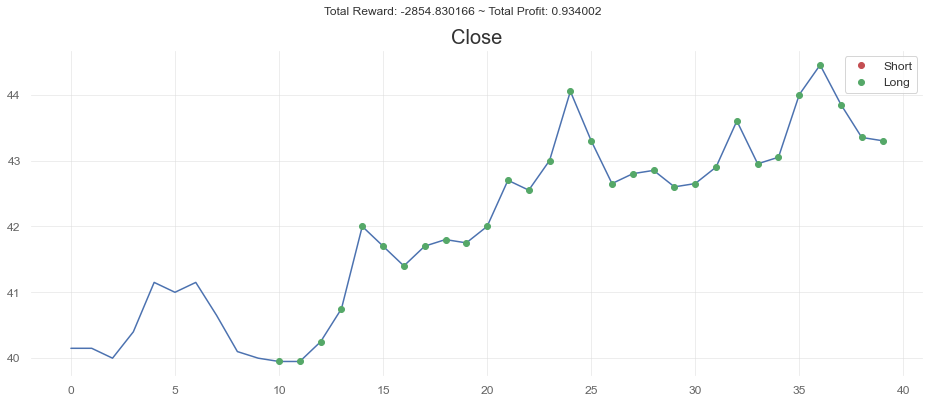

In [14]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


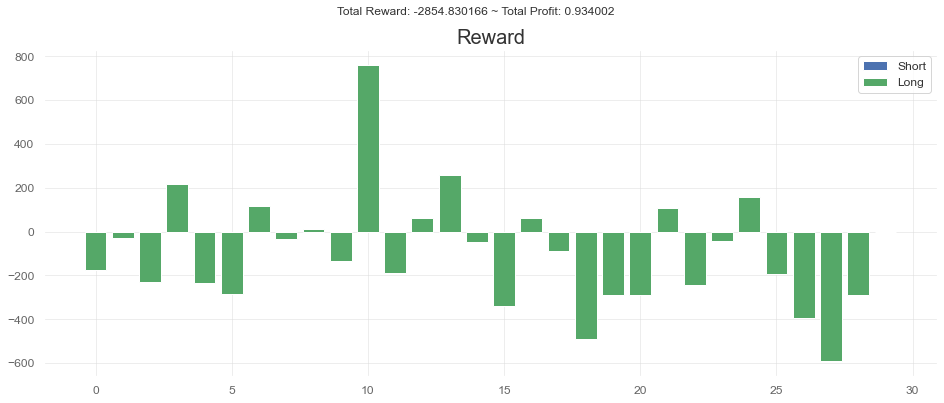

In [15]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


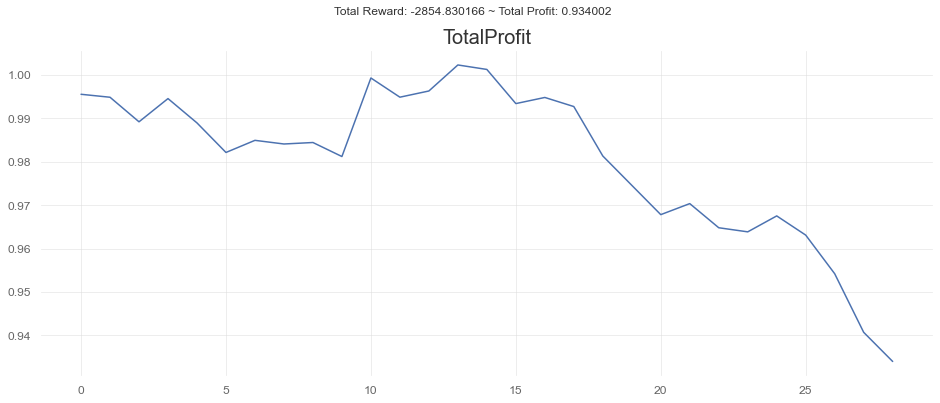

In [16]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [16]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)

目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數
注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]


第一個數字：大括號
第二個數字：有四個打橫
第三個數字：打橫入面有幾多個數字
(1, 4, 6)
[[[1 2 3 4 5 6]
  [2 4 5 6 5 6]
  [2 4 5 6 5 6]
  [2 4 5 6 5 6]]] 

第一個數字：有幾多大組嘅數字
第二個數字：入面有幾多個小組
第三個數字：每個小組入面有幾多個數字
(4, 3, 2)
[[[1 2]
  [3 4]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]

 [[2 4]
  [5 6]
  [5 6]]]
